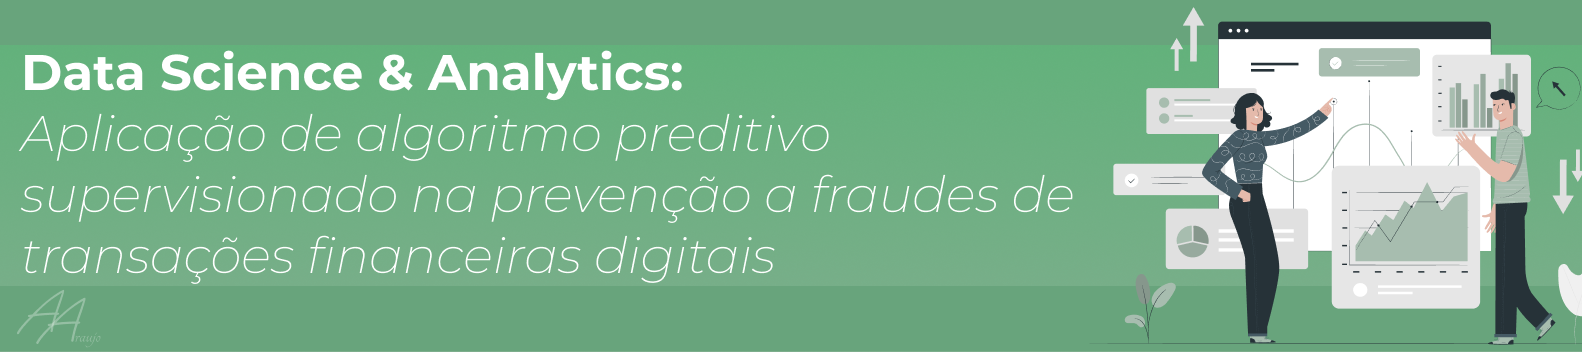
O objetivo desta pesquisa é desenvolver um algoritmo para a predição de fraudes em transações financeiras digitais. E tem como objetivos específicos: Testar diferentes algoritmos de ML supervisionados; Avaliar qual modelo apresenta o melhor desempenho nas predições das fraudes.
1. Análise Exploratória Inicial
- Análise Univariada
- Análise Bivariadas
2. Engenharia de Atributos
3. Seleção de Features
4. Resumo da Análise Exploratória
5. Analisando as correlações das variáveis
6. Variáveis Importantes para os modelos
7. Divisão do Conjunto de dados
8. Balanceamento com SMOTE
9. Normalização dos dados
10. Treinamento dos Modelos Supervisionados
- Random Forest
- Regressão Logística Binária
- XGBoost
- Redes Neurais Artificiais
- Support Vector Machine
11. Escolha do melhor modelo de Machine Learning


In [1]:
# Configurações de saída
options(scipen = 999, digits = 5, 
        repos = 'http://cran.rstudio.com/', 
        repr.plot.width = 20, 
        repr.plot.height = 10,
        warn = -1,
        dplyr.summarise.inform = FALSE)

In [18]:
# Importando as bibliotecas necessárias
if(!require(pacman)) install.packages('pacman')
library('pacman')
pacman::p_load(dplyr, data.table, ggplot2, moments, GGally, caret, ROSE, 
               smotefamily, randomForest, corrplot, kernlab, nnet, performance, 
               e1071, xgboost, DMwR, rpart)

Loading required package: pacman

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Importando o conjunto de dados
df <- read.csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')

In [3]:
# Verificando as dimensões do conjunto de dados
dim(df)

[1] 6362620      11

In [4]:
# Verificando as primeiras observações
head(df)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
,<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>
1,1,PAYMENT,9839.6,C1231006815,170136,160296,M1979787155,0,0,0,0
2,1,PAYMENT,1864.3,C1666544295,21249,19385,M2044282225,0,0,0,0
3,1,TRANSFER,181.0,C1305486145,181,0,C553264065,0,0,1,0
4,1,CASH_OUT,181.0,C840083671,181,0,C38997010,21182,0,1,0
5,1,PAYMENT,11668.1,C2048537720,41554,29886,M1230701703,0,0,0,0
6,1,PAYMENT,7817.7,C90045638,53860,46042,M573487274,0,0,0,0


In [5]:
# Verificando os tipos de dados
str(df)

'data.frame':	6362620 obs. of  11 variables:
 $ step          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ type          : chr  "PAYMENT" "PAYMENT" "TRANSFER" "CASH_OUT" ...
 $ amount        : num  9840 1864 181 181 11668 ...
 $ nameOrig      : chr  "C1231006815" "C1666544295" "C1305486145" "C840083671" ...
 $ oldbalanceOrg : num  170136 21249 181 181 41554 ...
 $ newbalanceOrig: num  160296 19385 0 0 29886 ...
 $ nameDest      : chr  "M1979787155" "M2044282225" "C553264065" "C38997010" ...
 $ oldbalanceDest: num  0 0 0 21182 0 ...
 $ newbalanceDest: num  0 0 0 0 0 ...
 $ isFraud       : int  0 0 1 1 0 0 0 0 0 0 ...
 $ isFlaggedFraud: int  0 0 0 0 0 0 0 0 0 0 ...


# 1. Análise Exploratória Inicial
Nesta etapa será realizado a exploração dos dados para compreender os tipos, distribuições, necessidades de limpezas ou tratamento de valores ausentes.

Para melhor compreensão das informações, será renomeado todas as variáveis do conjunto de dados, assim como os tipos de observações, traduzindo-os.

**Dicionário de dados:**

- tempo: Representa uma unidade de tempo 1 step = 1 hora.
- tipo_transacao: Indica o tipo de transação online.
- valor_transacao: Refere-se ao valor da transação.
- cliente_origem: Representa o cliente que iniciou a transação.
- saldo_anterior_origem: É o saldo antes da transação para o cliente de origem.
- novo_saldo_origem: É o saldo após a transação para o cliente de origem.
- cliente_destino: Indica o destinatário da transação.
- saldo_anterior_destino: Representa o saldo inicial do destinatário.
- novo_saldo_destino: É o saldo após a transação para o destinatário.
- flag_fraude: Marca se a transação é considerada ilegal (se o valor transferido excede um limite específico)
- isfraude: Indica se a transação é uma fraude (1: sim e 0: não).


In [6]:
# Renomeando as variáveis
lista_variaveis <- c('tempo','tipo_transacao','valor_transacao',
                      'cliente_origem','saldo_anterior_origem',
                      'novo_saldo_origem','cliente_destino',
                      'saldo_anterior_destino','novo_saldo_destino',
                      'isfraude','flag_fraude')

# Aplicando a transformação
names(df) <- lista_variaveis

# Renomeando as variáveis do "tipo_transacao"
lista_pagamentos <- c('CASH_IN' = 'Deposito',
                      'CASH_OUT' = 'Saque',
                      'DEBIT' = 'Debito',
                      'PAYMENT' = 'Pagamento',
                      'TRANSFER' = 'Transferencia'
                      )

# Aplicando a transformação
df$tipo_transacao <- unlist(lapply(df$tipo_transacao,
                                  function(x)lista_pagamentos[x]))

In [7]:
# Separando as variáveis
var_numericas <- c('tempo','valor_transacao','saldo_anterior_origem',
                  'saldo_anterior_destino','novo_saldo_origem',
                  'novo_saldo_destino')

var_categoricas <- c('tipo_transacao','isfraude','flag_fraude')

# Criando uma cópia do conjunto original
df1 <- df

# Alterando os tipos de dados
df1[var_numericas] <- sapply(df1[var_numericas], as.numeric)
df1$tipo_transacao <- as.factor(df1$tipo_transacao)
df1$isfraude <- as.factor(df1$isfraude)
df1$flag_fraude <- as.factor(df1$flag_fraude)

In [8]:
# Verificando as alterações
str(df1)

'data.frame':	6362620 obs. of  11 variables:
 $ tempo                 : num  1 1 1 1 1 1 1 1 1 1 ...
 $ tipo_transacao        : Factor w/ 5 levels "Debito","Deposito",..: 3 3 5 4 3 3 3 3 3 1 ...
 $ valor_transacao       : num  9840 1864 181 181 11668 ...
 $ cliente_origem        : chr  "C1231006815" "C1666544295" "C1305486145" "C840083671" ...
 $ saldo_anterior_origem : num  170136 21249 181 181 41554 ...
 $ novo_saldo_origem     : num  160296 19385 0 0 29886 ...
 $ cliente_destino       : chr  "M1979787155" "M2044282225" "C553264065" "C38997010" ...
 $ saldo_anterior_destino: num  0 0 0 21182 0 ...
 $ novo_saldo_destino    : num  0 0 0 0 0 ...
 $ isfraude              : Factor w/ 2 levels "0","1": 1 1 2 2 1 1 1 1 1 1 ...
 $ flag_fraude           : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...


In [9]:
# Verificando as estatísticas descritivas básica
summary(df1)

     tempo           tipo_transacao    valor_transacao    cliente_origem    
 Min.   :  1   Debito       :  41432   Min.   :       0   Length:6362620    
 1st Qu.:156   Deposito     :1399284   1st Qu.:   13390   Class :character  
 Median :239   Pagamento    :2151495   Median :   74872   Mode  :character  
 Mean   :243   Saque        :2237500   Mean   :  179862                     
 3rd Qu.:335   Transferencia: 532909   3rd Qu.:  208721                     
 Max.   :743                           Max.   :92445517                     
 saldo_anterior_origem novo_saldo_origem  cliente_destino   
 Min.   :       0      Min.   :       0   Length:6362620    
 1st Qu.:       0      1st Qu.:       0   Class :character  
 Median :   14208      Median :       0   Mode  :character  
 Mean   :  833883      Mean   :  855114                     
 3rd Qu.:  107315      3rd Qu.:  144258                     
 Max.   :59585040      Max.   :49585040                     
 saldo_anterior_destino novo_saldo

In [10]:
# Verificando as dimensões do dataset
obs <- dim(df1)[1]
variaveis <- dim(df1)[2]

sprintf('O dataset possui %s observações e %s variáveis', obs, variaveis)

[1] "O dataset possui 6362620 observações e 11 variáveis"

In [11]:
# Valores nulos
sum(is.na(df1))

[1] 0

In [12]:
# Analisando o volume de valores únicos por variável
for (var in names(df1)) {
  valores <- length(unique(df1[,var]))
  print(paste(var,':', valores))
}

[1] "tempo : 743"
[1] "tipo_transacao : 5"
[1] "valor_transacao : 5316900"
[1] "cliente_origem : 6353307"
[1] "saldo_anterior_origem : 1845844"
[1] "novo_saldo_origem : 2682586"
[1] "cliente_destino : 2722362"
[1] "saldo_anterior_destino : 3614697"
[1] "novo_saldo_destino : 3555499"
[1] "isfraude : 2"
[1] "flag_fraude : 2"


## 1.1 Análise Univariada
Classificar a variável em relação ao seu tipo qualitativa (nominal ou ordinal) ou quantitativa (discreta ou contínua), obter tabelas e gráficos ou medidas que resumam a variável.

### 1.1.1. Variável Qualitativa Nominal
As variáveis "tipo_transacao, cliente_origem, cliente_destino" são categorizada como Qualitativa Nominal, portanto, podemos realizar as seguintes análises:

- Tabela de frequências (absolutas e/ou relativas);
- Gráfico setorial;
- Moda (valor com maior frequência entre os dados).

****
**Analisando a variável** `tipo_transacao`:

In [13]:
# Analisando o tipo da variável
str(df1$tipo_transacao)

 Factor w/ 5 levels "Debito","Deposito",..: 3 3 5 4 3 3 3 3 3 1 ...


In [14]:
# Verificando os valores únicos
unique(df1$tipo_transacao)

[1] Pagamento     Transferencia Saque         Debito        Deposito     
Levels: Debito Deposito Pagamento Saque Transferencia

In [15]:
# Total de valores nulos
colSums(is.na(df1))['tipo_transacao']

tipo_transacao 
             0

In [16]:
# Frequência absoluta
fa_tipo<- data.table::data.table(table(df1$tipo_transacao))
names(fa_tipo) <- c('tipo_transacao','freq')
fa_tipo <- fa_tipo[order(-fa_tipo$freq),]
fa_tipo

tipo_transacao,freq
<chr>,<int>
Saque,2237500
Pagamento,2151495
Deposito,1399284
Transferencia,532909
Debito,41432


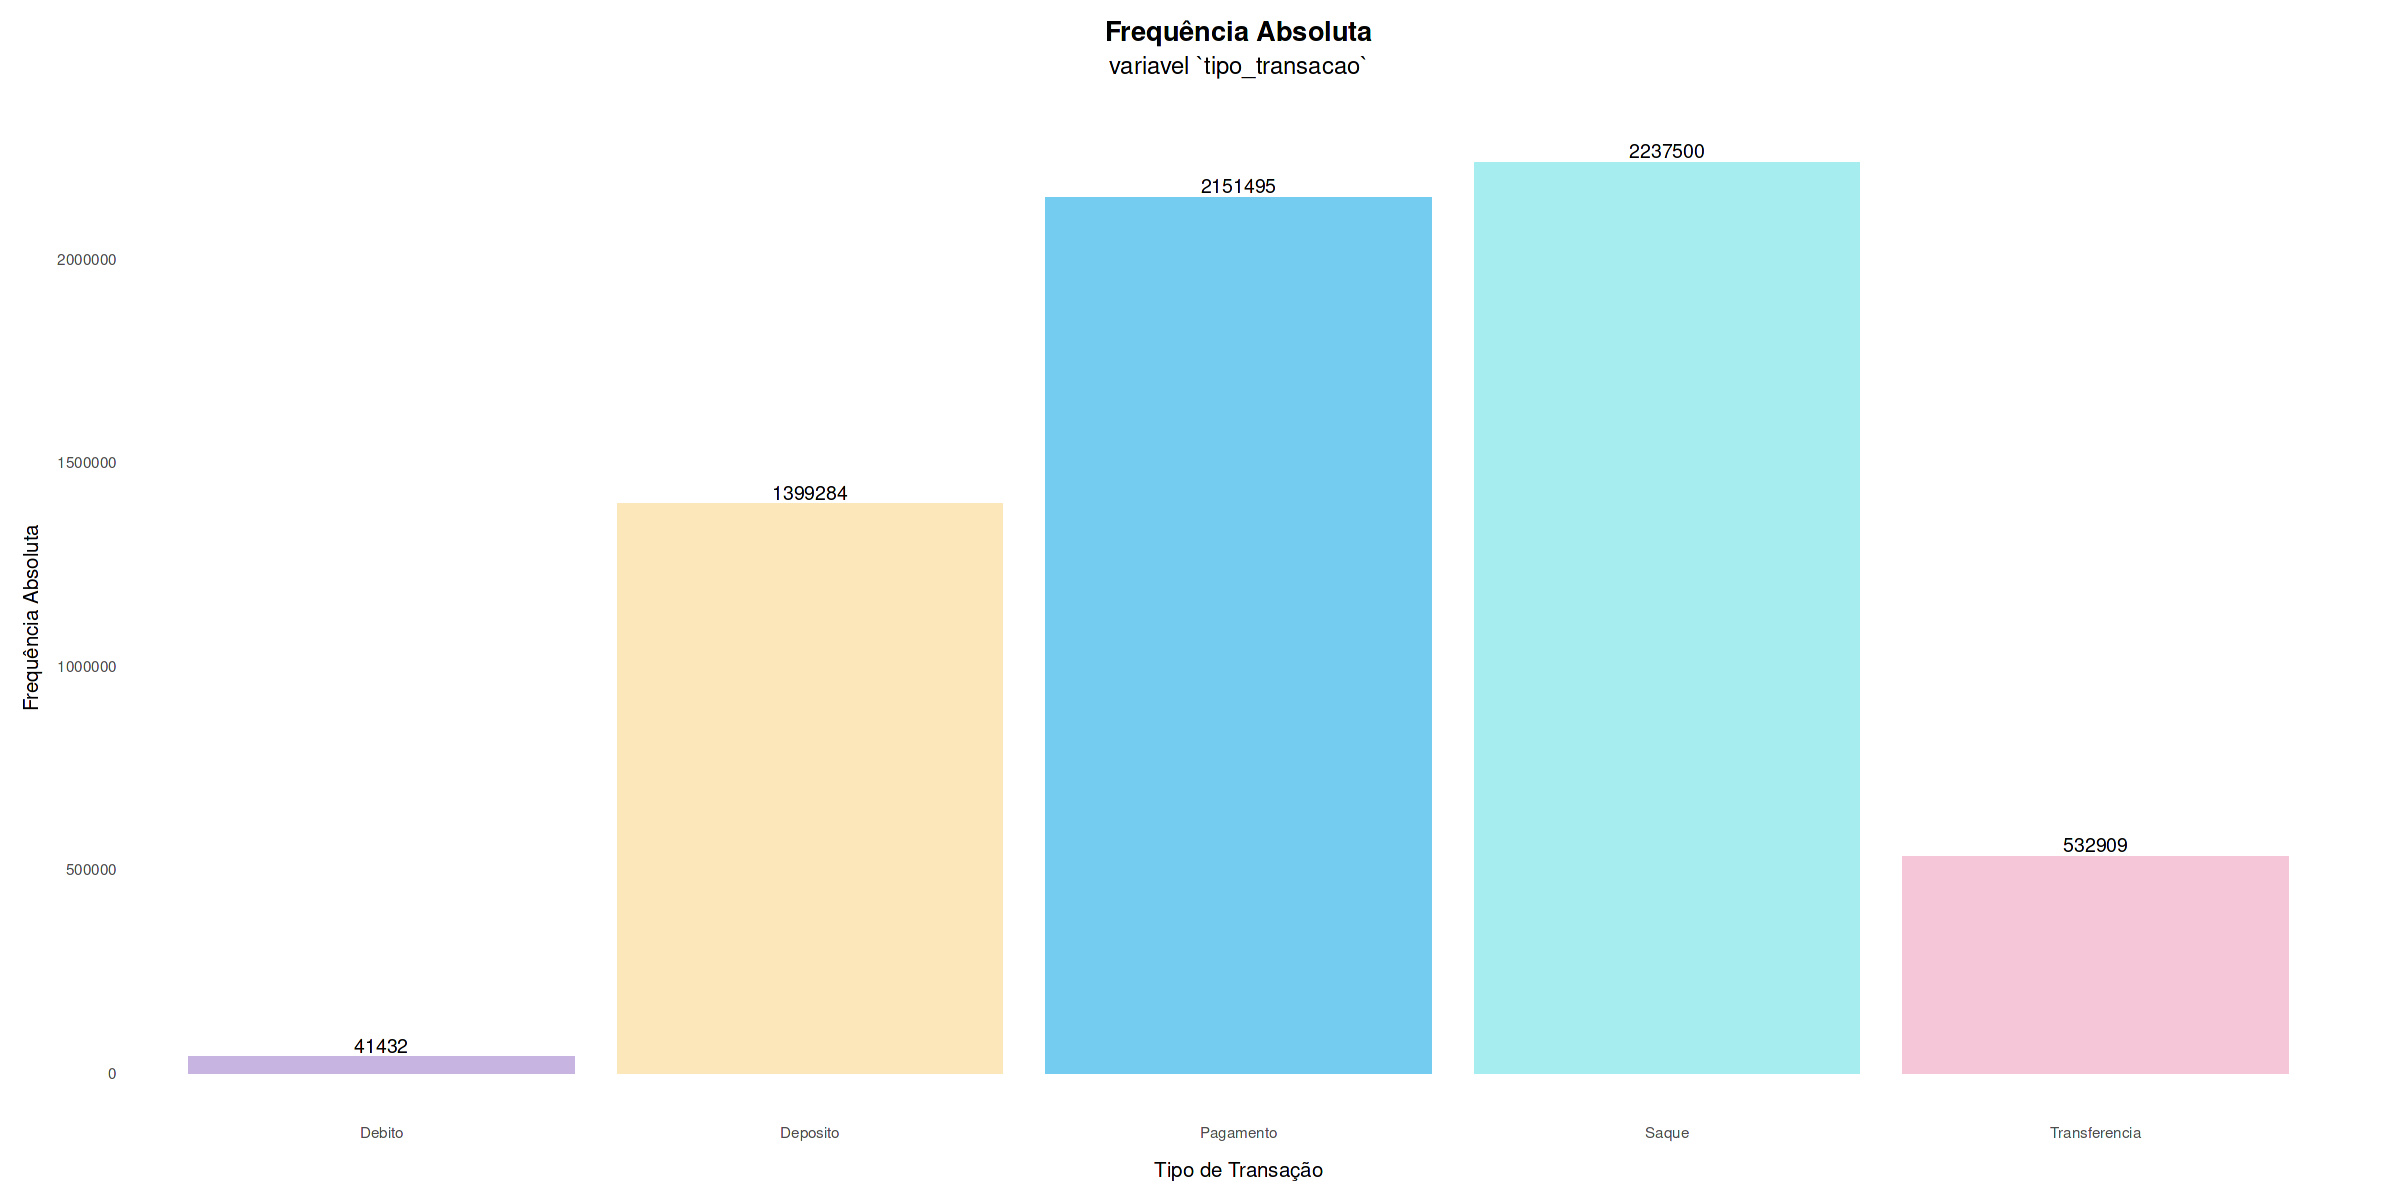

In [19]:
# Visualização gráfica da frequência Absoluta da variável `tipo_transacao`
ggplot(fa_tipo) +
  aes(x = tipo_transacao, y = freq) +
  geom_col(fill = c("#a6edf0", "#75ccf1", "#fce7ba", "#f5c6d7", "#c7b4e0")) +
  labs(
    x = "Tipo de Transação",
    y = "Frequência Absoluta",
    title = "Frequência Absoluta",
    subtitle = "variavel `tipo_transacao`"
  ) +
  geom_text(aes(label = freq), vjust = -0.3, size = 4) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

In [20]:
# Frequência relativa
fr_tipo<- data.table::data.table(prop.table(table(df1$tipo_transacao)) * 100)
names(fr_tipo) <- c('tipo_transacao','freq')
fr_tipo <- fr_tipo[order(-fr_tipo$freq),]
fr_tipo

tipo_transacao,freq
<chr>,<dbl>
Saque,35.16633
Pagamento,33.81461
Deposito,21.99226
Transferencia,8.37562
Debito,0.65118


In [21]:
# Moda
fr_tipo[fr_tipo$freq == max(fr_tipo$freq),'tipo_transacao']

tipo_transacao
<chr>
Saque


O tipo de transação com maior percentual é o Saque (35,16%), seguido de Pagamentos (33,81%) e Depósitos (21,99%).

****
Analisando a variável `cliente_origem`: Indica o cliente que iniciou a transação

In [22]:
# Analisando o tipo da variável
str(df1$cliente_origem)

 chr [1:6362620] "C1231006815" "C1666544295" "C1305486145" "C840083671" ...


In [23]:
# Analisando os valores únicos
total_registro_origem <- dim(df1)[1]
total_cliente_origem <- length(unique(df1$cliente_origem))
percentual <- round(total_cliente_origem/total_registro_origem, digits = 2)
sprintf('Total de valores únicos (cliente_origem): %s (%s)',
        total_cliente_origem,
        paste0(percentual * 100,'%'))

[1] "Total de valores únicos (cliente_origem): 6353307 (100%)"

In [24]:
# Total de valores nulos
colSums(is.na(df1))['cliente_origem']

cliente_origem 
             0

In [25]:
# Frequência absoluta
fa_cliente_origem<- data.table::data.table(table(df1$cliente_origem))
names(fa_cliente_origem) <- c('cliente_origem','freq')
fa_cliente_origem <- fa_cliente_origem[order(-fa_cliente_origem$freq),]
head(fa_cliente_origem,5)

cliente_origem,freq
<chr>,<int>
C1065307291,3
C1462946854,3
C1530544995,3
C1677795071,3
C1784010646,3


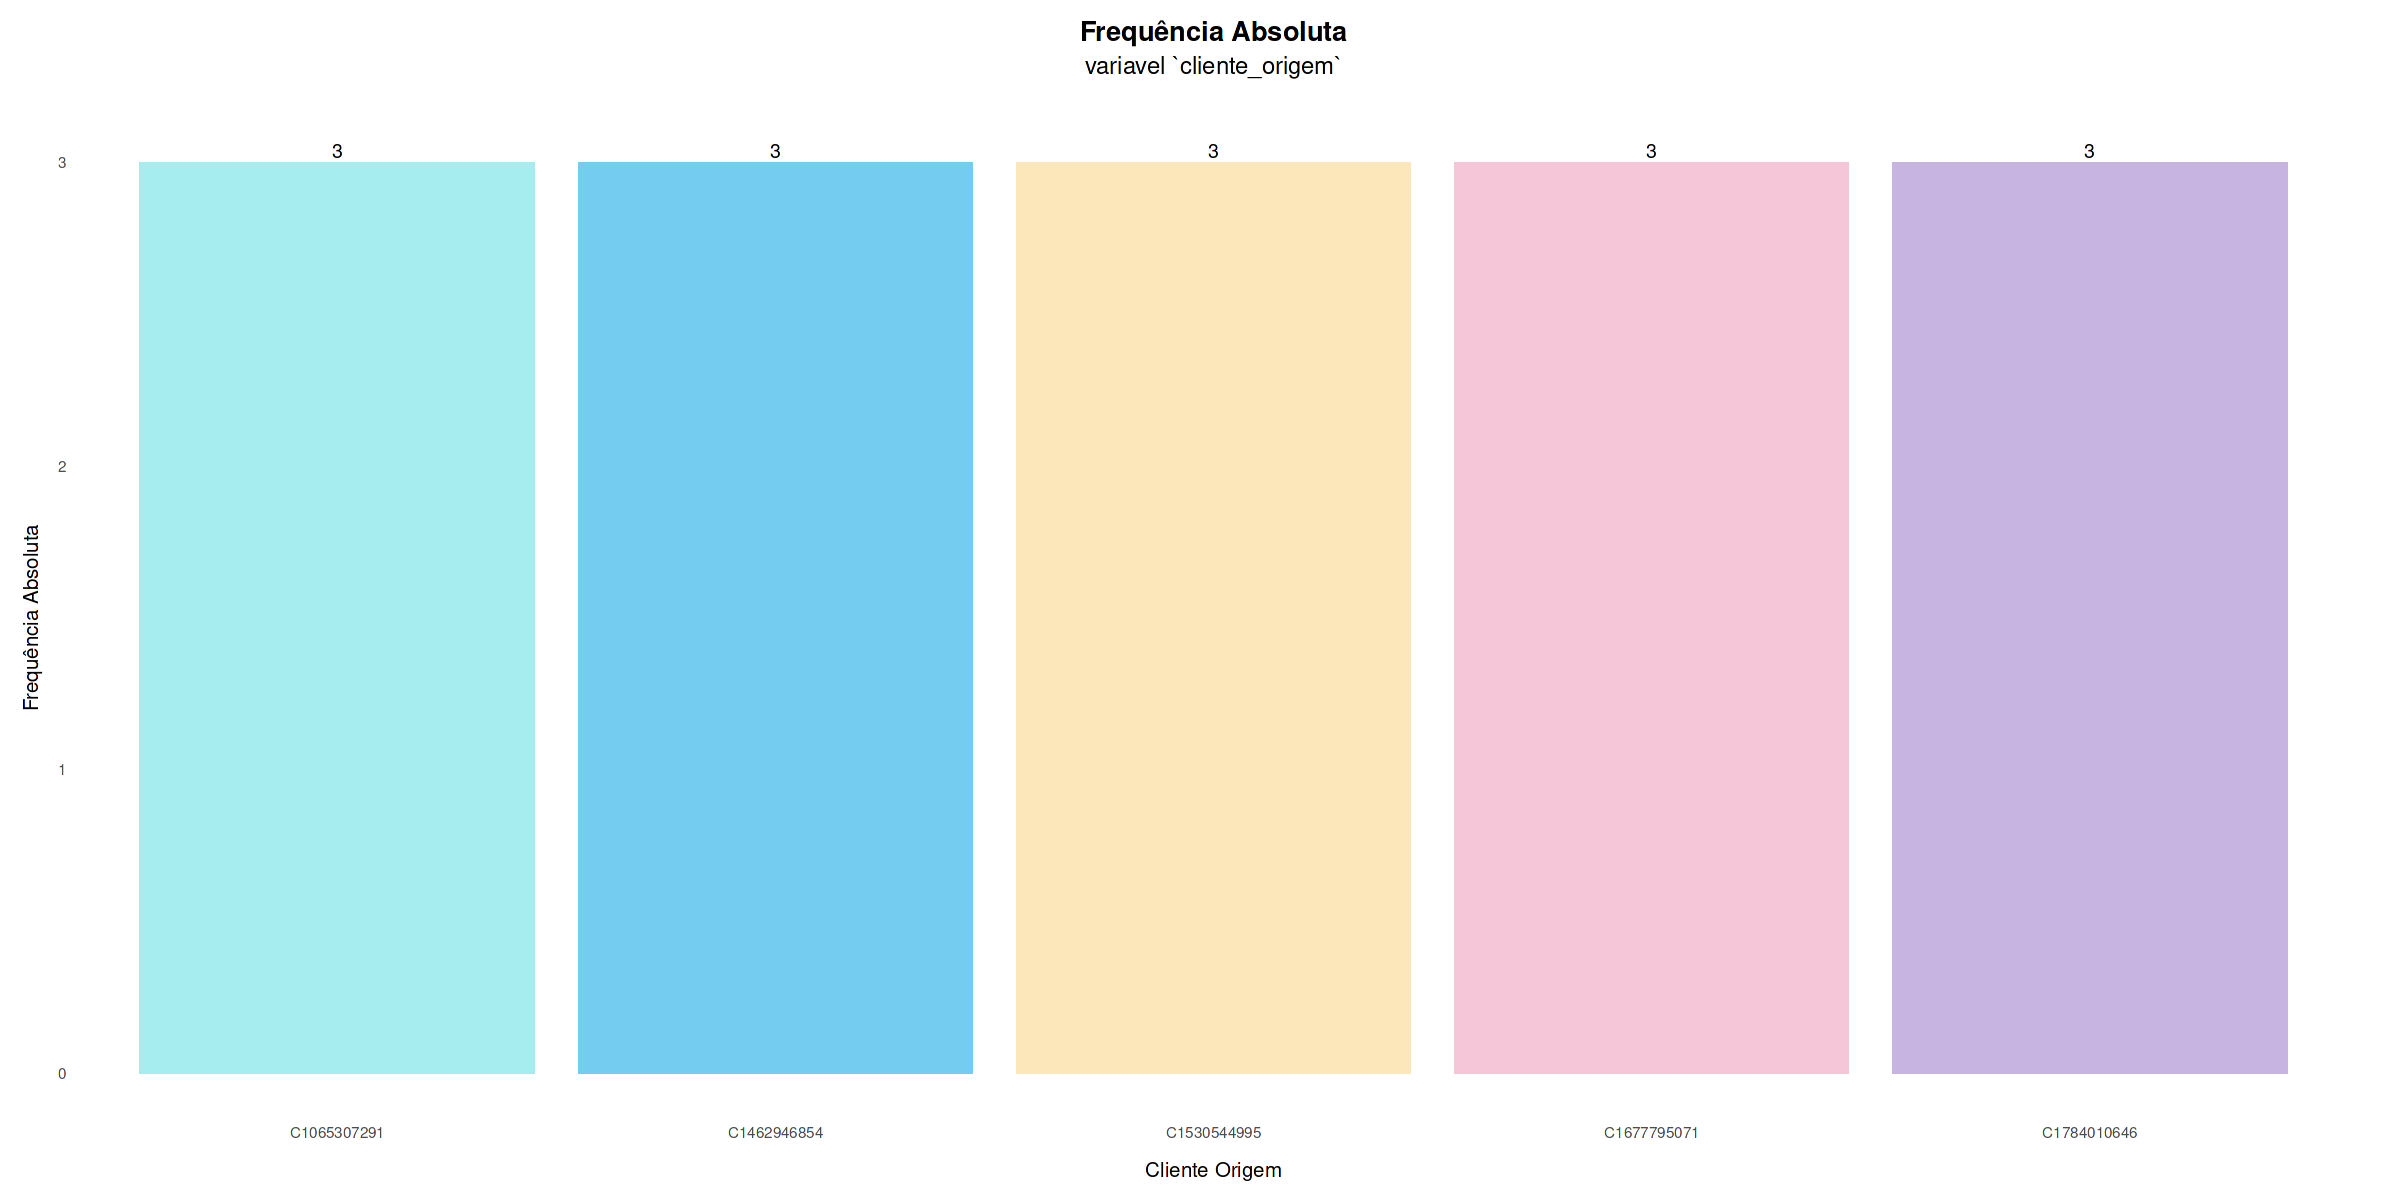

In [26]:
# Visualização gráfica da frequência Absoluta da variável `tipo_transacao`
ggplot(head(fa_cliente_origem,5)) +
  aes(x = cliente_origem, y = freq) +
  geom_col(fill = c("#a6edf0", "#75ccf1", "#fce7ba", "#f5c6d7", "#c7b4e0")) +
  labs(
    x = "Cliente Origem",
    y = "Frequência Absoluta",
    title = "Frequência Absoluta",
    subtitle = "variavel `cliente_origem`"
  ) +
  geom_text(aes(label = freq), vjust = -0.3, size = 4) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

****
**Analisando a variável** `cliente_destino`:
Indica o destinatário da transação

In [27]:
# Analisando o tipo da variável
str(df1$cliente_destino)

 chr [1:6362620] "M1979787155" "M2044282225" "C553264065" "C38997010" ...


In [28]:
# Analisando os valores únicos
total_registro <- dim(df1)[1]
total_cliente_destino <- length(unique(df1$cliente_destino))
percentual <- round(total_cliente_destino/total_registro, digits = 2)
sprintf('Total de valores únicos (cliente_destino): %s (%s)',
        total_cliente_destino,
        paste0(percentual * 100,'%'))

[1] "Total de valores únicos (cliente_destino): 2722362 (43%)"

In [29]:
# Total de valores nulos
colSums(is.na(df1))['cliente_destino']

cliente_destino 
              0

In [30]:
# Frequência absoluta
fa_cliente_destino<- data.table::data.table(table(df1$cliente_destino))
names(fa_cliente_destino) <- c('cliente_destino','freq')
fa_cliente_destino <- fa_cliente_destino[order(-fa_cliente_destino$freq),]
head(fa_cliente_destino,5)

cliente_destino,freq
<chr>,<int>
C1286084959,113
C985934102,109
C665576141,105
C2083562754,102
C1590550415,101


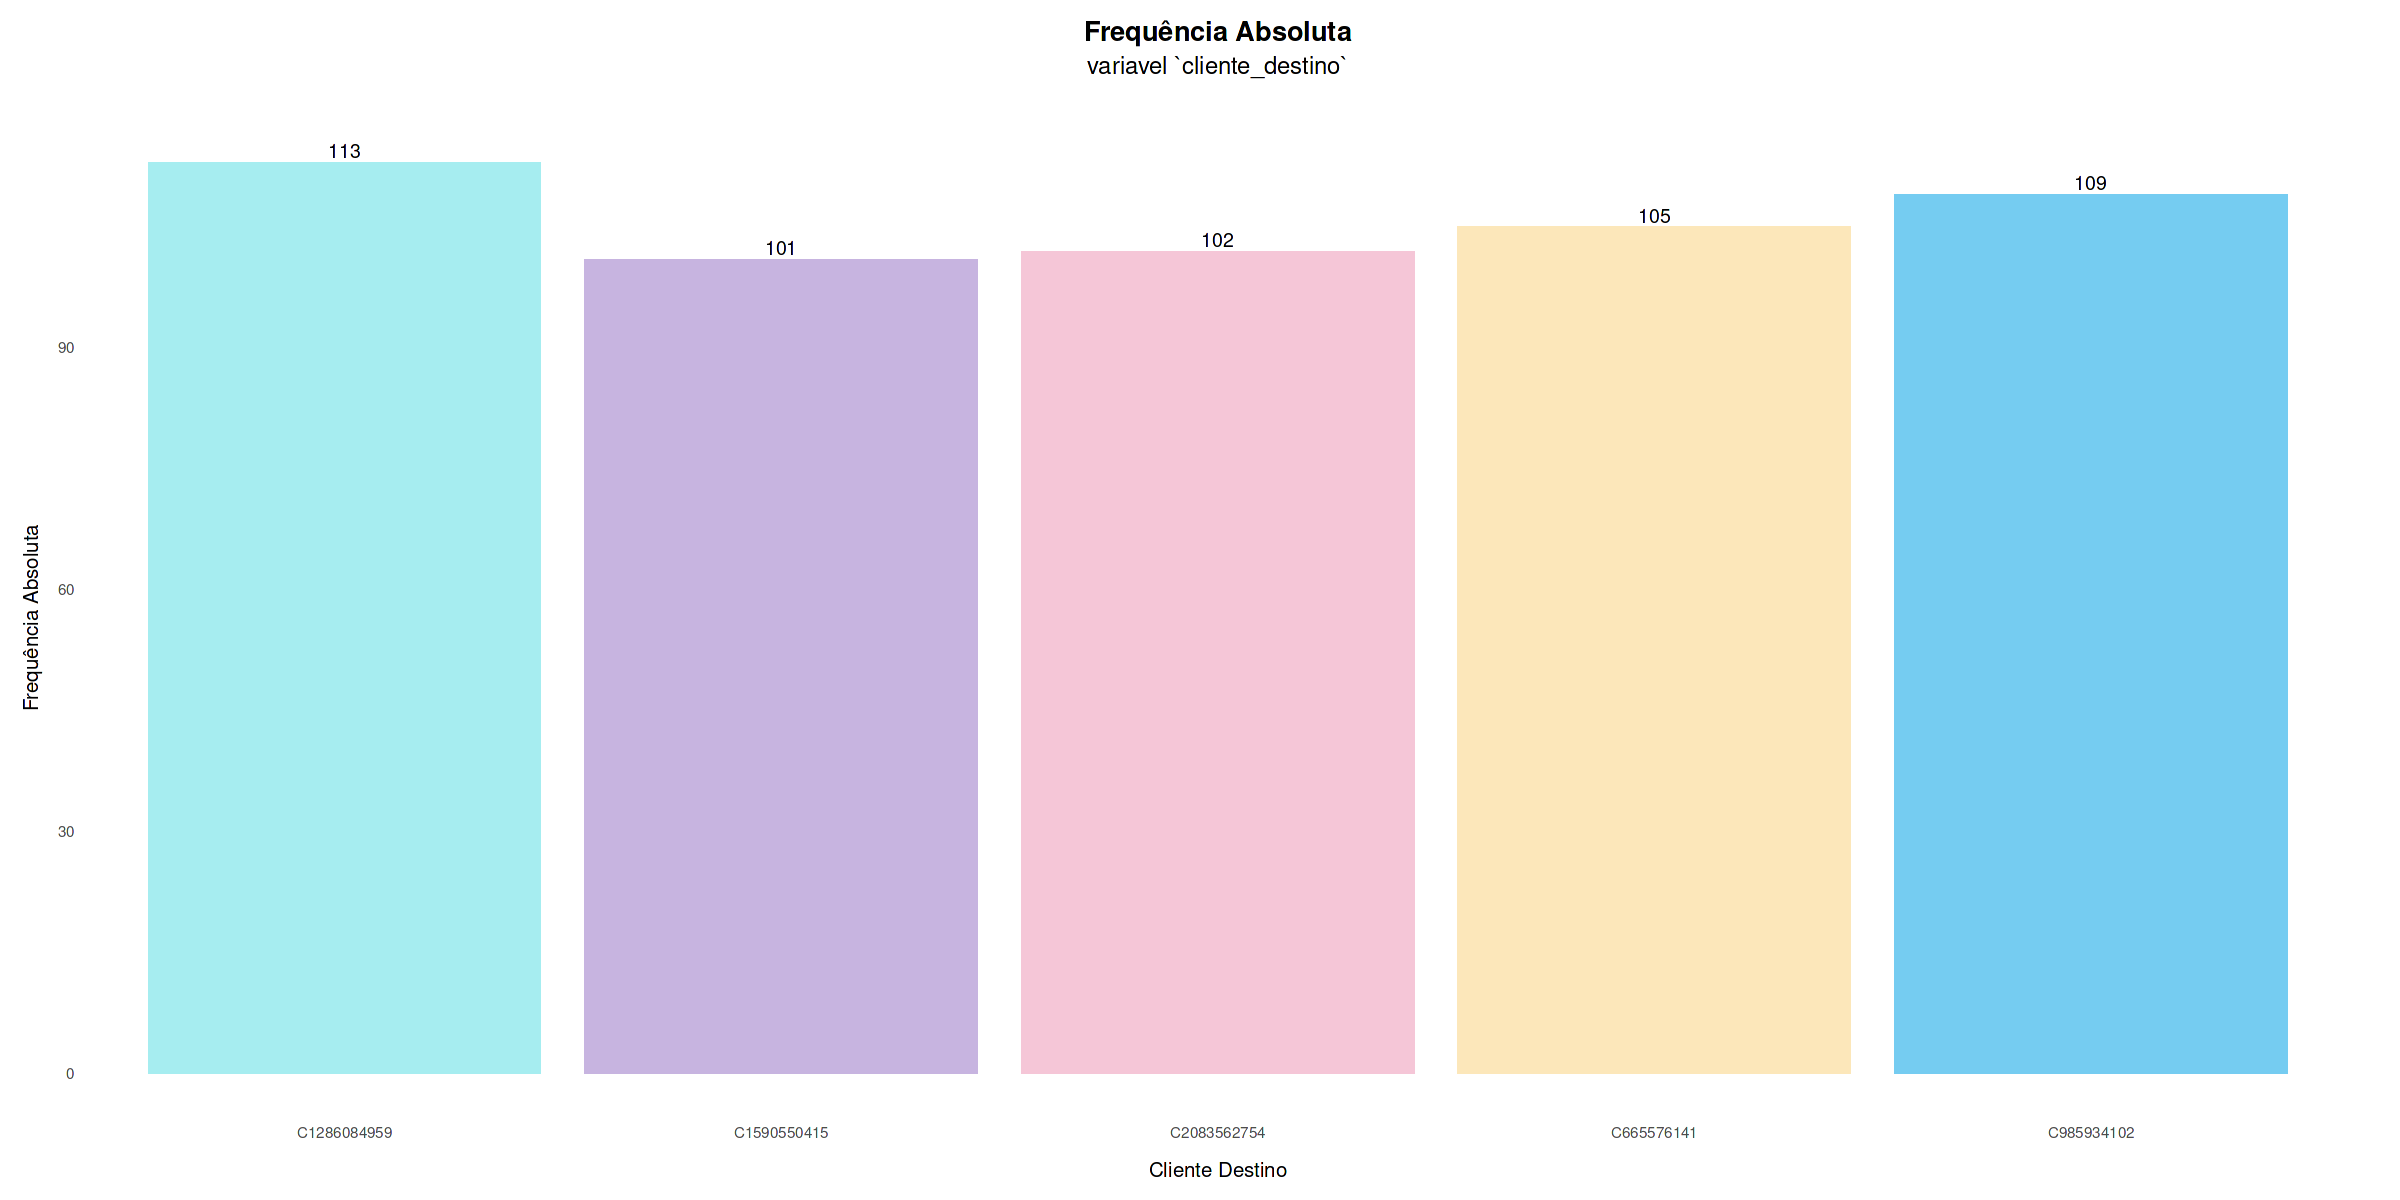

In [31]:
# Visualização gráfica da frequência Absoluta da variável `tipo_transacao`
ggplot(head(fa_cliente_destino,5)) +
  aes(x = cliente_destino, y = freq) +
  geom_col(fill = c("#a6edf0", "#75ccf1", "#fce7ba", "#f5c6d7", "#c7b4e0")) +
  labs(
    x = "Cliente Destino",
    y = "Frequência Absoluta",
    title = "Frequência Absoluta",
    subtitle = "variavel `cliente_destino`"
  ) +
  geom_text(aes(label = freq), vjust = -0.3, size = 4) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

In [32]:
# Frequência relativa
fr_cliente_destino<- data.table::data.table(prop.table(table(df1$cliente_destino)) * 100)
names(fr_cliente_destino) <- c('cliente_destino','freq')
fr_cliente_destino <- fr_cliente_destino[order(-fr_cliente_destino$freq),]
head(fr_cliente_destino,5)

cliente_destino,freq
<chr>,<dbl>
C1286084959,0.0017760
C985934102,0.0017131
C665576141,0.0016503
C2083562754,0.0016031
C1590550415,0.0015874


****
**Analisando a variável** `isfraude`:
Indica se a transação é uma fraude (1 para sim, 0 para não).

In [33]:
# Analisando o tipo da variável
str(df1$isfraude)

 Factor w/ 2 levels "0","1": 1 1 2 2 1 1 1 1 1 1 ...


In [34]:
# Verificando os valores únicos
unique(df1$isfraude)

[1] 0 1
Levels: 0 1

In [35]:
# Total de valores nulos
colSums(is.na(df1))['isfraude']

isfraude 
       0

In [36]:
# Frequência absoluta
fa_Fraude<- data.table::data.table(table(df1$isfraude))
names(fa_Fraude) <- c('classe','freq')
fa_Fraude <- fa_Fraude[order(-fa_Fraude$freq),]
fa_Fraude

classe,freq
<chr>,<int>
0,6354407
1,8213


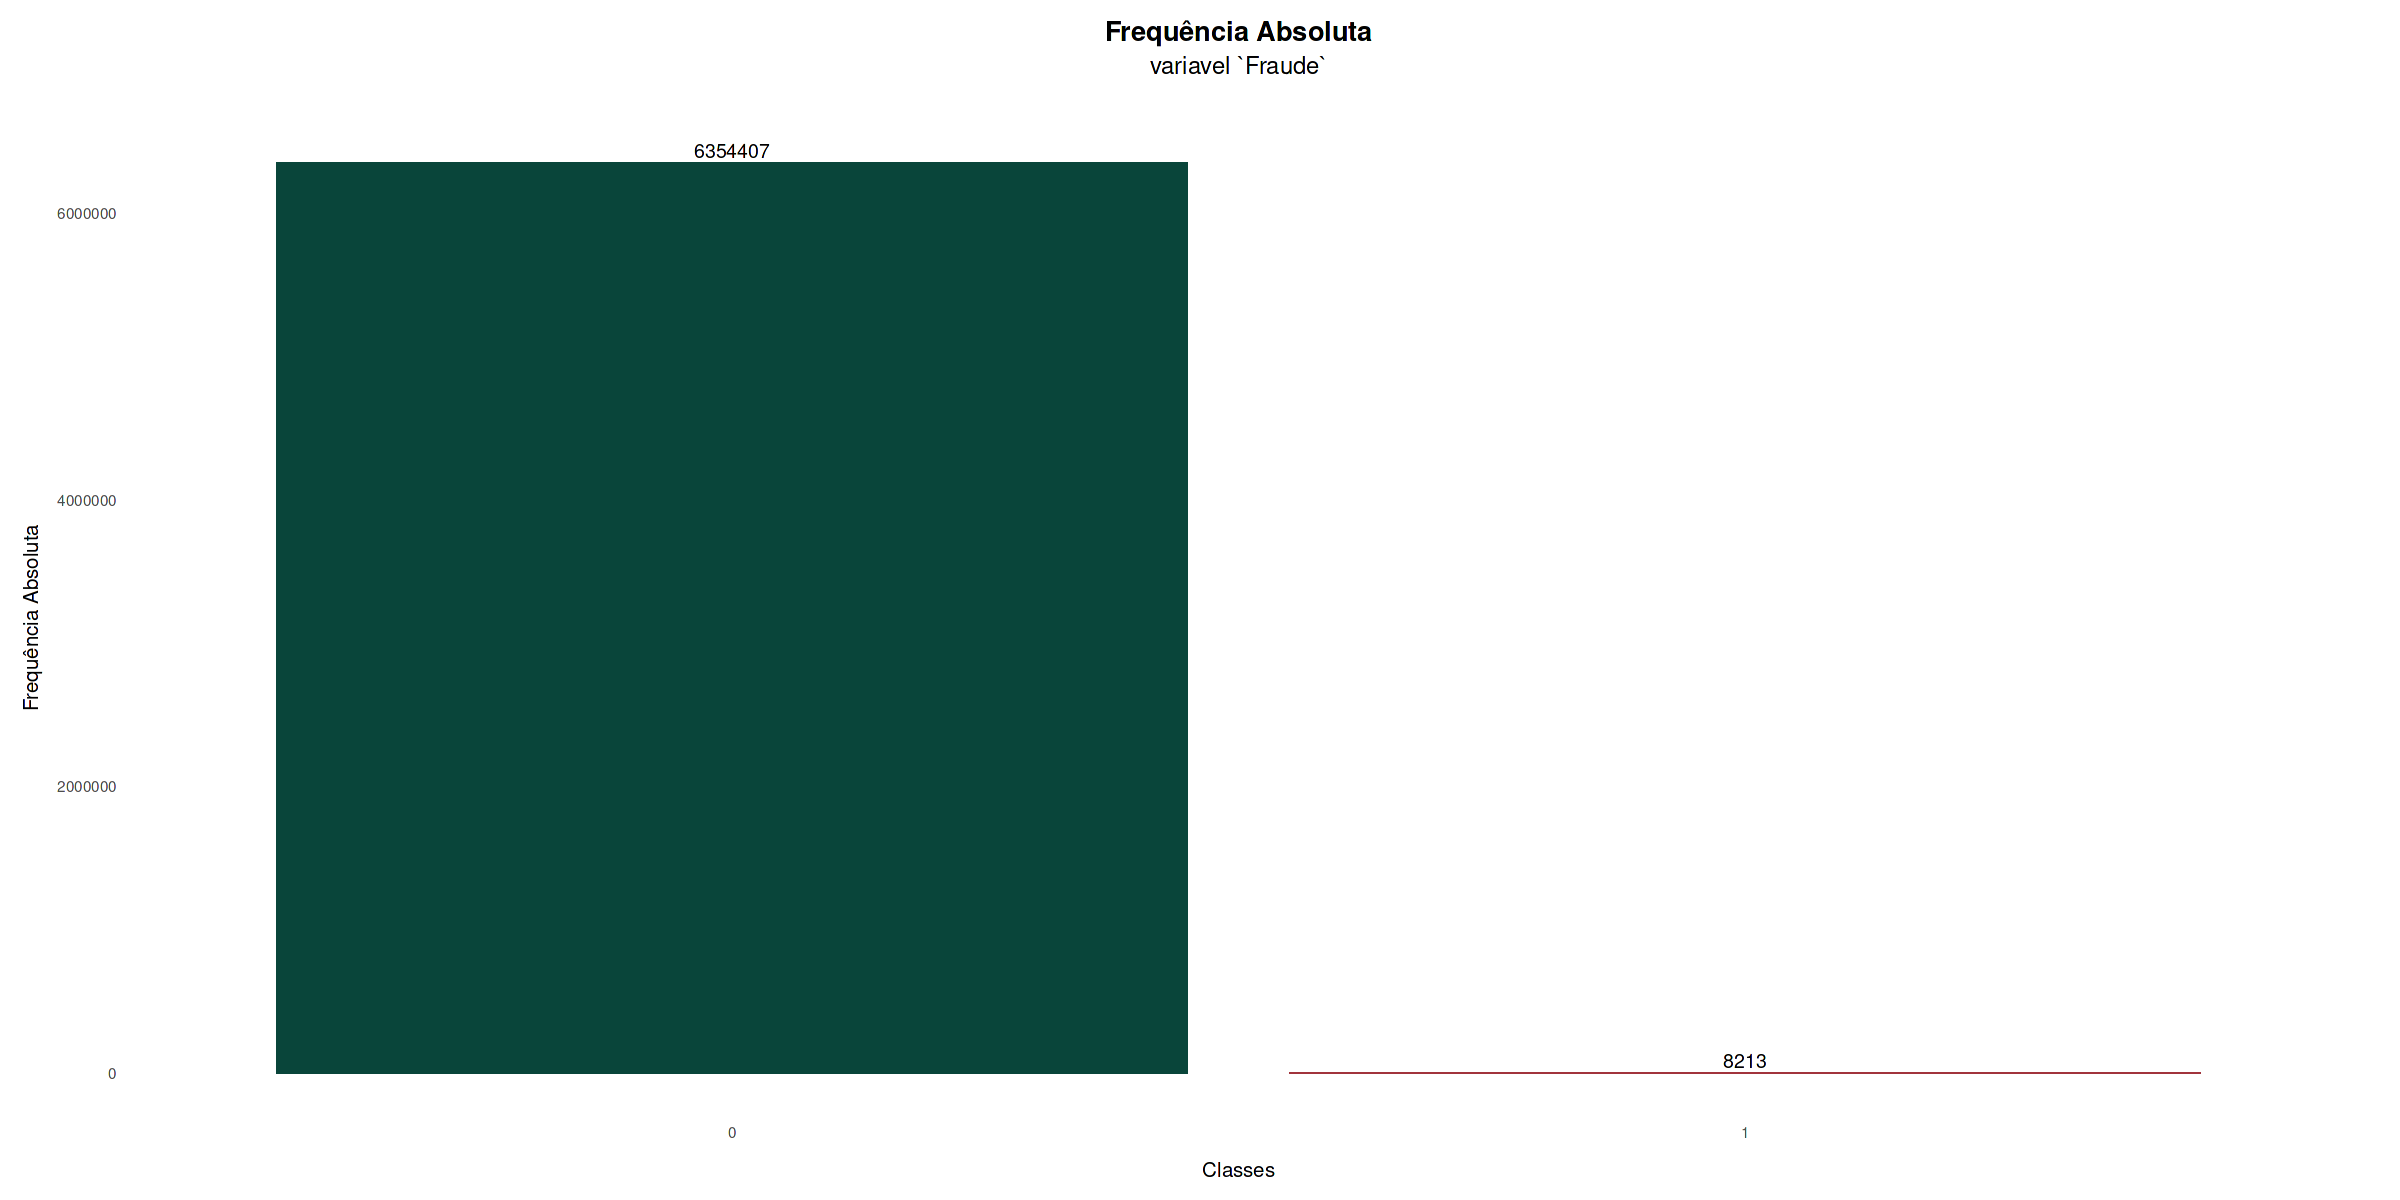

In [37]:
# Visualização gráfica da frequência Absoluta da variável `tipo_transacao`
ggplot(fa_Fraude) +
  aes(x = classe, y = freq) +
  geom_col(fill = c("#09453a", "#a1343c")) +
  labs(
    x = "Classes",
    y = "Frequência Absoluta",
    title = "Frequência Absoluta",
    subtitle = "variavel `Fraude`"
  ) +
  geom_text(aes(label = freq), vjust = -0.3, size = 4) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

In [38]:
# Frequência relativa
fr_Fraude<- data.table::data.table(prop.table(table(df1$isfraude)) * 100)
names(fr_Fraude) <- c('classe','freq')
fr_Fraude <- fr_Fraude[order(-fr_Fraude$freq),]
fr_Fraude

classe,freq
<chr>,<dbl>
0,99.87092
1,0.12908


In [39]:
# Moda
fr_Fraude[fr_Fraude$freq == max(fr_Fraude$freq),'classe']

classe
<chr>
0


****
**Analisando a variável** `flag_fraude`:
Indica se a transação é considerada ilegal (limite acima de 200k)

In [40]:
# Analisando o tipo da variável
str(df1$flag_fraude)

 Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...


In [41]:
# Verificando os valores únicos
unique(df1$flag_fraude)

[1] 0 1
Levels: 0 1

In [42]:
# Total de valores nulos
colSums(is.na(df1))['flag_fraude']

flag_fraude 
          0

In [43]:
# Frequência absoluta
fa_flag<- data.table::data.table(table(df1$flag_fraude))
names(fa_flag) <- c('flag','freq')
fa_flag <- fa_flag[order(-fa_flag$freq),]
fa_flag

flag,freq
<chr>,<int>
0,6362604
1,16


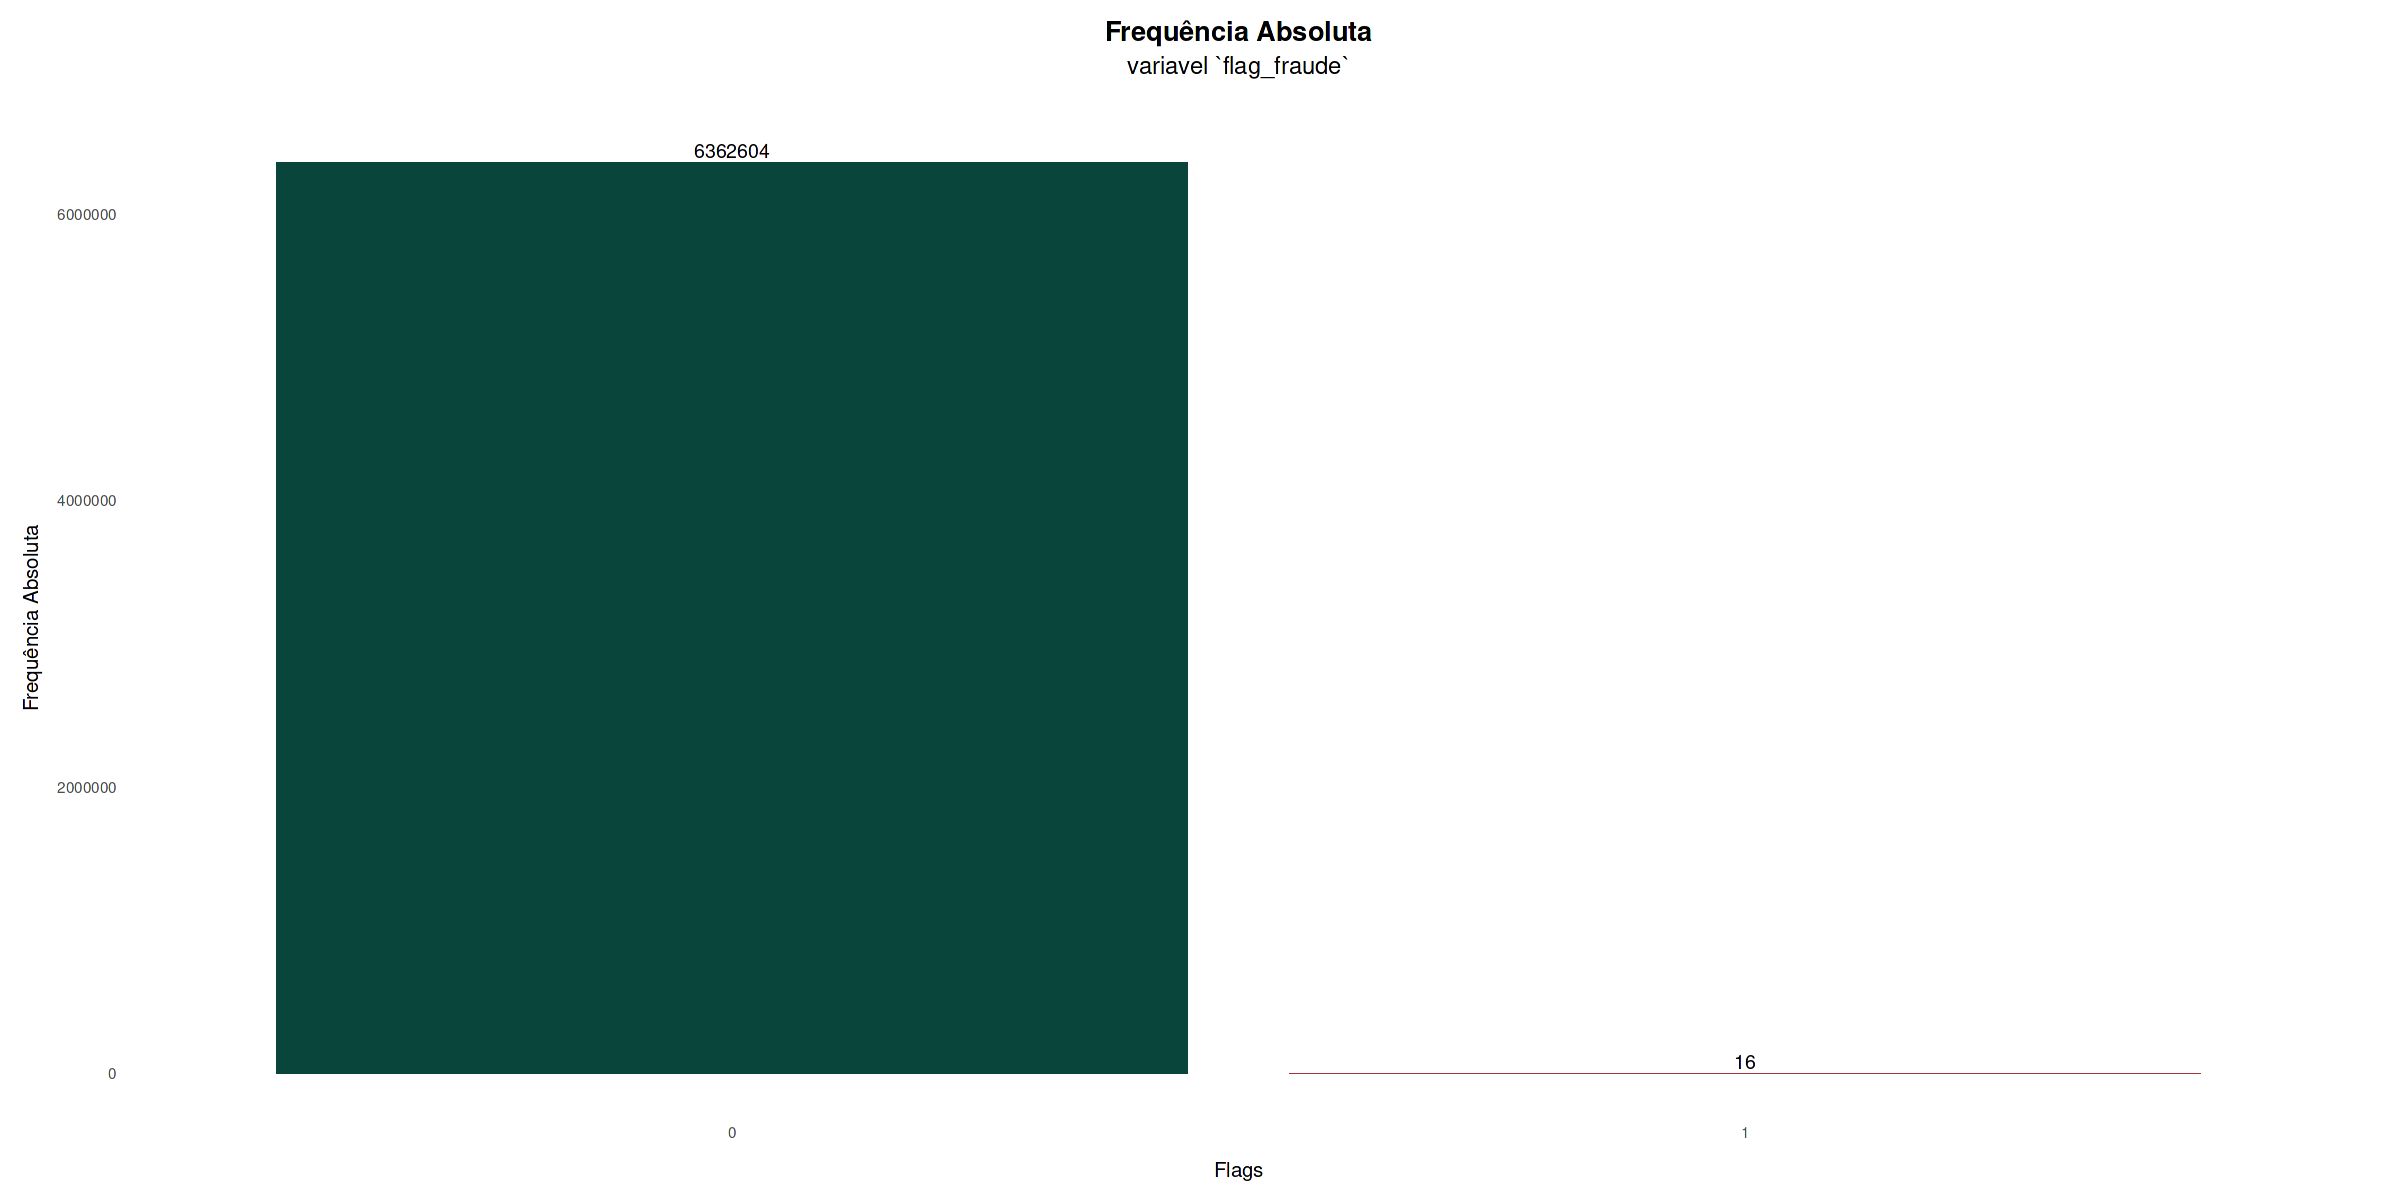

In [44]:
# Visualização gráfica da frequência Absoluta da variável `tipo_transacao`
ggplot(fa_flag) +
  aes(x = flag, y = freq) +
  geom_col(fill = c("#09453a", "#a1343c")) +
  labs(
    x = "Flags",
    y = "Frequência Absoluta",
    title = "Frequência Absoluta",
    subtitle = "variavel `flag_fraude`"
  ) +
  geom_text(aes(label = freq), vjust = -0.3, size = 4) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

In [45]:
# Frequência relativa
fr_flag<- data.table::data.table(prop.table(table(df1$flag_fraude)) * 100)
names(fr_flag) <- c('flag','freq')
fr_flag <- fr_flag[order(-fr_flag$freq),]
fr_flag

flag,freq
<chr>,<dbl>
0,99.99974853
1,0.00025147


In [46]:
# Moda
fr_flag[fr_flag$freq == max(fr_flag$freq),'flag']

flag
<chr>
0


### 1.1.2. Variável Quantitativas

As variáveis `tempo`,`valor_transacao`,`saldo_anterior_origem`,`novo_saldo_origem`,`saldo_anterior_destino`,`novo_saldo_destino` são categorizada como Quantitativas, portanto, podemos realizar as seguintes análises:

1. Análises de medidas de posição (média, mediana, moda, quartis, decis e percentis);
2. Medidas de dispersão (amplitude, desvio-médio, variância, desvio padrão e coeficiente de variação);
3. Análise gráficas (linhas, dispersão, histogramas, “boxplot”);
4. Medidas de formas, como assimetria ou curtose.
****
**Analisando a variável** `valor_transacao`:
Refere-se ao valor da transação efetuada


In [47]:
# Analisando o tipo da variável
str(df1$valor_transacao)

 num [1:6362620] 9840 1864 181 181 11668 ...


In [48]:
# Estatísticas descritivas básica
summary(df1$valor_transacao)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0    13390    74872   179862   208721 92445517 

In [49]:
# Outras estatísticas
sprintf('Moda: %.2f',unique(df1[df1$valor_transacao == max(df1$valor_transacao),'valor_transacao']))
sprintf('Mínimo: %s | Máximo: %s', range(df1$valor_transacao)[1],range(df1$valor_transacao)[2])
sprintf('Amplitude: %s', diff(range(df1$valor_transacao)))
sprintf('Variância: %.2f', var(df1$valor_transacao))
sprintf('Desvio Padrão: %.2f', sd(df1$valor_transacao))
sprintf('Coeficiente de Variação: %.2f', sd(df1$valor_transacao)/mean(df1$valor_transacao))

[1] "Moda: 92445516.64"

[1] "Mínimo: 0 | Máximo: 92445516.64"

[1] "Amplitude: 92445516.64"

[1] "Variância: 364644763705.54"

[1] "Desvio Padrão: 603858.23"

[1] "Coeficiente de Variação: 3.36"

-   A variância é bastante elevada, o que sugere uma grande dispersão dos valores de transação em relação à média. O mesmo ocorre com o desvio padrão, que é considerável em relação à média.

-   Isso indica uma grande variabilidade nos valores das transações. Pode ser útil investigar as razões por trás dessa variabilidade, como diferentes tipos de transações, clientes ou circunstâncias.

-   Os outliers podem conter informações valiosas sobre padrões de fraude. Eles podem representar transações fraudulentas que se desviam significativamente do comportamento típico das transações legítimas. Ignorar esses outliers pode resultar na perda de informações importantes para o modelo de detecção de fraude.

- O coeficiente de variação é 1,69 vezes a média, ou seja, são relativamente dispersos em relação à média.

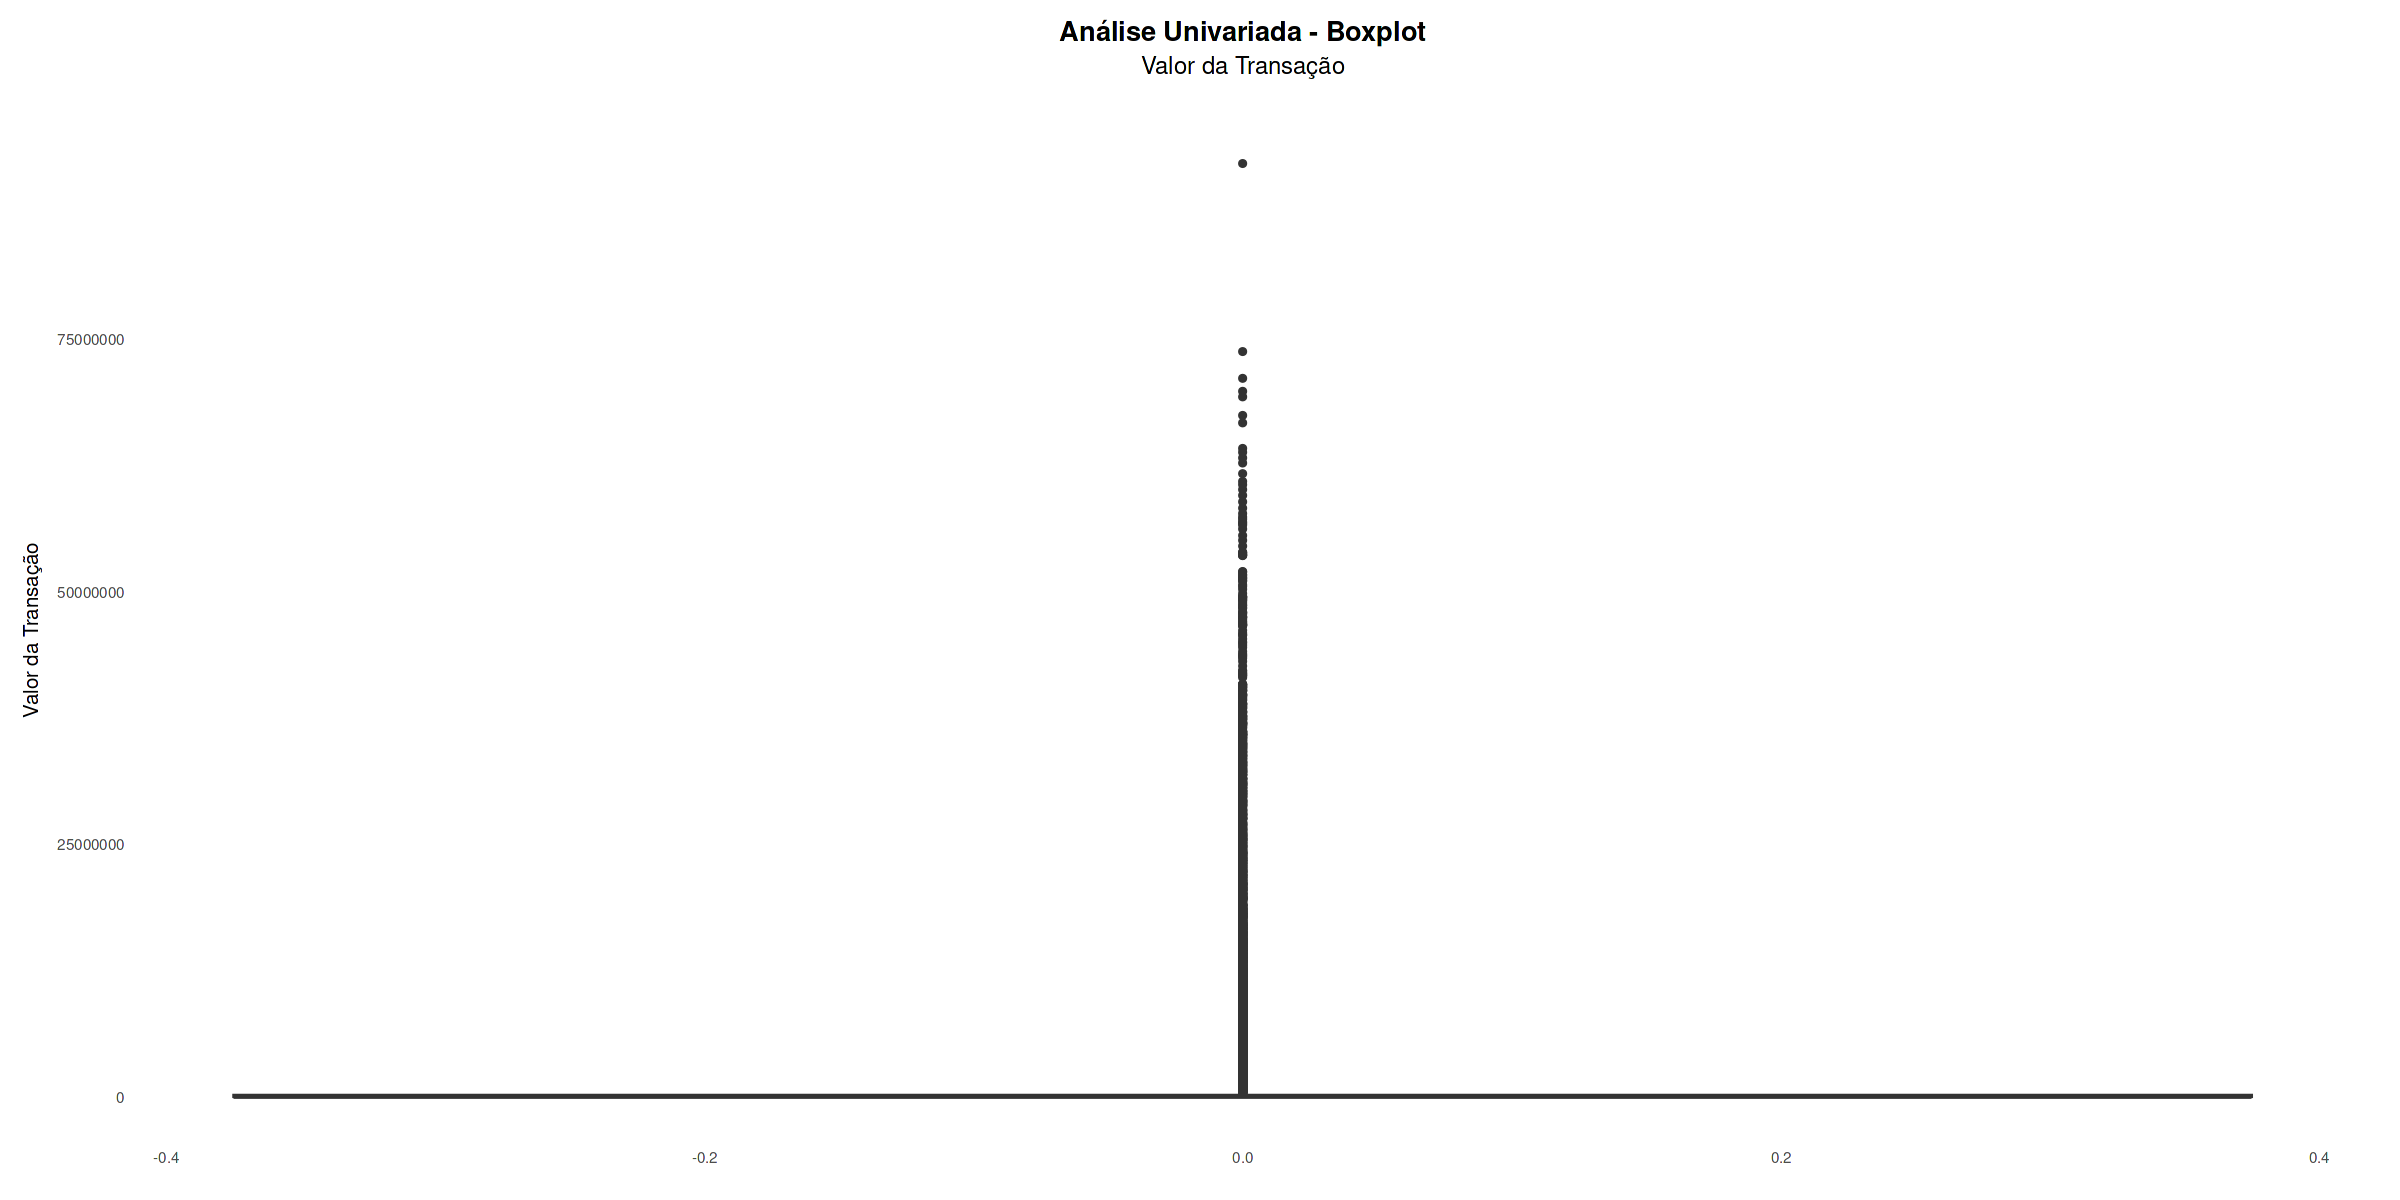

In [50]:
# Visualizando os valores das transações
ggplot(df1, aes(y = valor_transacao)) +
  geom_boxplot() +
  scale_fill_manual(values = c("#102346")) +
  labs(
    y = "Valor da Transação",
    title = "Análise Univariada - Boxplot",
    subtitle = "Valor da Transação"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

Sobre o boxplot de valores das transações:

*   A maioria dos valores estão concentrados entre 0 e 10 milhões;
*   Há presença de outliers, valores muito acima da maioria das transações;
*   Necessário analisar os valores distantes para identificar se realmente são transações legais ou fraudulentas.


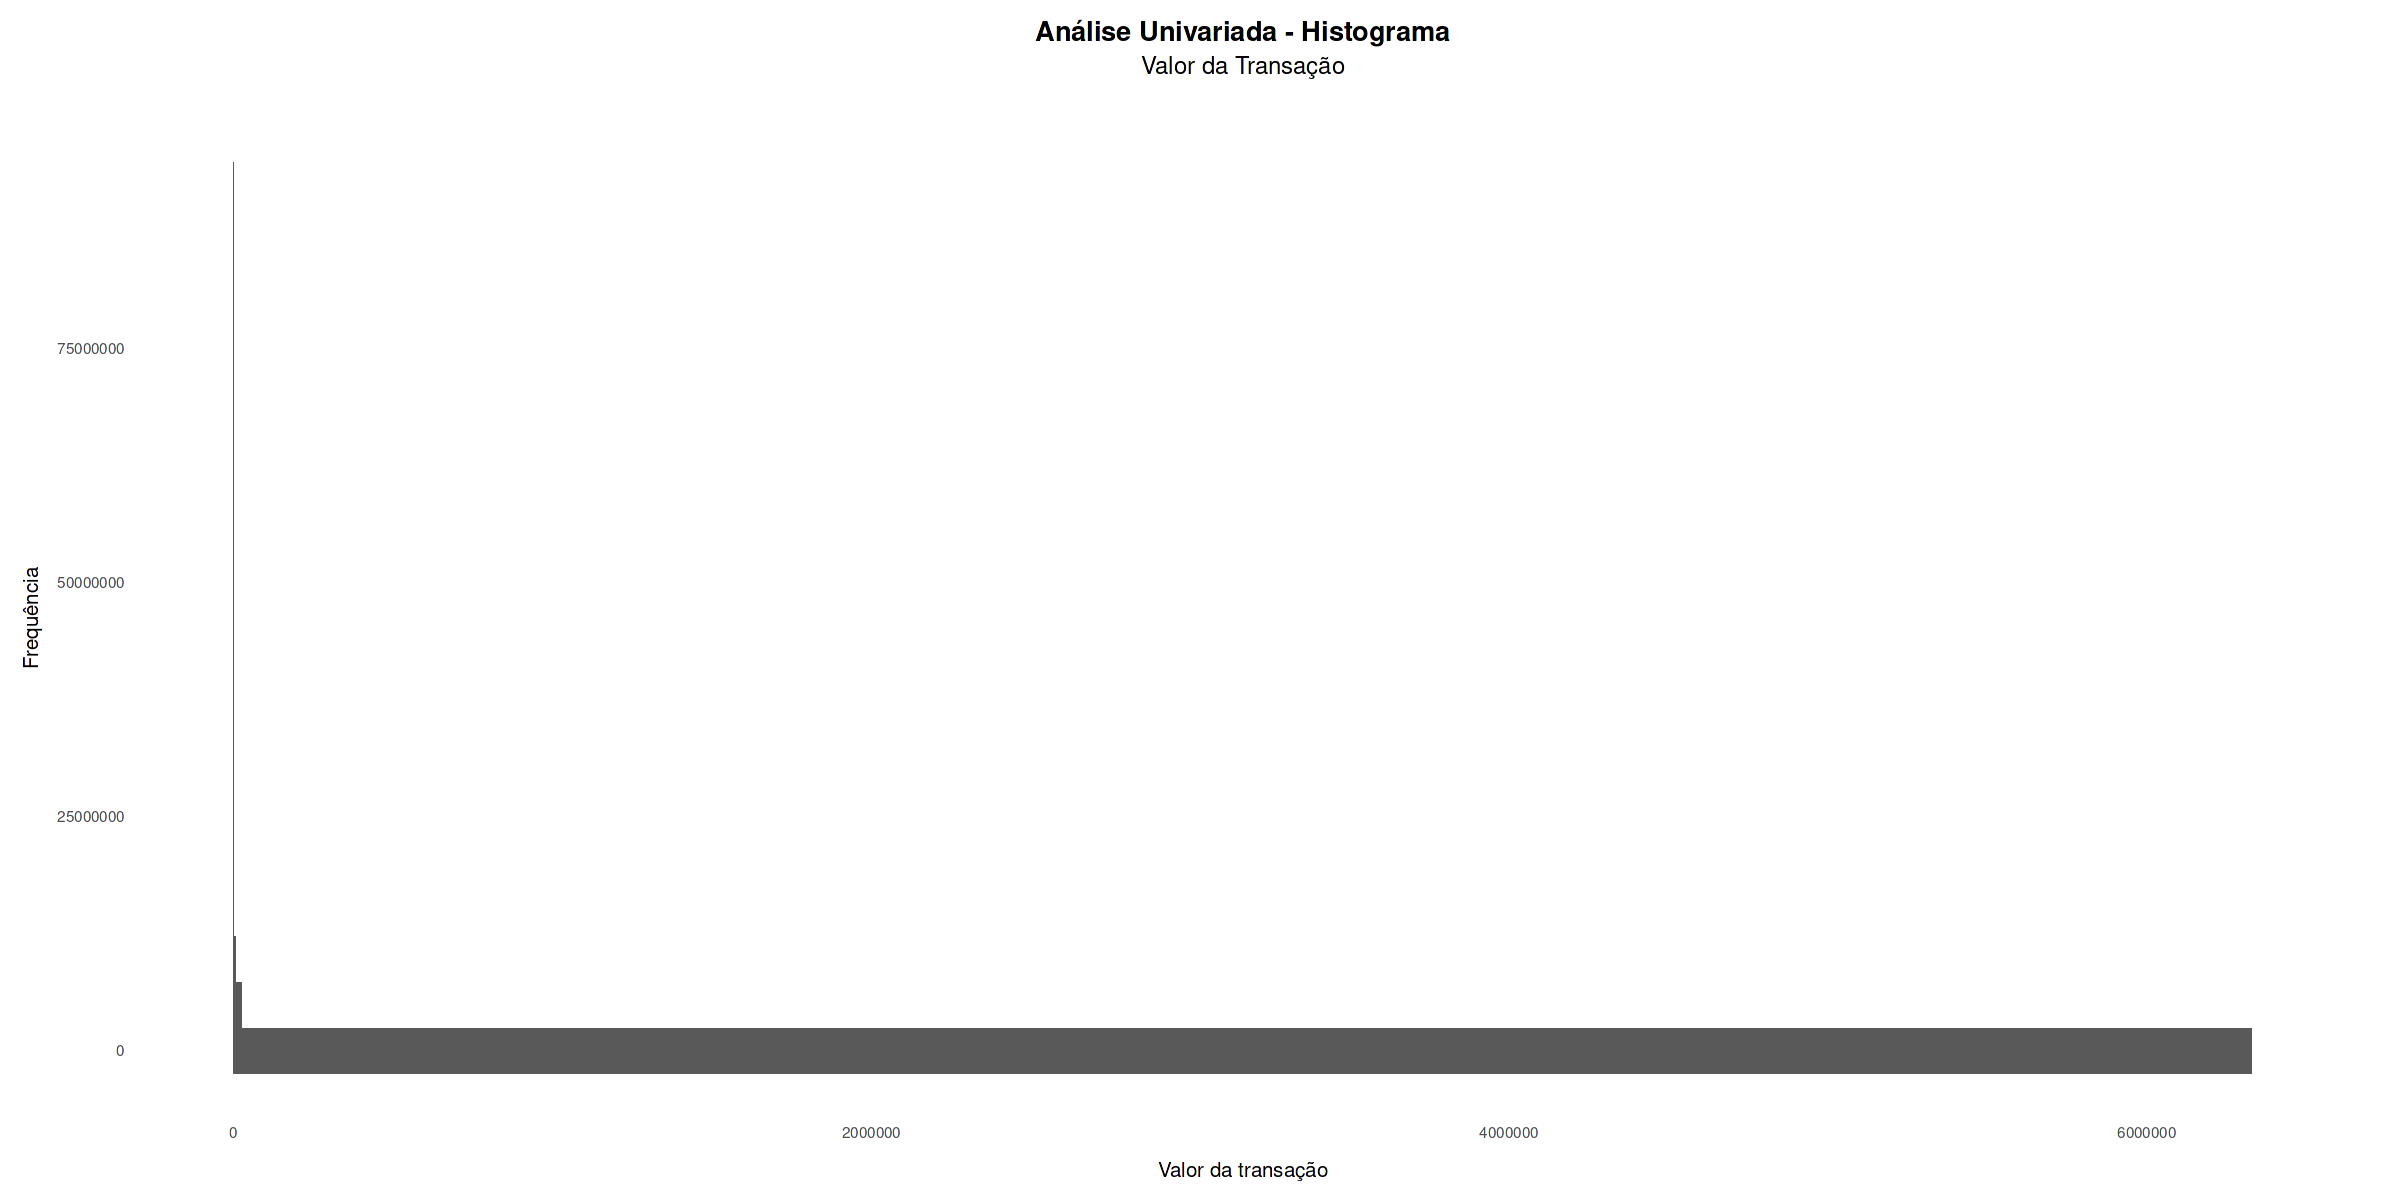

In [51]:
# Visualizando os valores das transações
ggplot(df1, aes(y = valor_transacao)) +
  geom_histogram(bins = 20) +
  scale_fill_manual(values = c("#102346")) +
  labs(
    x = 'Valor da transação',
    y = "Frequência",
    title = "Análise Univariada - Histograma",
    subtitle = "Valor da Transação"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

Sobre o histograma das transações:

*   Apresenta uma distribuição assimétrica, com uma cauda longa para a direita;
*   A maioria das transações estão concentradas em valores abaixo de 250.000;
*   Há um pequeno número de transações altas, acima de 1M



In [52]:
# Coeficiente de assimetria
sk <- skewness(df1$valor_transacao)
sk

[1] 30.994

-   sk <= 0 Assimetria negativa. A cauda esquerda é maior que a direita
-   sk = 0 Dados simétricos
-   sk >= 0 Assimetria positiva. A causa direita é maior que a esquerda

>Portanto: Para a variável `valor_transacao` SK > 0 (Assimetria Positiva), logo a cauda direita é maior que a esquerda.

In [53]:
# Coeficiente de Curtose
ck <- kurtosis(df1$valor_transacao)
ck

[1] 1798


-   ck <= 0 Cauda mais leve que a normal. Curtose Platicúrtica
-   ck = 0 Distribuição normal. Curtose Mesocúrtica
-   ck >= 0 Cauda mais pesada que a normal. Curtose Leptocúrtica

>Portanto: Para a variável `valor_transacao` ck > 0, logo a cauda mais pesada que a normal, chamada de Curose Leptocúrtica.

****
**Analisando a variável** `saldo_anterior_origem`:
Refere-se ao valor da transação efetuada

In [54]:
# Analisando o tipo da variável
str(df1$saldo_anterior_origem)

 num [1:6362620] 170136 21249 181 181 41554 ...


In [55]:
# Estatísticas descritivas básica
summary(df1$saldo_anterior_origem)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0        0    14208   833883   107315 59585040 

[1] "Moda: 59585040.37"

[1] "Mínimo: 0 | Máximo: 59585040.37"

[1] "Amplitude: 59585040.37"

[1] "Variância: 8341945738354.94"

[1] "Desvio Padrão: 2888242.67"

[1] "Coeficiente de Variação: 3.46"

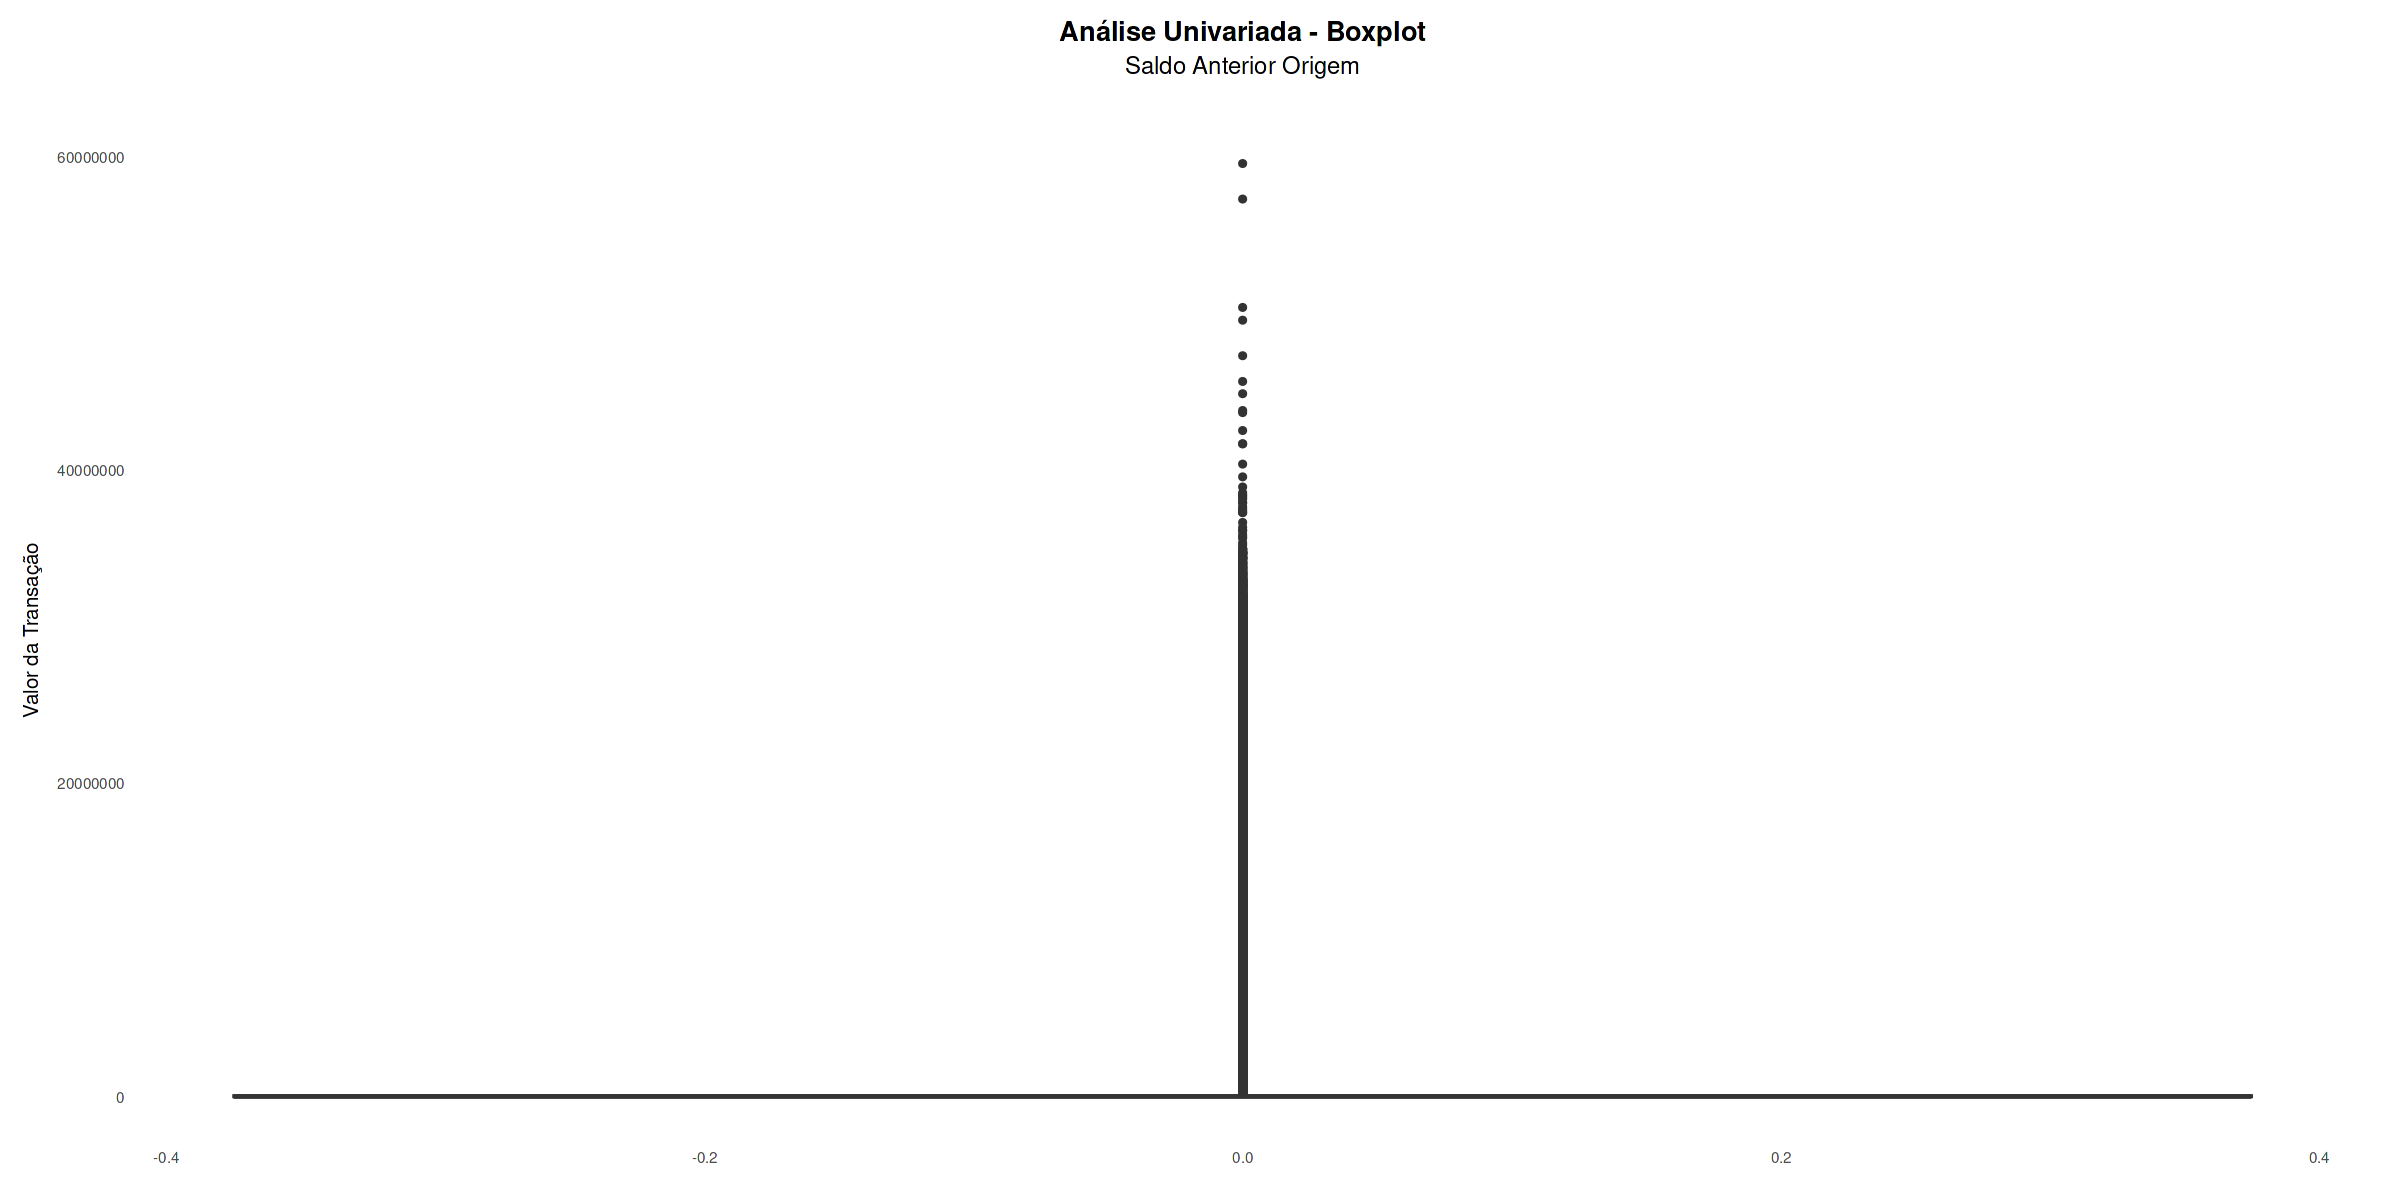

In [56]:
# Outras estatísticas# Visualizando os valores das transações
ggplot(df1, aes(y = saldo_anterior_origem)) +
  geom_boxplot() +
  scale_fill_manual(values = c("#102346")) +
  labs(
    y = "Valor da Transação",
    title = "Análise Univariada - Boxplot",
    subtitle = "Saldo Anterior Origem"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )
sprintf('Moda: %.2f',unique(df1[df1$saldo_anterior_origem == max(df1$saldo_anterior_origem),'saldo_anterior_origem']))
sprintf('Mínimo: %s | Máximo: %s', range(df1$saldo_anterior_origem)[1],range(df1$saldo_anterior_origem)[2])
sprintf('Amplitude: %s', diff(range(df1$saldo_anterior_origem)))
sprintf('Variância: %.2f', var(df1$saldo_anterior_origem))
sprintf('Desvio Padrão: %.2f', sd(df1$saldo_anterior_origem))
sprintf('Coeficiente de Variação: %.2f', sd(df1$saldo_anterior_origem)/mean(df1$saldo_anterior_origem))

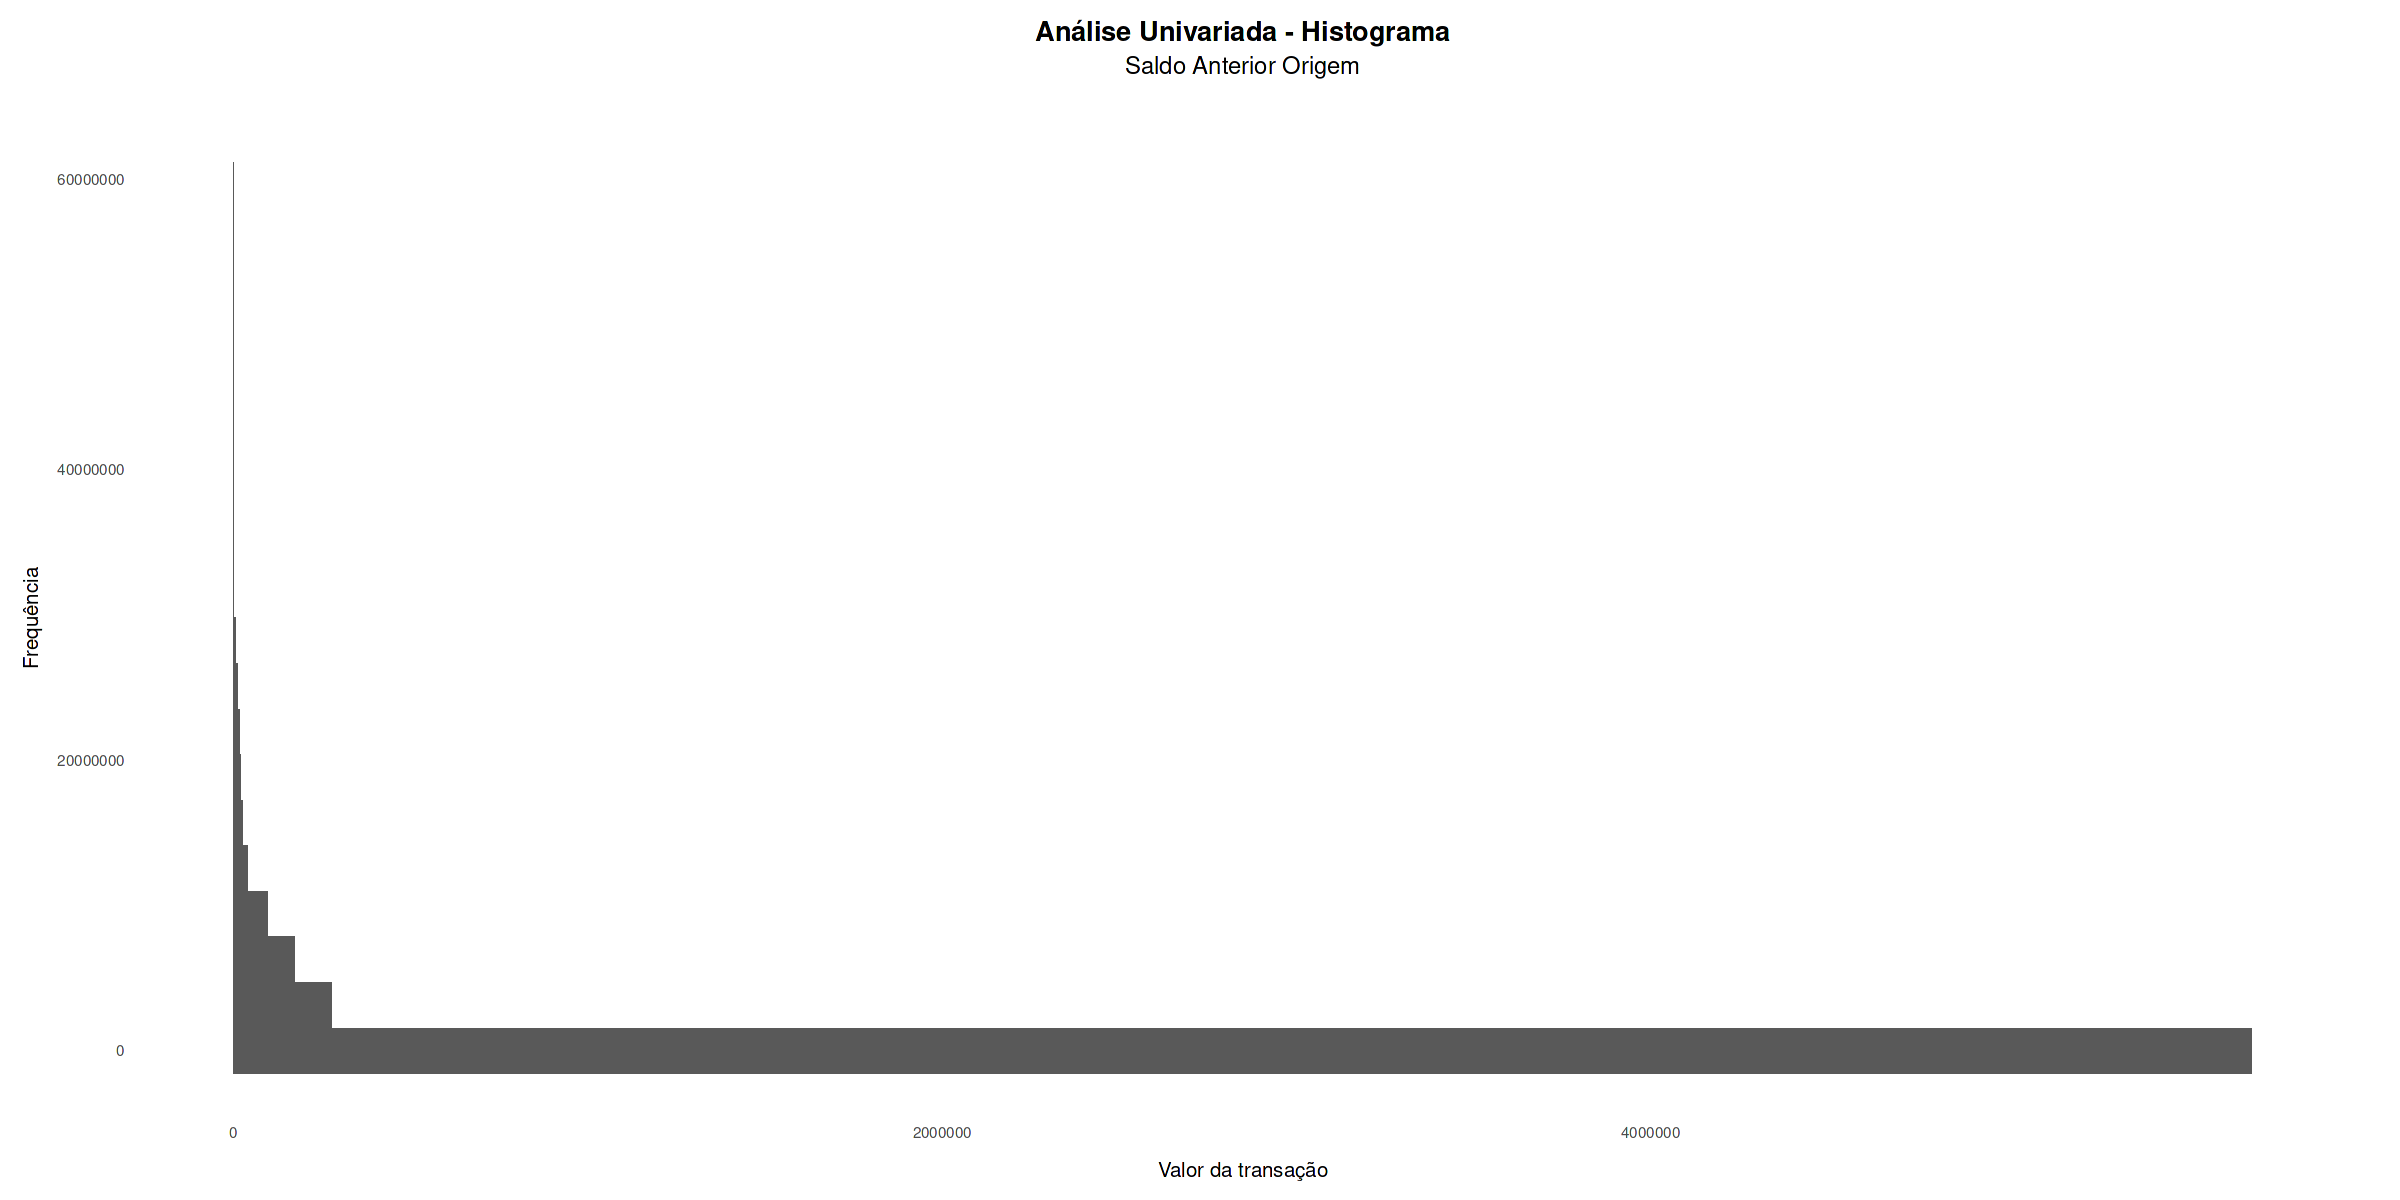

In [57]:
# Visualizando os valores das transações
ggplot(df1, aes(y = saldo_anterior_origem)) +
  geom_histogram(bins = 20) +
  scale_fill_manual(values = c("#102346")) +
  labs(
    x = 'Valor da transação',
    y = "Frequência",
    title = "Análise Univariada - Histograma",
    subtitle = "Saldo Anterior Origem"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

Sobre o histograma de `saldo_anterior_origem`:
- O histograma mostra que a maioria dos valores de saldo anterior de origem estão concentrados entre 0 e 10 milhões.
- Há uma pequena quantidade de valores acima de 10 milhões.
- O histograma é assimétrico à direita, o que indica que há mais valores altos do que valores baixos.
- A distribuição é leptocúrtica, o que indica que os valores são mais concentrados em torno da média do que em uma distribuição normal.

In [58]:
# Coeficiente de assimetria
sk <- skewness(df1$saldo_anterior_origem)
sk

[1] 5.2491

-   sk <= 0 Assimetria negativa. A cauda esquerda é maior que a direita
-   sk = 0 Dados simétricos
-   sk >= 0 Assimetria positiva. A causa direita é maior que a esquerda

>Portanto: Para a variável `saldo_anterior_origem` SK > 0 (Assimetria Positiva), logo a cauda direita é maior que a esquerda.

In [59]:
# Coeficiente de Curtose
ck <- kurtosis(df1$saldo_anterior_origem)
ck

[1] 32.965

-   ck <= 0 Cauda mais leve que a normal. Curtose Platicúrtica
-   ck = 0 Distribuição normal. Curtose Mesocúrtica
-   ck >= 0 Cauda mais pesada que a normal. Curtose Leptocúrtica

>Portanto: Para a variável `saldo_anterior_origem` ck > 0, logo a cauda mais pesada que a normal, chamada de Curose Leptocúrtica.

****
**Analisando a variável** `novo_saldo_origem`:
Refere-se ao valor da transação efetuada

In [60]:
# Analisando o tipo da variável
str(df1$novo_saldo_origem)

 num [1:6362620] 160296 19385 0 0 29886 ...


In [61]:
# Estatísticas descritivas básica
summary(df1$novo_saldo_origem)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0        0        0   855114   144258 49585040 

In [62]:
# Outras estatísticas
sprintf('Moda: %.2f',unique(df1[df1$novo_saldo_origem == max(df1$novo_saldo_origem),'novo_saldo_origem']))
sprintf('Mínimo: %s | Máximo: %s', range(df1$novo_saldo_origem)[1],range(df1$novo_saldo_origem)[2])
sprintf('Amplitude: %s', diff(range(df1$novo_saldo_origem)))
sprintf('Variância: %.2f', var(df1$novo_saldo_origem))
sprintf('Desvio Padrão: %.2f', sd(df1$novo_saldo_origem))
sprintf('Coeficiente de Variação: %.2f', sd(df1$novo_saldo_origem)/mean(df1$novo_saldo_origem))

[1] "Moda: 49585040.37"

[1] "Mínimo: 0 | Máximo: 49585040.37"

[1] "Amplitude: 49585040.37"

[1] "Variância: 8550059647628.73"

[1] "Desvio Padrão: 2924048.50"

[1] "Coeficiente de Variação: 3.42"

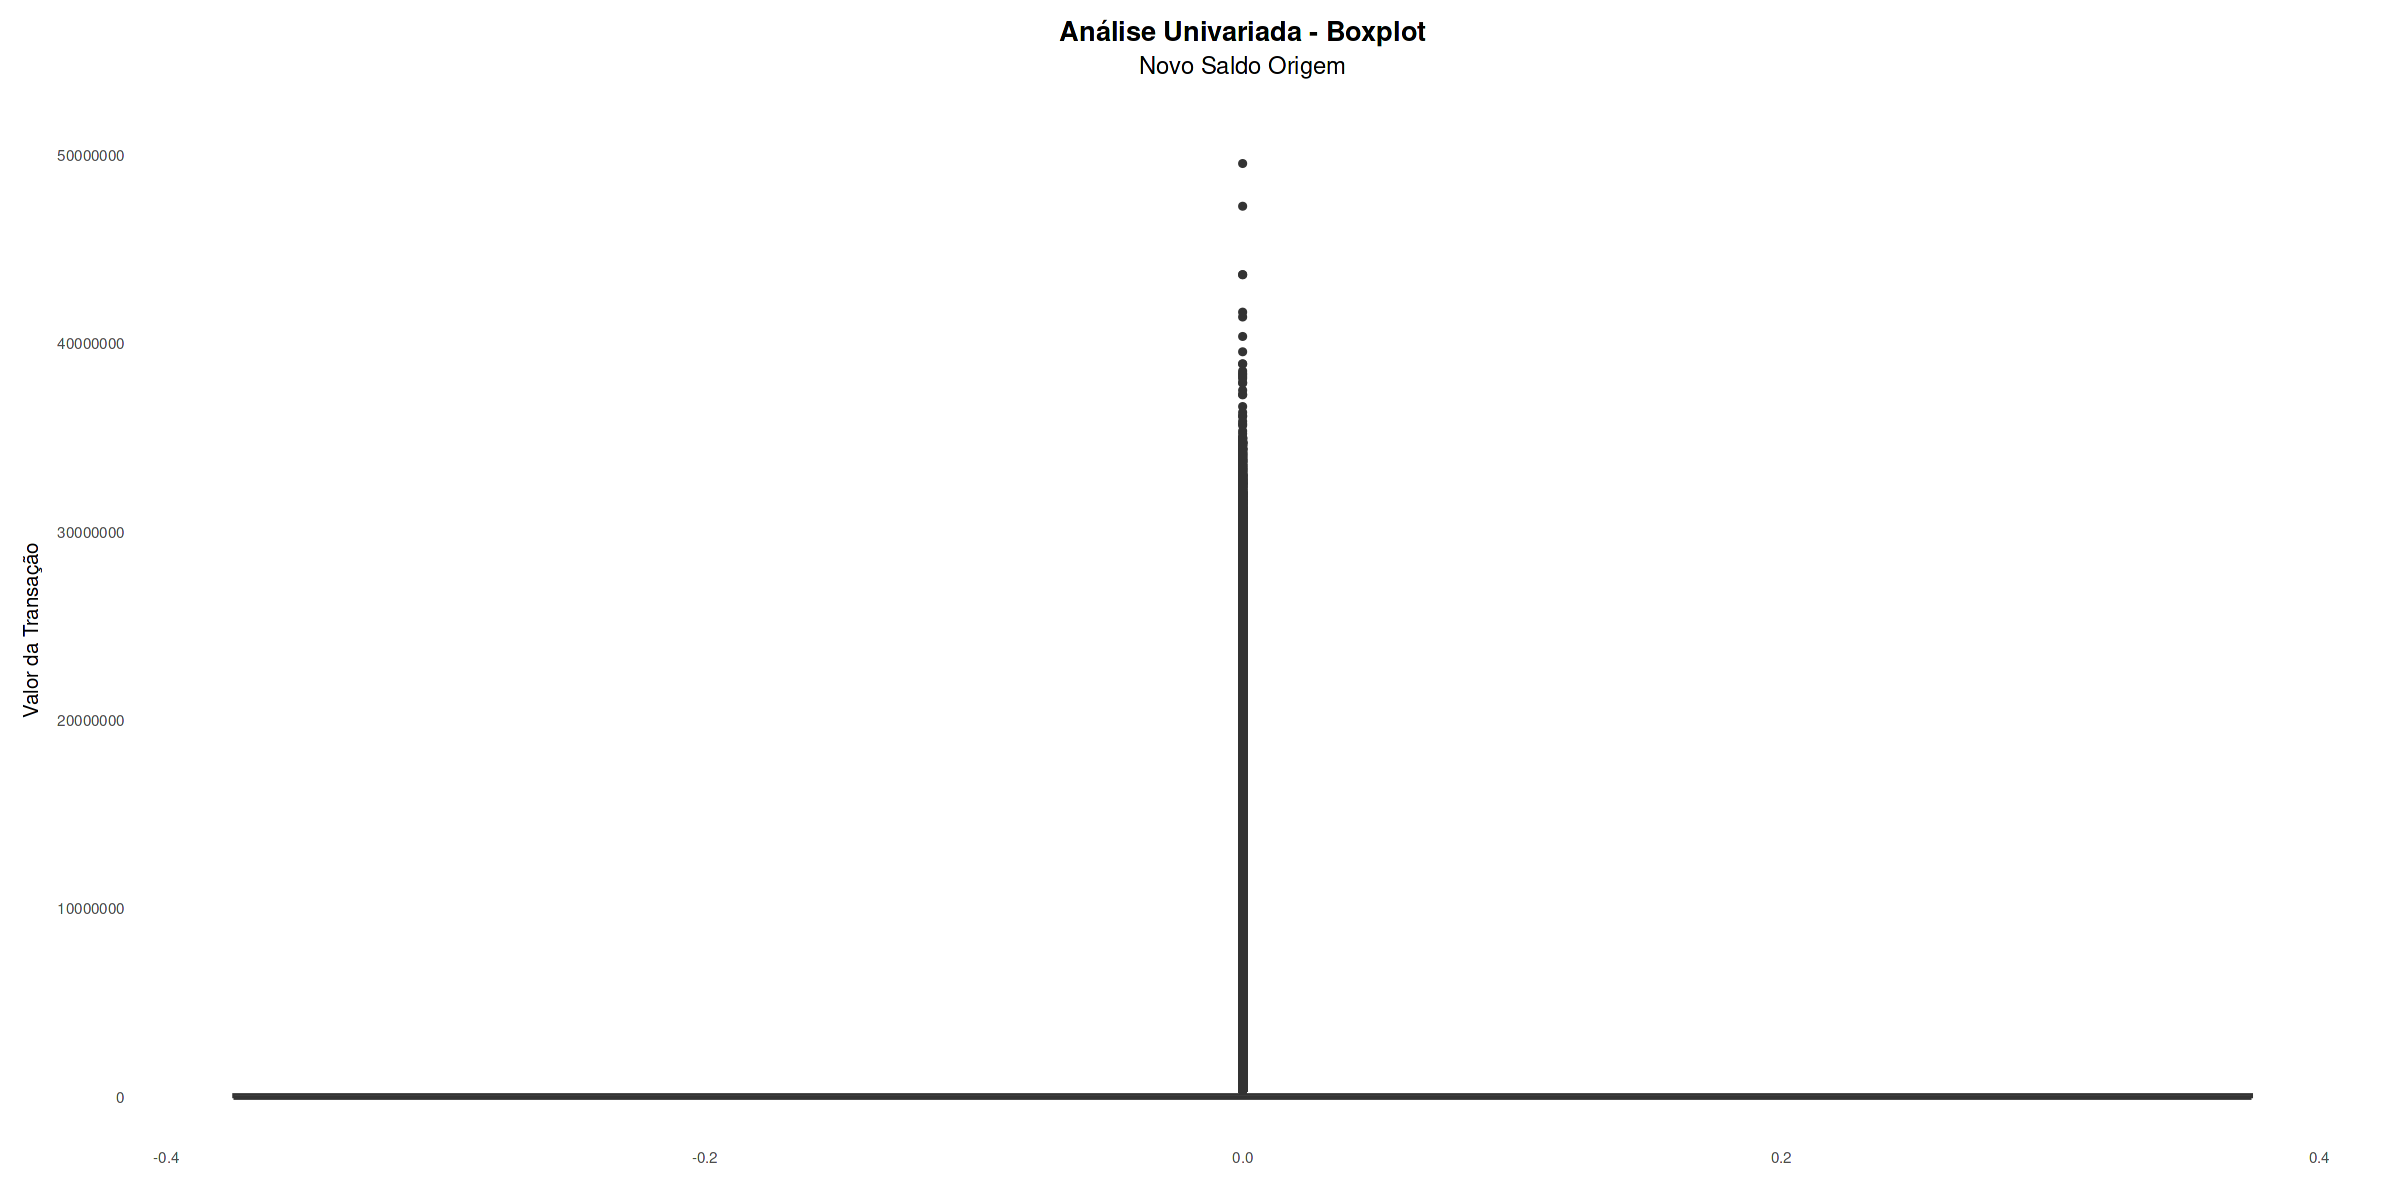

In [63]:
# Visualizando os valores das transações
ggplot(df1, aes(y = novo_saldo_origem)) +
  geom_boxplot() +
  scale_fill_manual(values = c("#102346")) +
  labs(
    y = "Valor da Transação",
    title = "Análise Univariada - Boxplot",
    subtitle = "Novo Saldo Origem"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

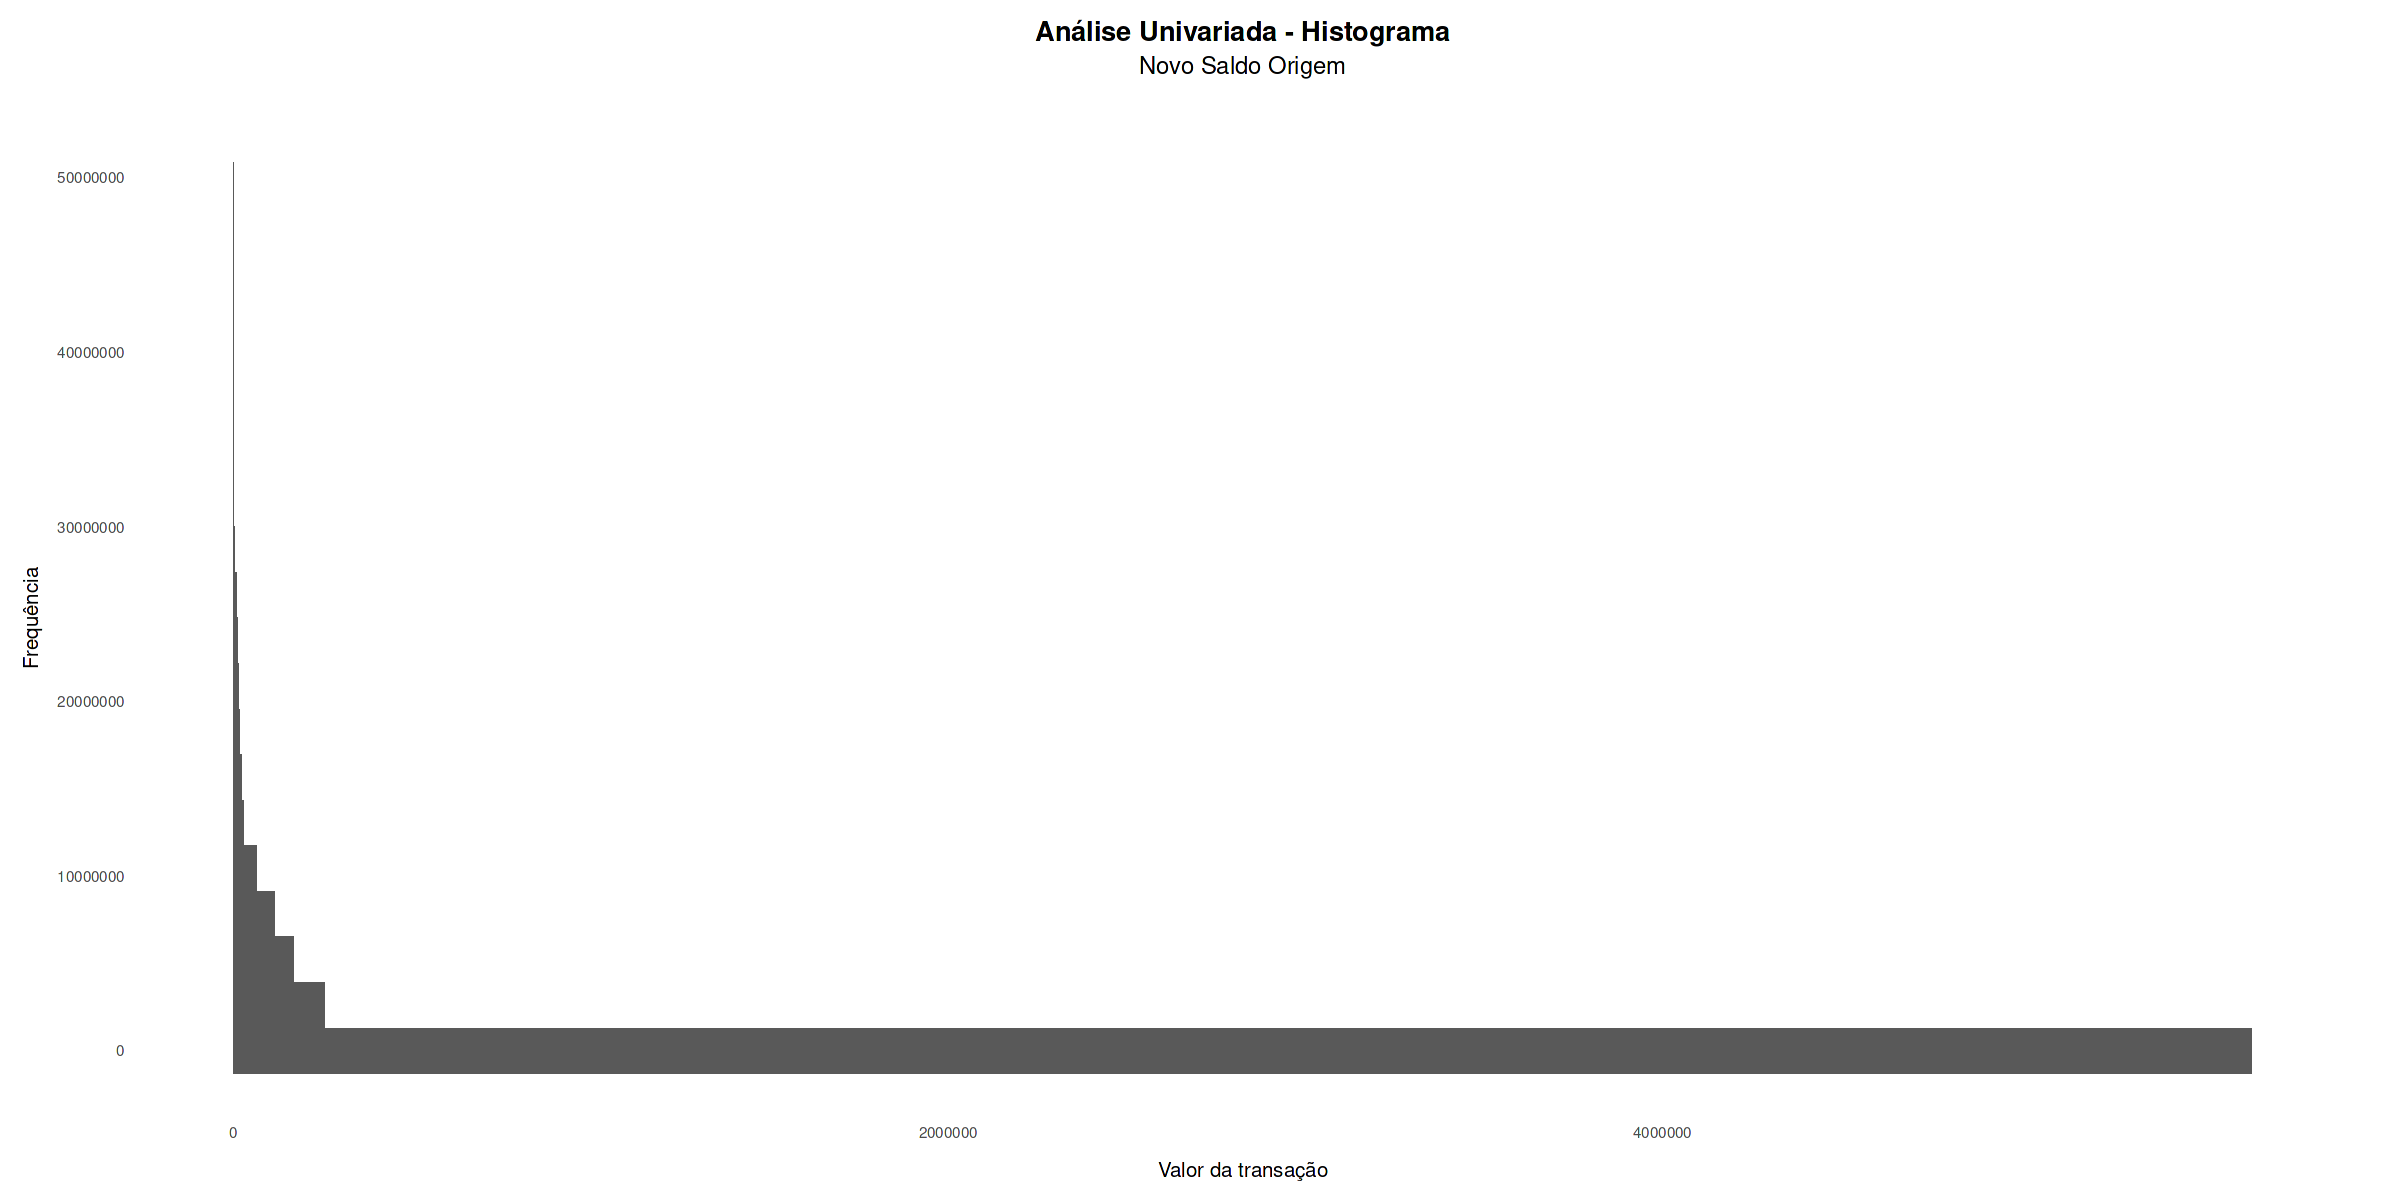

In [64]:
# Visualizando os valores das transações
ggplot(df1, aes(y = novo_saldo_origem)) +
  geom_histogram(bins = 20) +
  scale_fill_manual(values = c("#102346")) +
  labs(
    x = 'Valor da transação',
    y = "Frequência",
    title = "Análise Univariada - Histograma",
    subtitle = "Novo Saldo Origem"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

Sobre o histograma de `novo_saldo_origem`:
- O histograma mostra que a maioria dos valores de saldo anterior de origem estão concentrados entre 0 e 10 milhões.
- Há uma pequena quantidade de valores acima de 10 milhões.
- O histograma é assimétrico à direita, o que indica que há mais valores altos do que valores baixos.
- A distribuição é leptocúrtica, o que indica que os valores são mais concentrados em torno da média do que em uma distribuição normal.

In [65]:
# Coeficiente de assimetria
sk <- skewness(df1$novo_saldo_origem)
sk

[1] 5.1769

sk <= 0 Assimetria negativa. A cauda esquerda é maior que a direita
sk = 0 Dados simétricos
sk >= 0 Assimetria positiva. A causa direita é maior que a esquerda
Portanto: Para a variável novo_saldo_origem SK > 0 (Assimetria Positiva), logo a cauda direita é maior que a esquerda.

In [66]:
# Coeficiente de Curtose
ck <- kurtosis(df1$novo_saldo_origem)
ck

[1] 32.067

****
## 1.2. Análise Bivariadas

Classificar a variável em relação ao seu tipo qualitativa (nominal ou ordinal) ou quantitativa (discreta ou contínua), obter tabelas e gráficos ou medidas que resumam a variável.

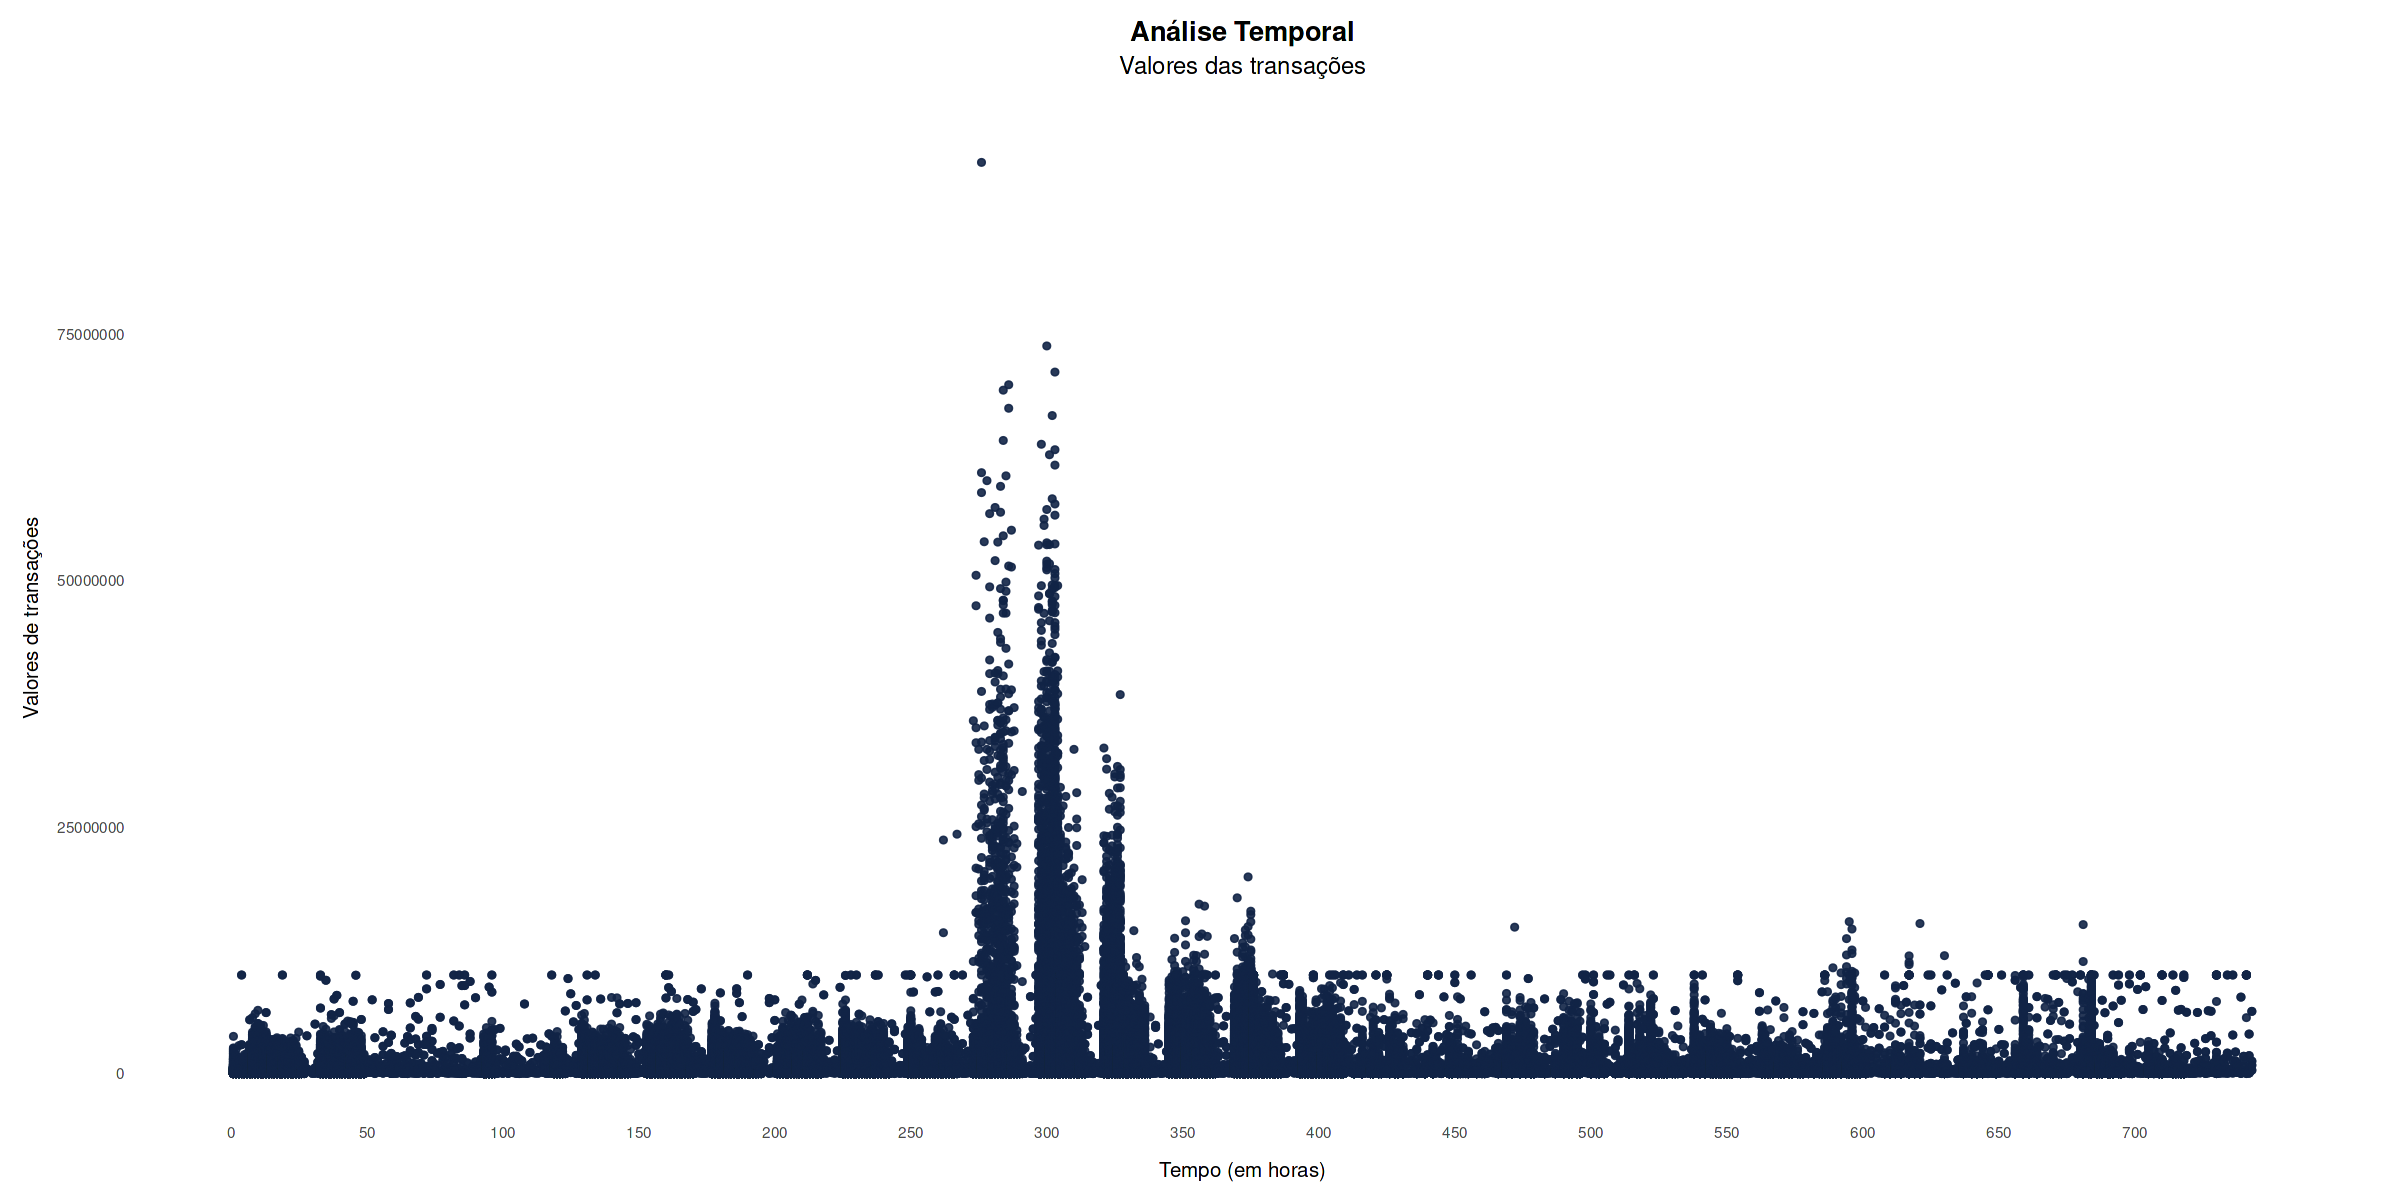

In [67]:
# Grafico de tempo(horas) x valor de transacao
ggplot(df1) +
  aes(x = tempo, y = valor_transacao) +
  geom_point(shape = "circle", size = 1.5, colour = "#112446", alpha = 0.9) +
  labs(
    x = "Tempo (em horas)",
    y = "Valores de transações",
    title = "Análise Temporal",
    subtitle = "Valores das transações"
  ) +
  scale_x_continuous(breaks = seq(0, max(df1$tempo), by = 50)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

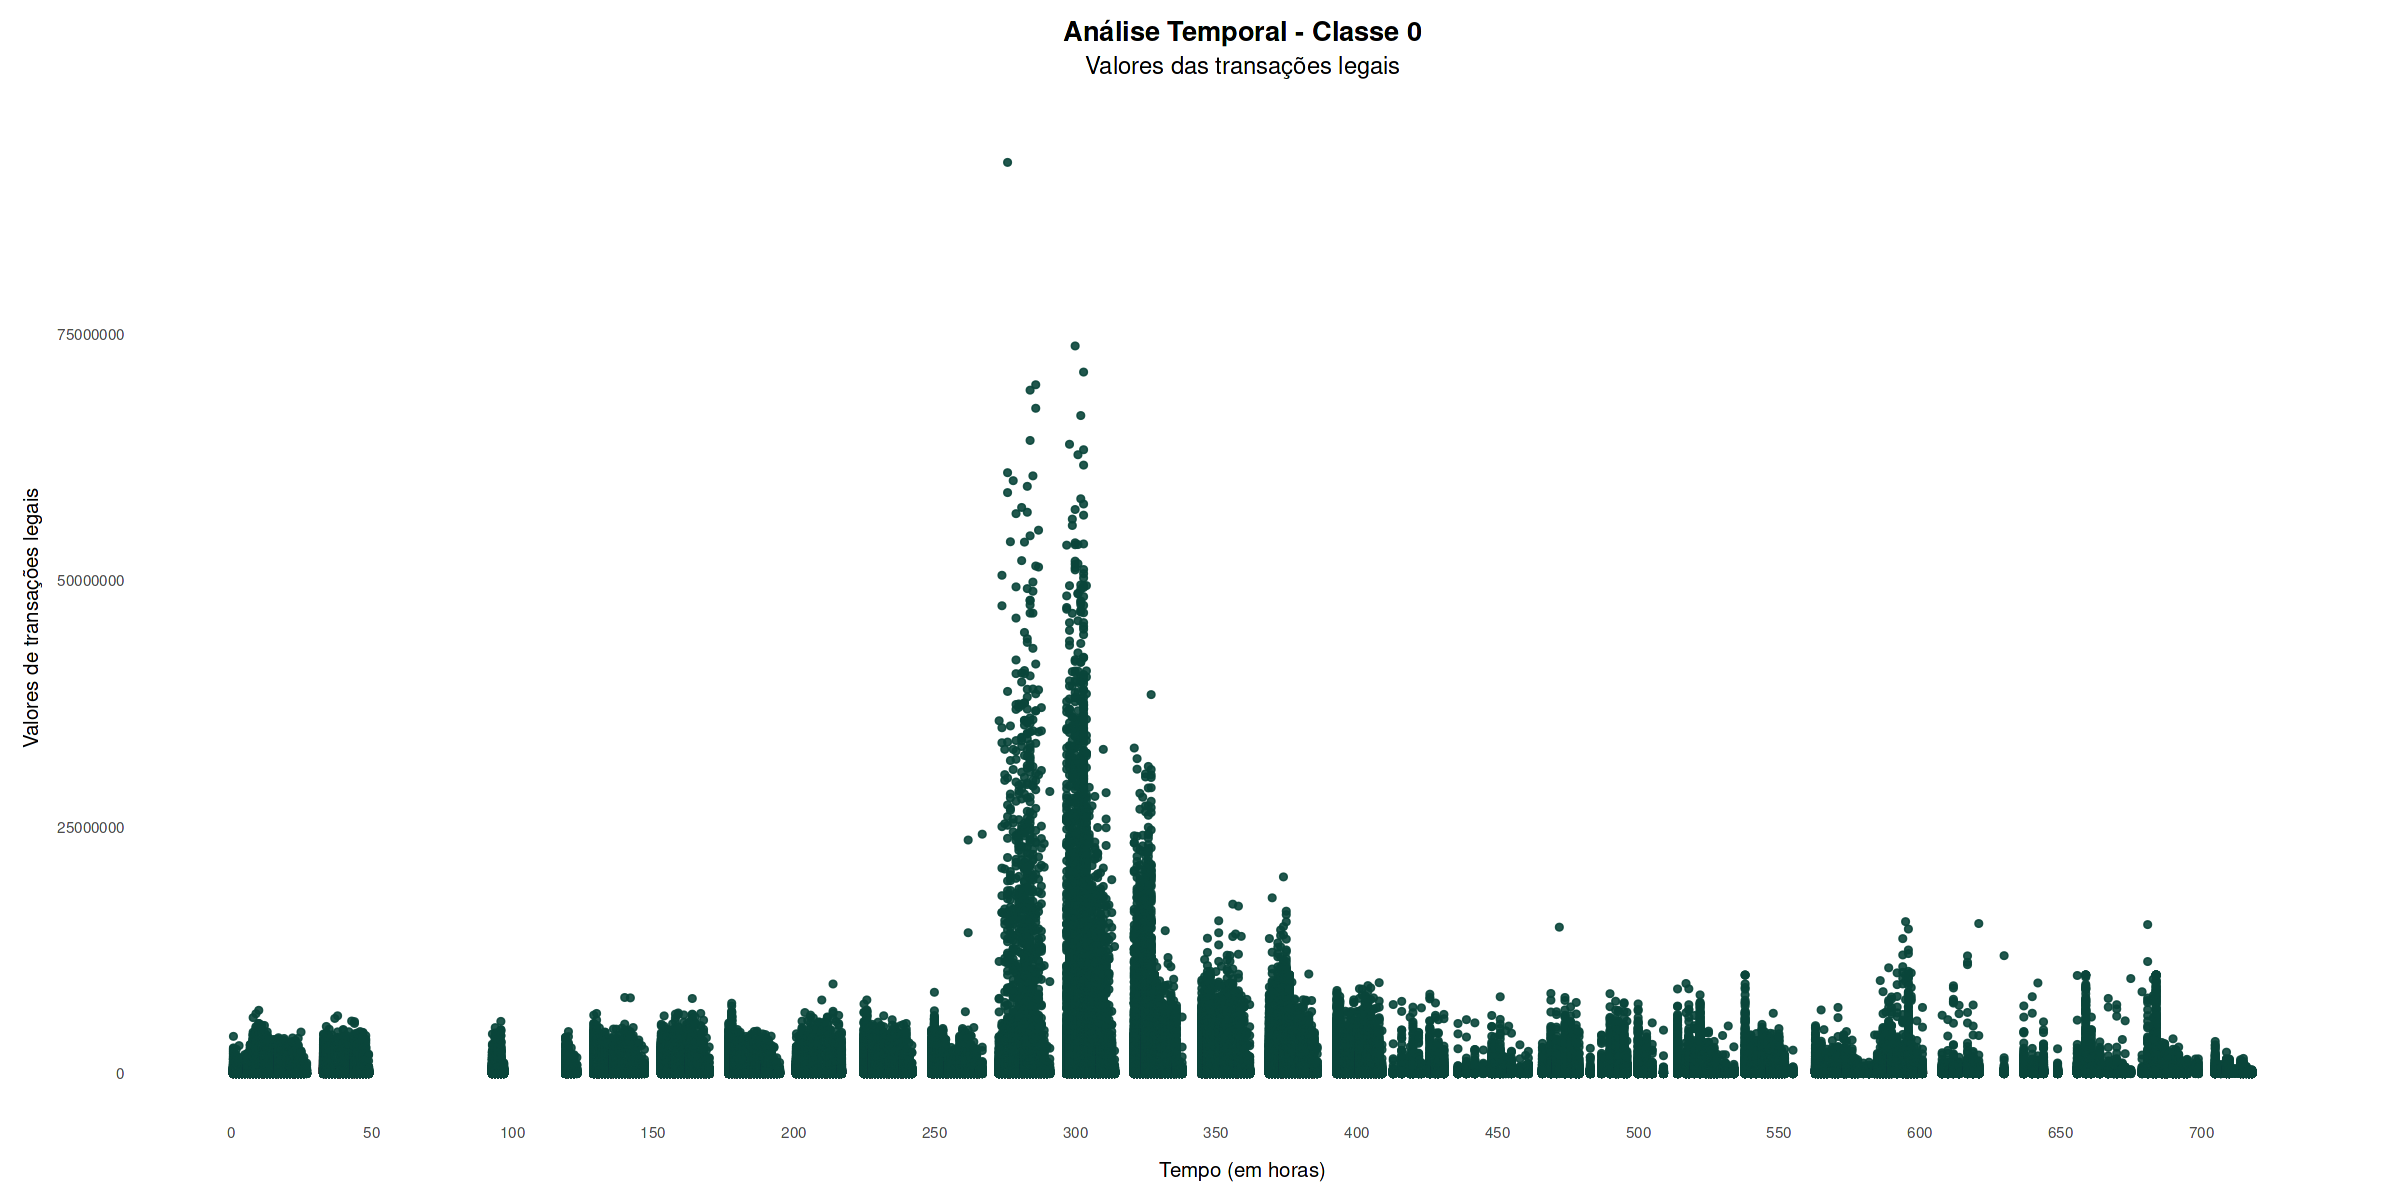

In [68]:
# Grafico de tempo(horas) x classe 0
ggplot(df1[df1$isfraude == 0,]) +
  aes(x = tempo, y = valor_transacao) +
  geom_point(shape = "circle", size = 1.5, colour = "#09453a", alpha = 0.9) +
  labs(
    x = "Tempo (em horas)",
    y = "Valores de transações legais",
    title = "Análise Temporal - Classe 0",
    subtitle = "Valores das transações legais"
  ) +
  scale_x_continuous(breaks = seq(0, max(df1$tempo), by = 50)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

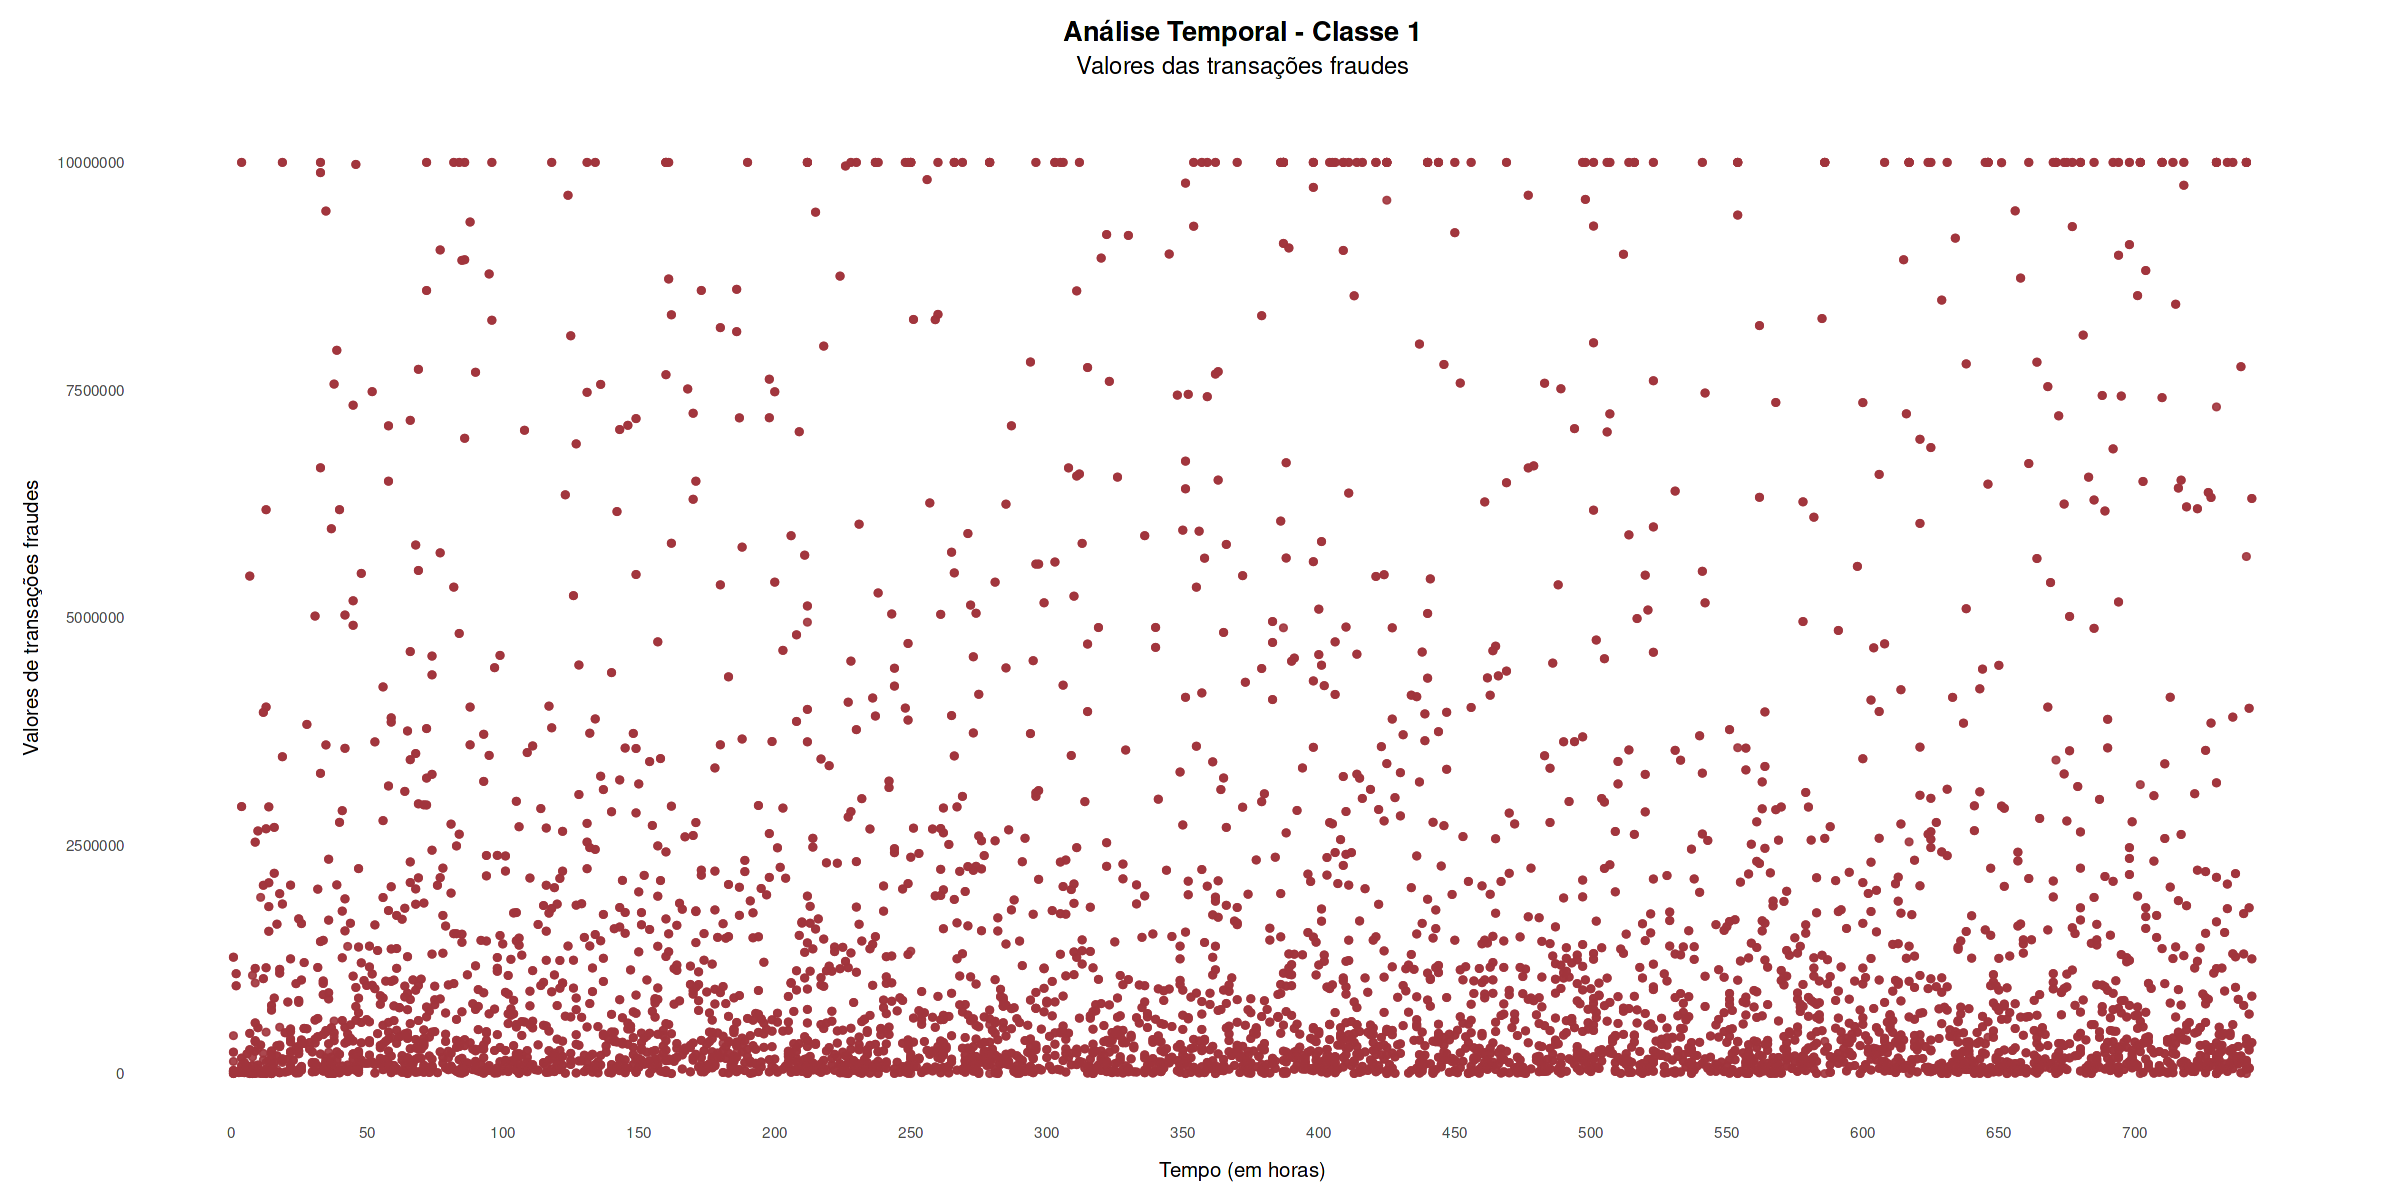

In [69]:
# Grafico de tempo(horas) x classe 1
ggplot(df1[df1$isfraude == 1,]) +
  aes(x = tempo, y = valor_transacao) +
  geom_point(shape = "circle", size = 1.5, colour = "#a1343c", alpha = 0.9) +
  labs(
    x = "Tempo (em horas)",
    y = "Valores de transações fraudes",
    title = "Análise Temporal - Classe 1",
    subtitle = "Valores das transações fraudes"
  ) +
  scale_x_continuous(breaks = seq(0, max(df1$tempo), by = 50)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

In [70]:
# Verificando a quantidade de fraudes por tempo
df_tempo <- df1 %>%
          group_by(tempo, isfraude) %>%
          summarise(quantidade = n())
head(df_tempo,5)

tempo,isfraude,quantidade
<dbl>,<fct>,<int>
1,0,2692
1,1,16
2,0,1006
2,1,8
3,0,548


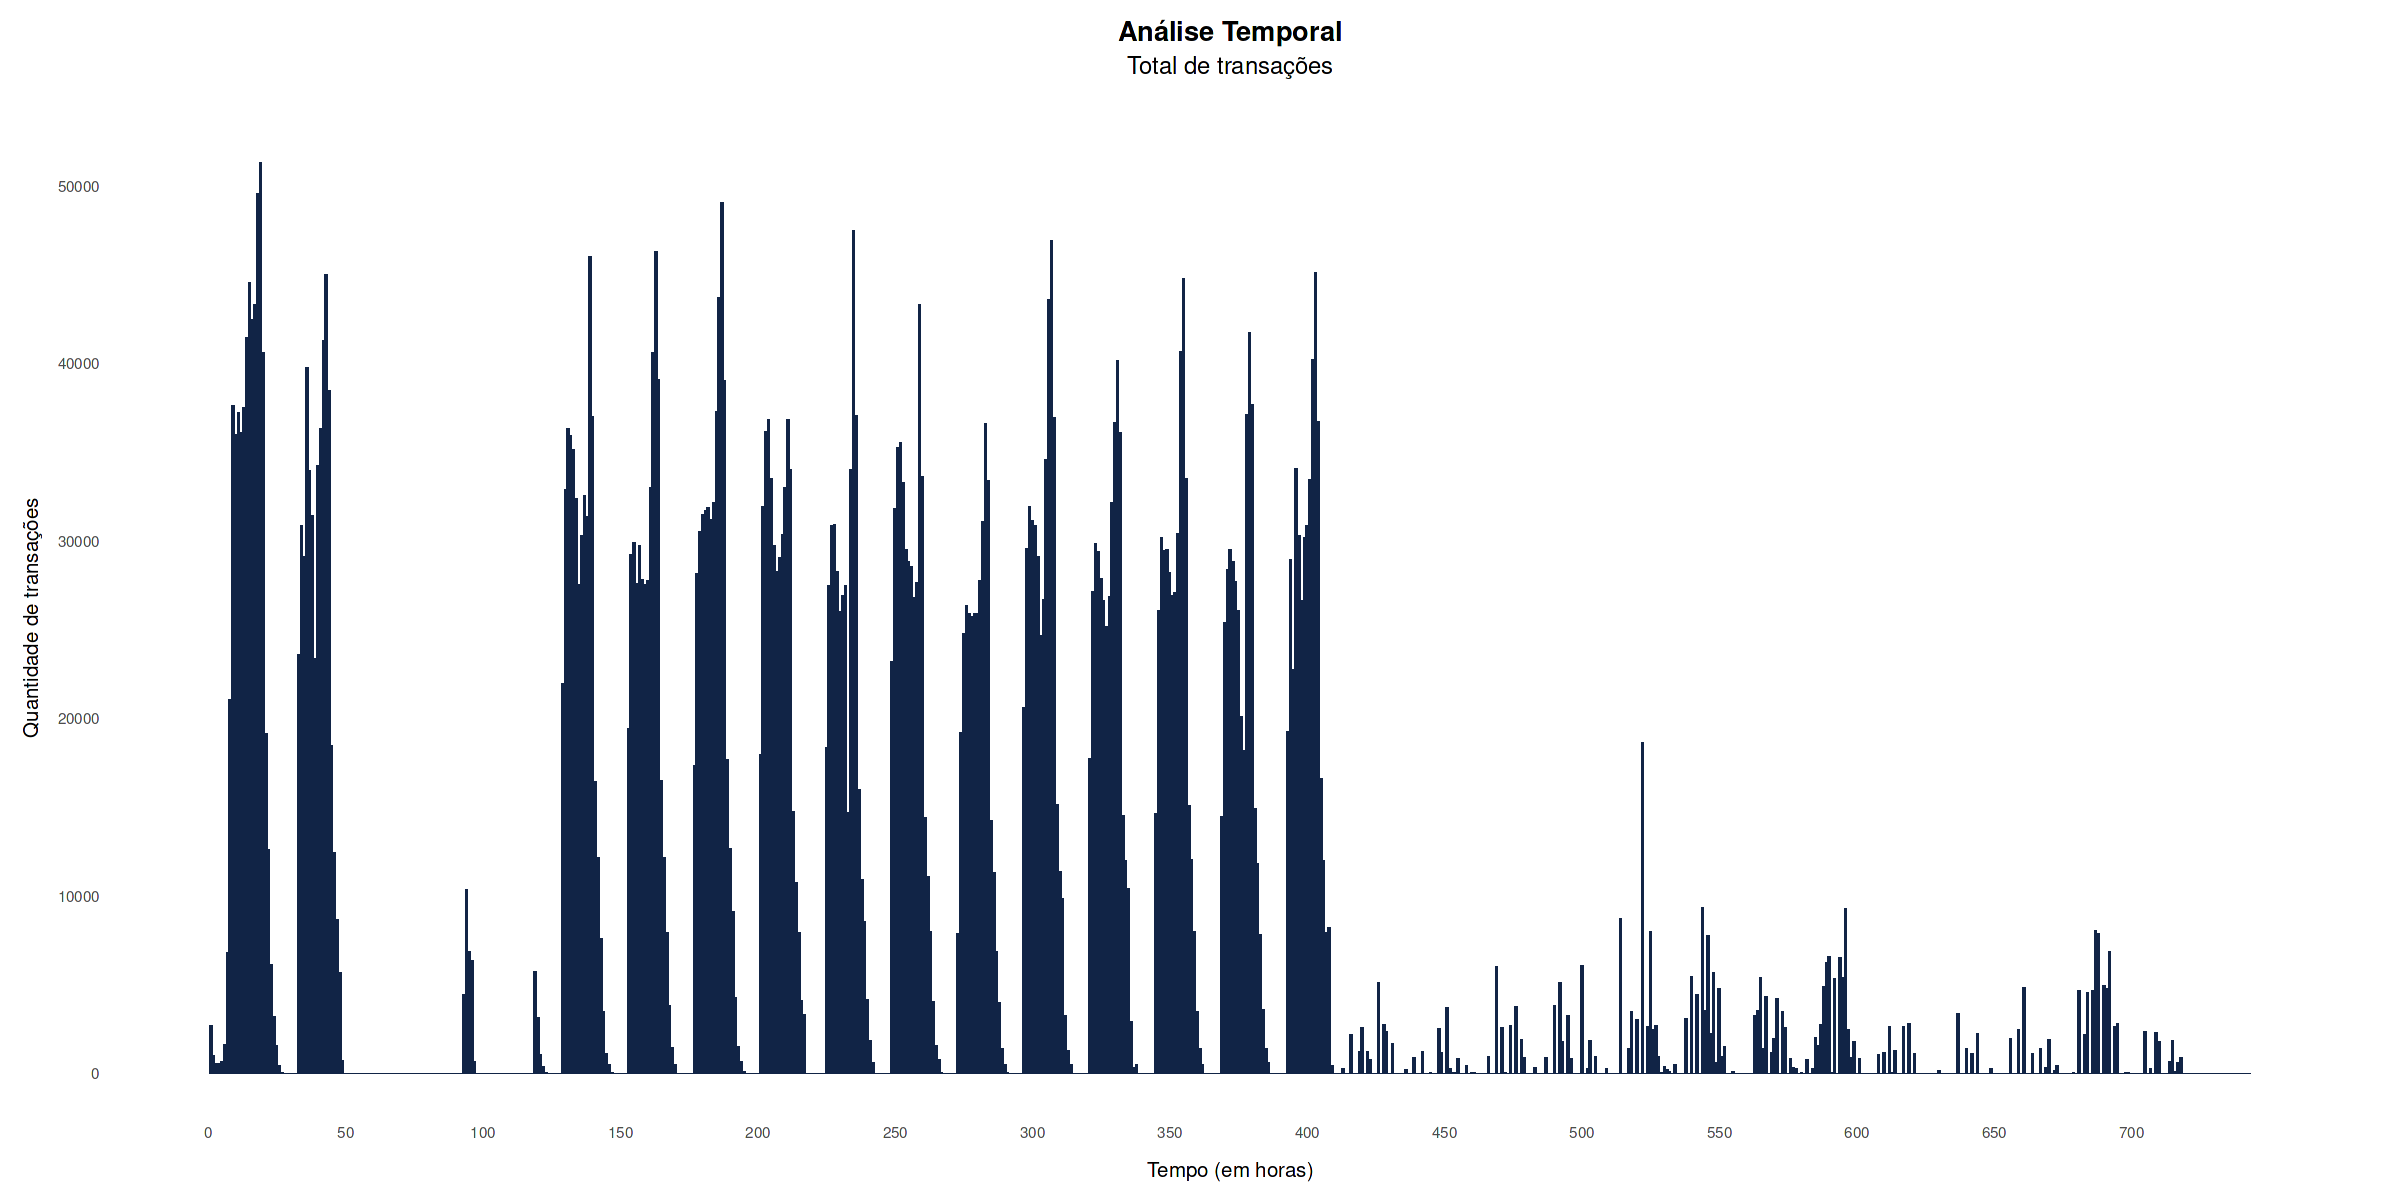

In [71]:
# Quantidade de transações
ggplot(df_tempo) +
  aes(x = tempo, y = quantidade) +
  geom_bar(stat = "identity", fill='#112446') +
  labs(
    x = "Tempo (em horas)",
    y = "Quantidade de transações",
    title = "Análise Temporal",
    subtitle = "Total de transações"
  ) +
  scale_y_continuous(breaks = seq(0, max(df_tempo$quantidade), by = 10000)) +
  scale_x_continuous(breaks = seq(0, max(df1$tempo), by = 50)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

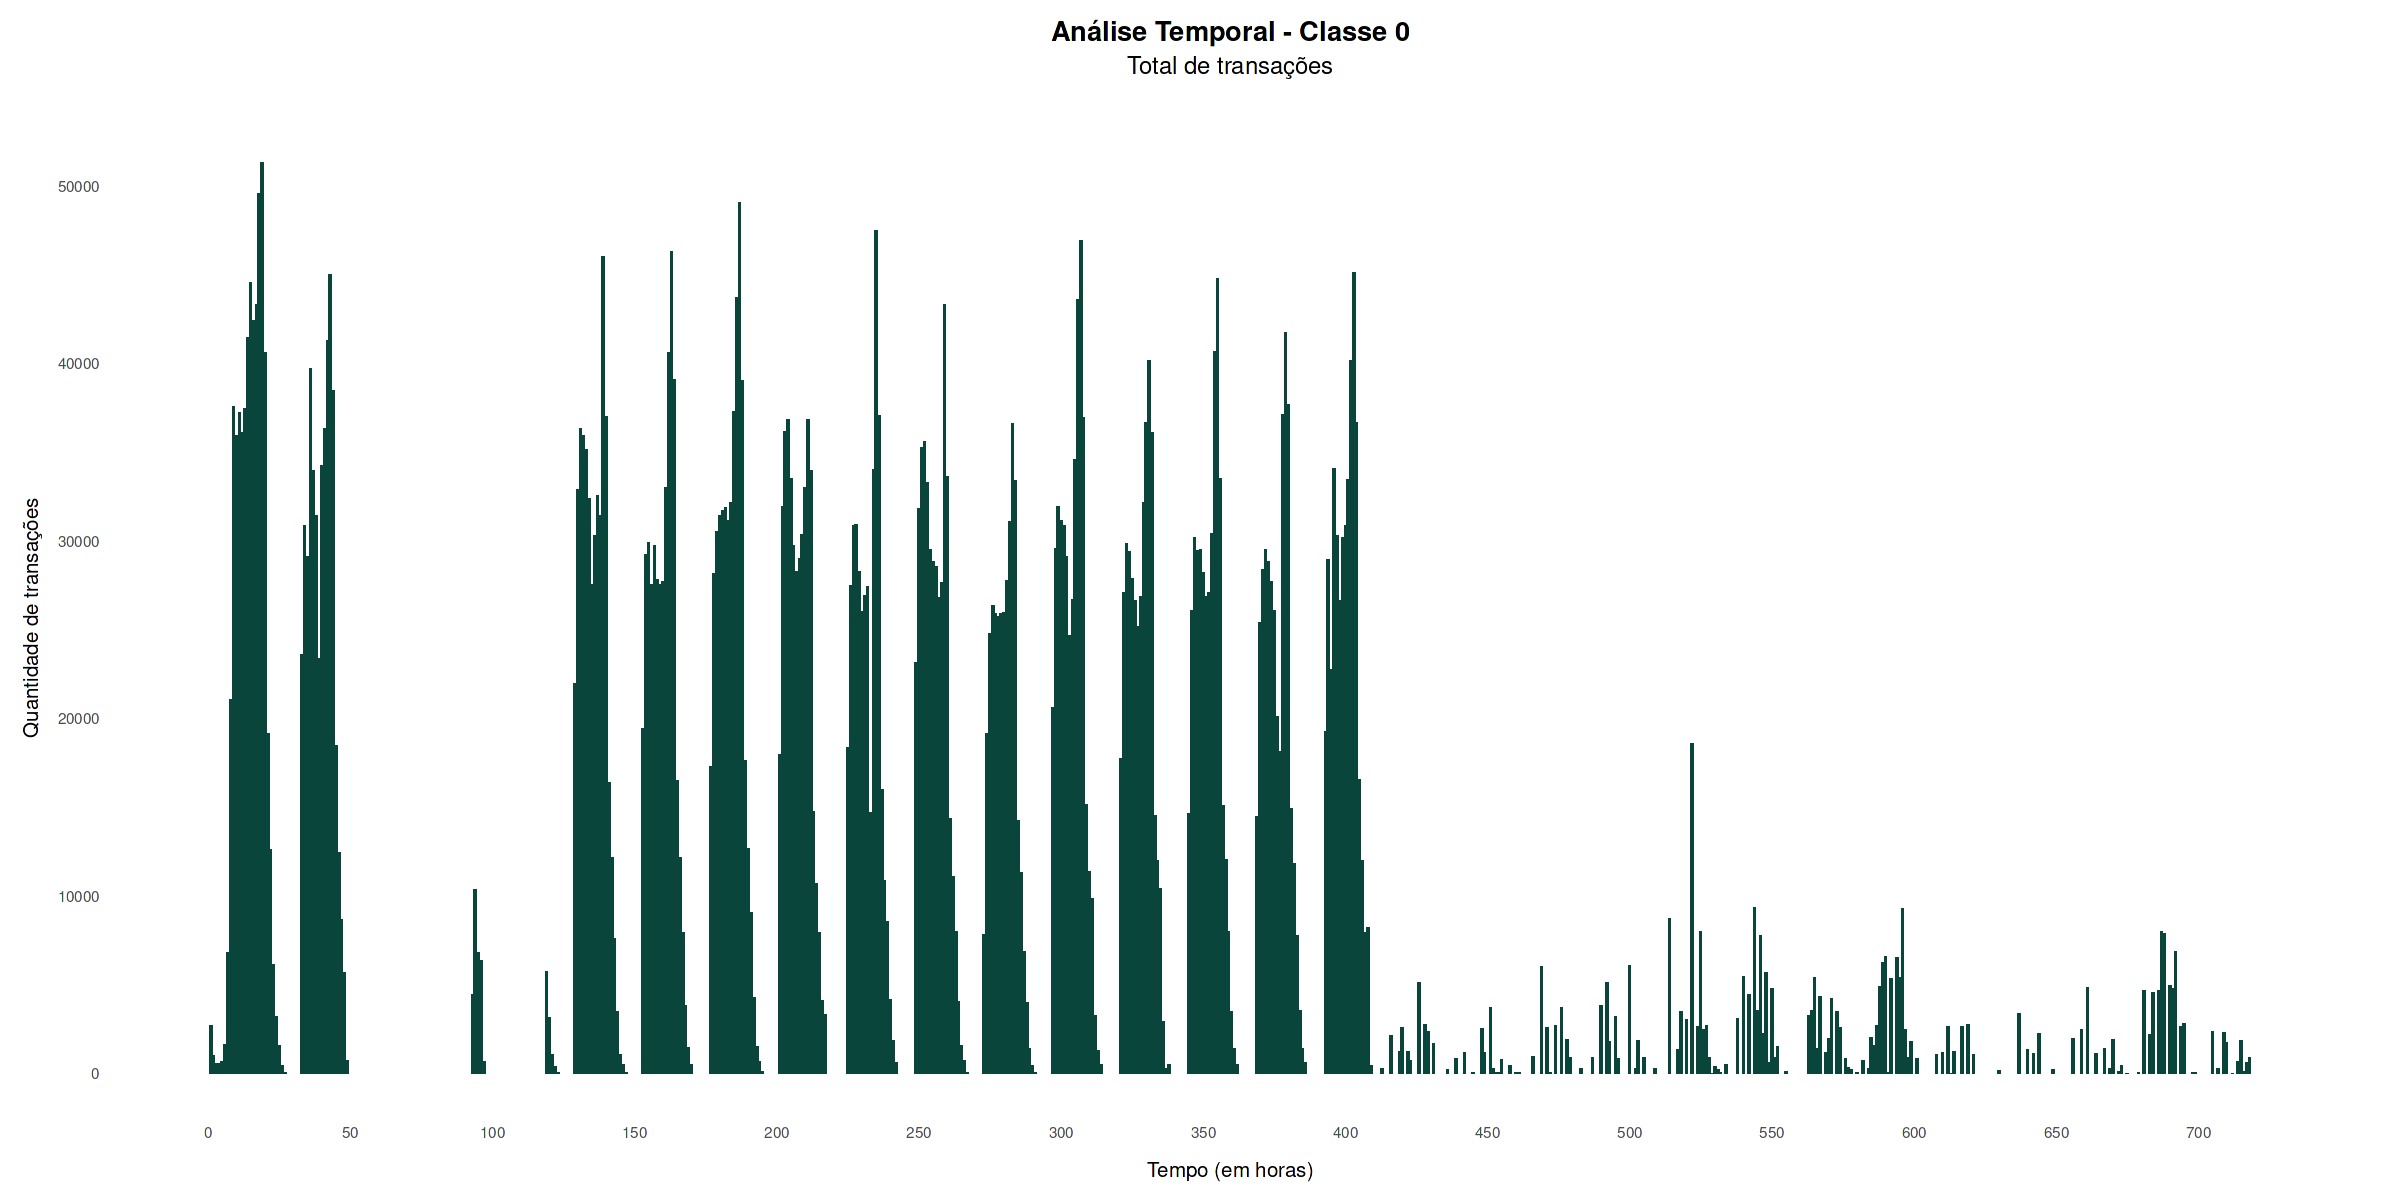

In [72]:
# Quantidade de transações da classe 0
ggplot(df_tempo[df_tempo$isfraude == 0,]) +
  aes(x = tempo, y = quantidade) +
  geom_bar(stat = "identity", fill='#09453a') +
  labs(
    x = "Tempo (em horas)",
    y = "Quantidade de transações",
    title = "Análise Temporal - Classe 0",
    subtitle = "Total de transações"
  ) +
  scale_y_continuous(breaks = seq(0, max(df_tempo$quantidade), by = 10000)) +
  scale_x_continuous(breaks = seq(0, max(df1$tempo), by = 50)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )


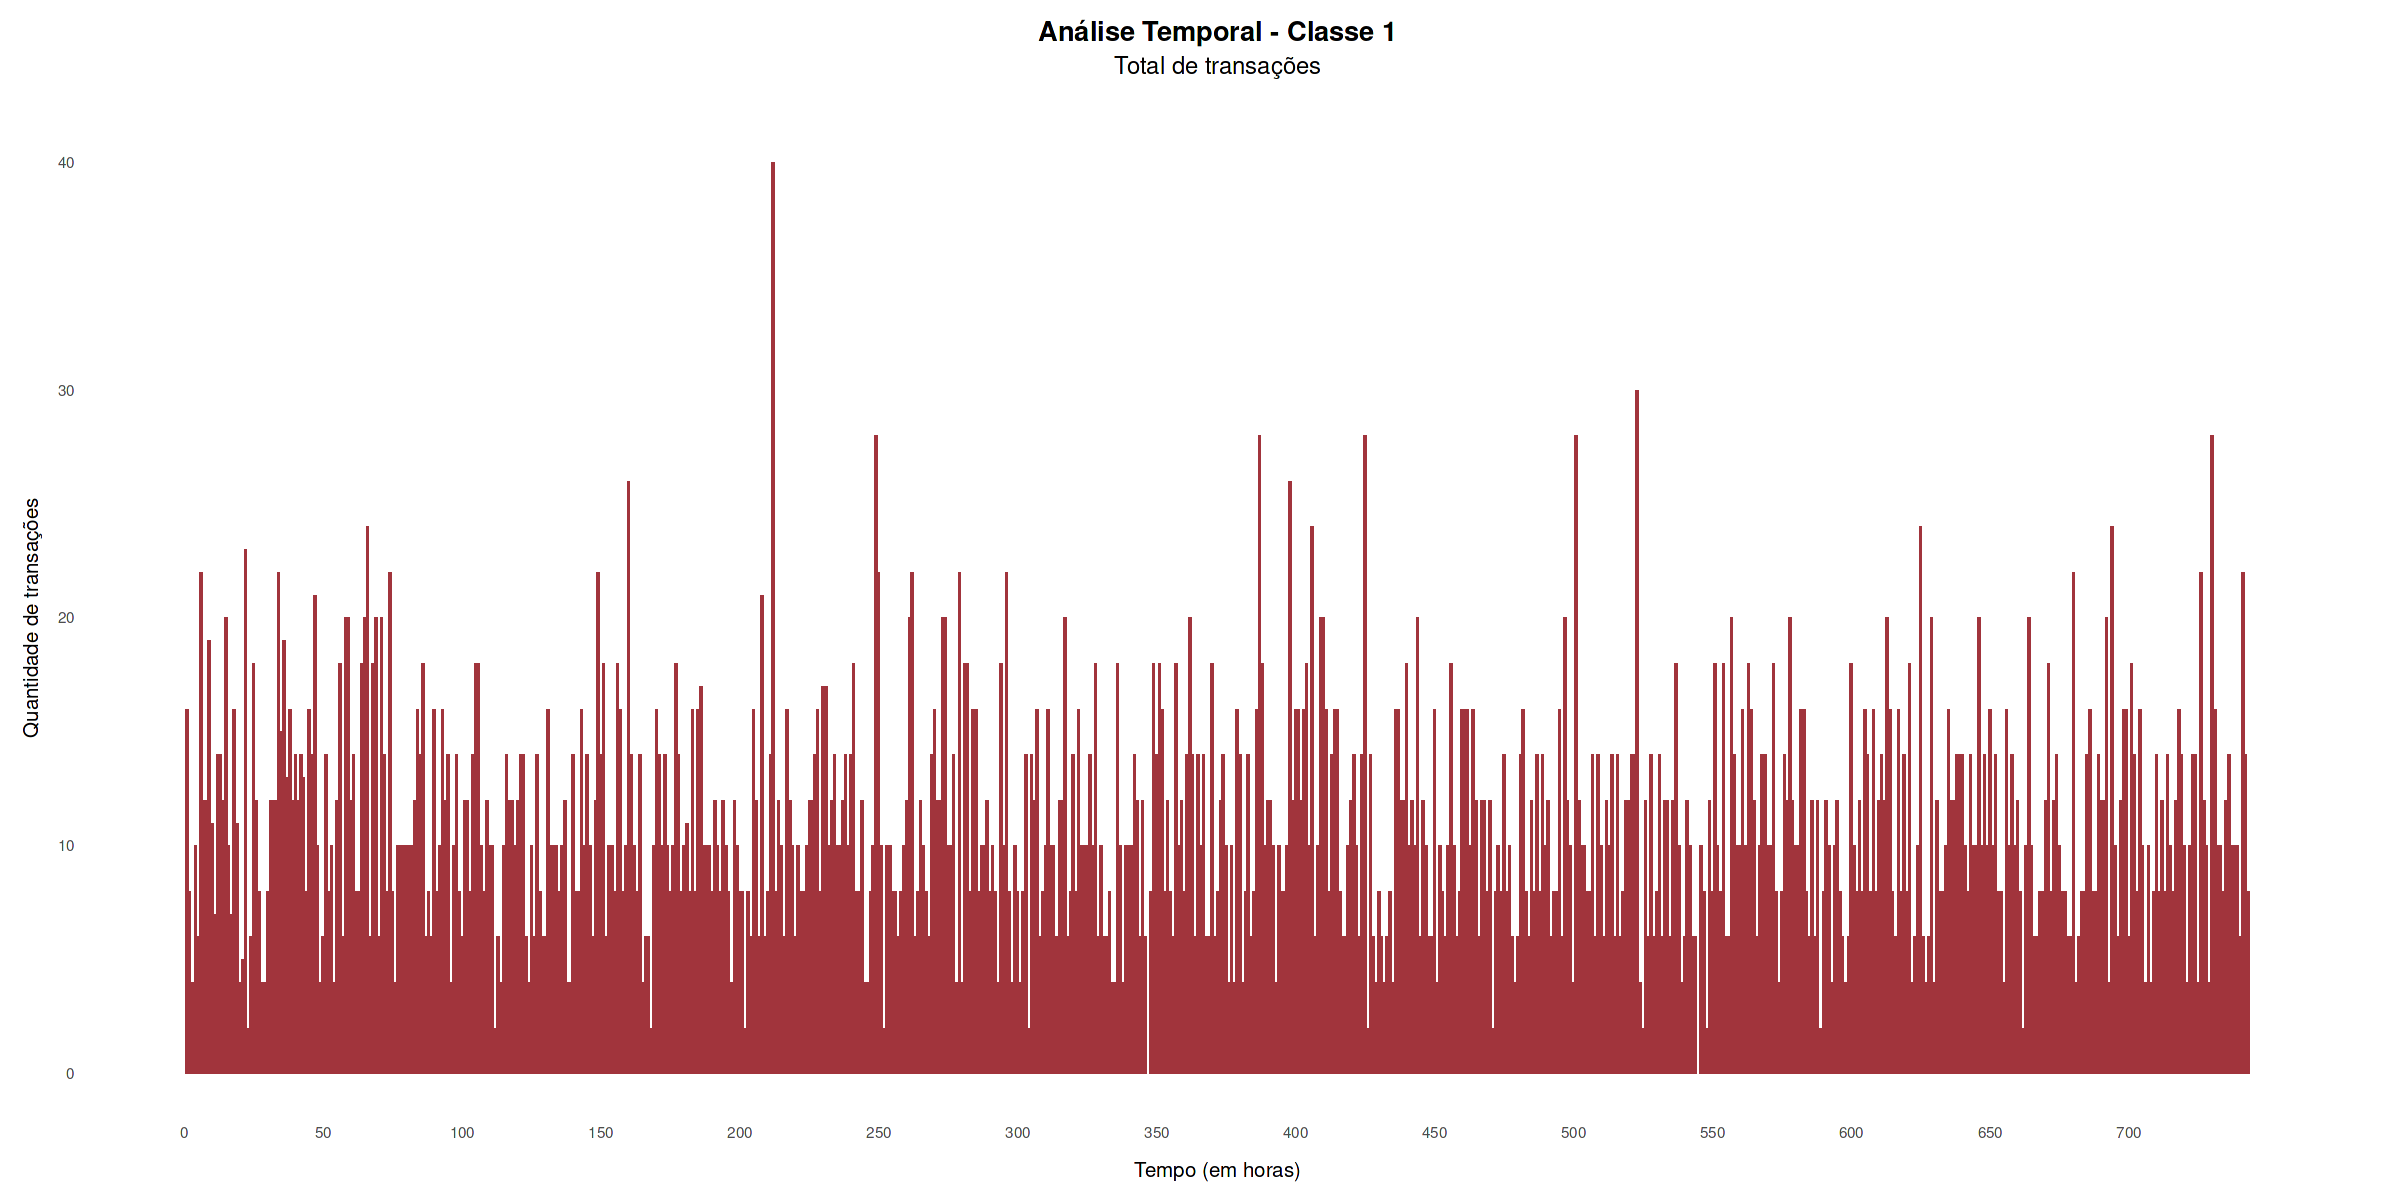

In [73]:
# Quantidade de transações da classe 1
ggplot(df_tempo[df_tempo$isfraude == 1,]) +
  aes(x = tempo, y = quantidade) +
  geom_bar(stat = "identity", fill='#a1343c') +
  labs(
    x = "Tempo (em horas)",
    y = "Quantidade de transações",
    title = "Análise Temporal - Classe 1",
    subtitle = "Total de transações"
  ) +
  scale_y_continuous(breaks = seq(0, max(df_tempo$quantidade), by = 10)) +
  scale_x_continuous(breaks = seq(0, max(df1$tempo), by = 50)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

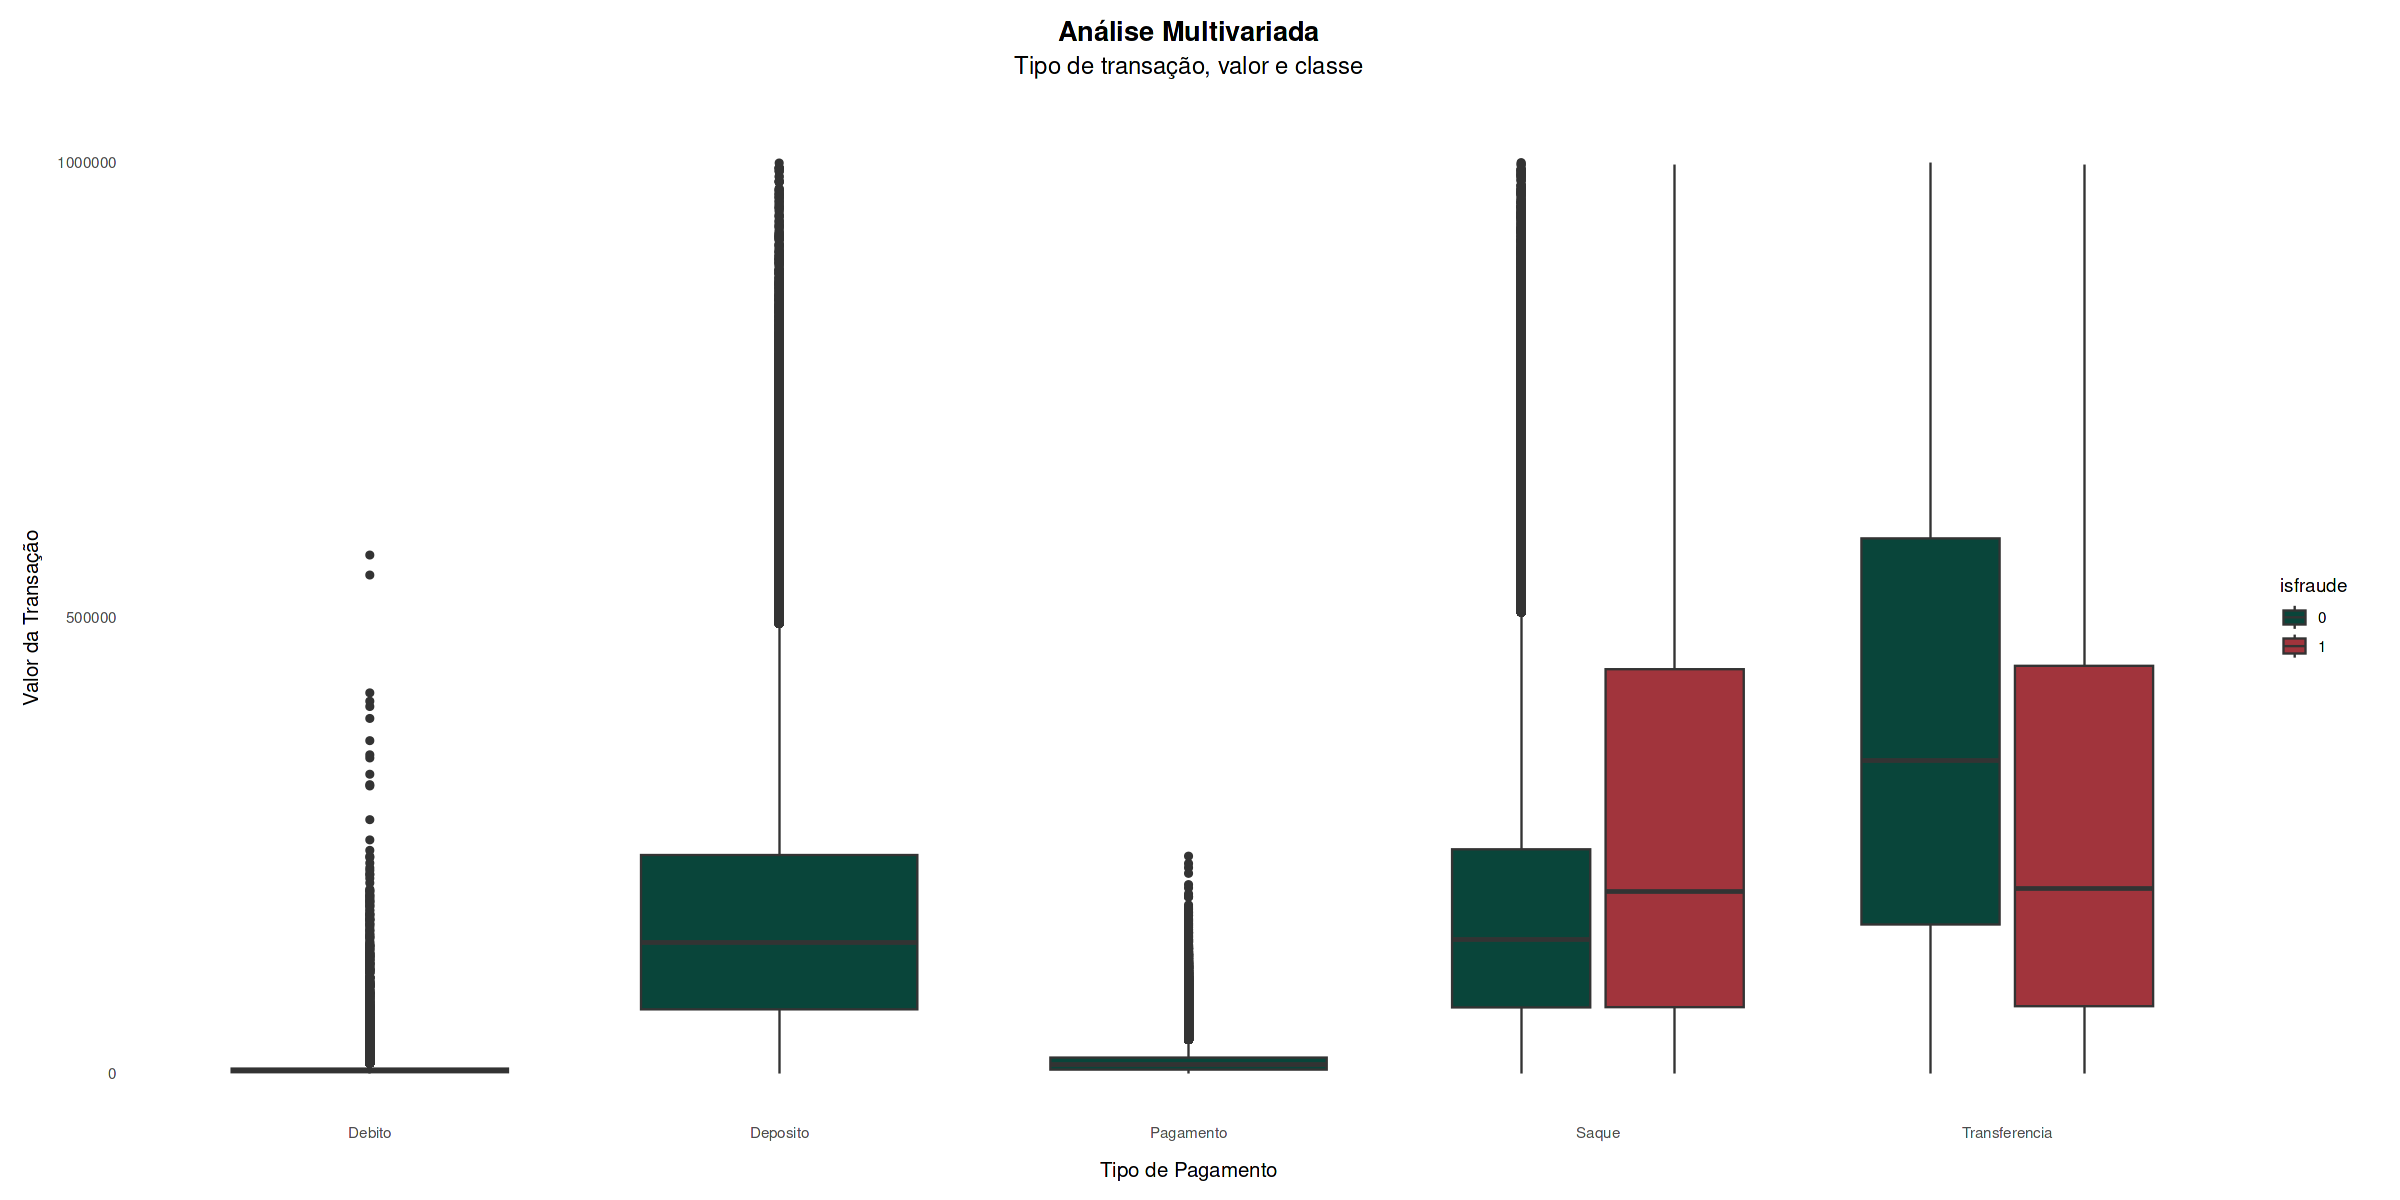

In [74]:
# Boxplot para analisar os tipos de transações x valores x classes
ggplot(df1[df1$valor_transacao < 1000000,], aes(x = tipo_transacao, y = valor_transacao, fill = isfraude)) +
  geom_boxplot() +
  scale_fill_manual(values = c("#09453a","#a1343c")) +
  labs(
    x = "Tipo de Pagamento",
    y = "Valor da Transação",
    title = "Análise Multivariada",
    subtitle = "Tipo de transação, valor e classe"
  ) +
  scale_y_continuous(breaks = seq(0, 1000000, by = 500000))+
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

Observações sobre o gráfico acima:
- Transações fraudulentas do tipo débit, tendem a ter valores menores a transações não fraudulentas.
- Transações fraudulentas do tipo crédito, tendem a ter valores maiores a transações não fraudulentas.
- Transações fraudulentas com transferência bancária tendem a ter valores menores a transações não fraudulentas.
- Em geral, as transações fraudulentas tendem a ter valores menores a transações não fraudulentas.
- Somente nos tipos `saque` e `transferência` foram identificados atividades fraudulentas.

****
# 2. Engenharia de Atributos
Nesta seção, será criado novas variáveis a fim de identificar explicação nas predições da variável `isfraude`.

In [81]:
# Criando a variável Orig_dest
# relaciona o cliente origem com o cliente destino
df1$Orig_dest <- paste0(substr(df1$cliente_origem,1,1),substr(df1$cliente_destino,1,1))

In [82]:
# Analisando os valores por categoria
df1$Orig_dest <- as.factor(df1$Orig_dest)
table(df1$Orig_dest)


     CC      CM 
4211125 2151495 

In [83]:
# Analisando as frequências na variável Orig_dest
resumo_orig_dest <- df1 %>%
                    group_by(Orig_dest, isfraude) %>%
                      summarise(Total = n())
resumo_orig_dest

Orig_dest,isfraude,Total
<fct>,<fct>,<int>
CC,0,4202912
CC,1,8213
CM,0,2151495


**dia:**
- Criaremos a variável `dia` baseado na variável `tempo`, na qual representa 1 unidade = 1 hora

In [84]:
# Criando a variável dia
df1$dia <- as.integer(df1$tempo/24 + 1)

# Alterando para factor a variável `dia`
df1$dia <- as.factor(df1$dia)

In [78]:
head(df1)

,tempo,tipo_transacao,valor_transacao,cliente_origem,saldo_anterior_origem,novo_saldo_origem,cliente_destino,saldo_anterior_destino,novo_saldo_destino,isfraude,flag_fraude,Orig_dest,dia
,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
1,1,Pagamento,9839.6,C1231006815,170136,160296,M1979787155,0,0,0,0,CM,1
2,1,Pagamento,1864.3,C1666544295,21249,19385,M2044282225,0,0,0,0,CM,1
3,1,Transferencia,181.0,C1305486145,181,0,C553264065,0,0,1,0,CC,1
4,1,Saque,181.0,C840083671,181,0,C38997010,21182,0,1,0,CC,1
5,1,Pagamento,11668.1,C2048537720,41554,29886,M1230701703,0,0,0,0,CM,1
6,1,Pagamento,7817.7,C90045638,53860,46042,M573487274,0,0,0,0,CM,1


In [86]:
# Verificando a quantidade de fraudes por dia
df_dia <- df1 %>%
          group_by(dia, isfraude) %>%
          summarise(quantidade = n())

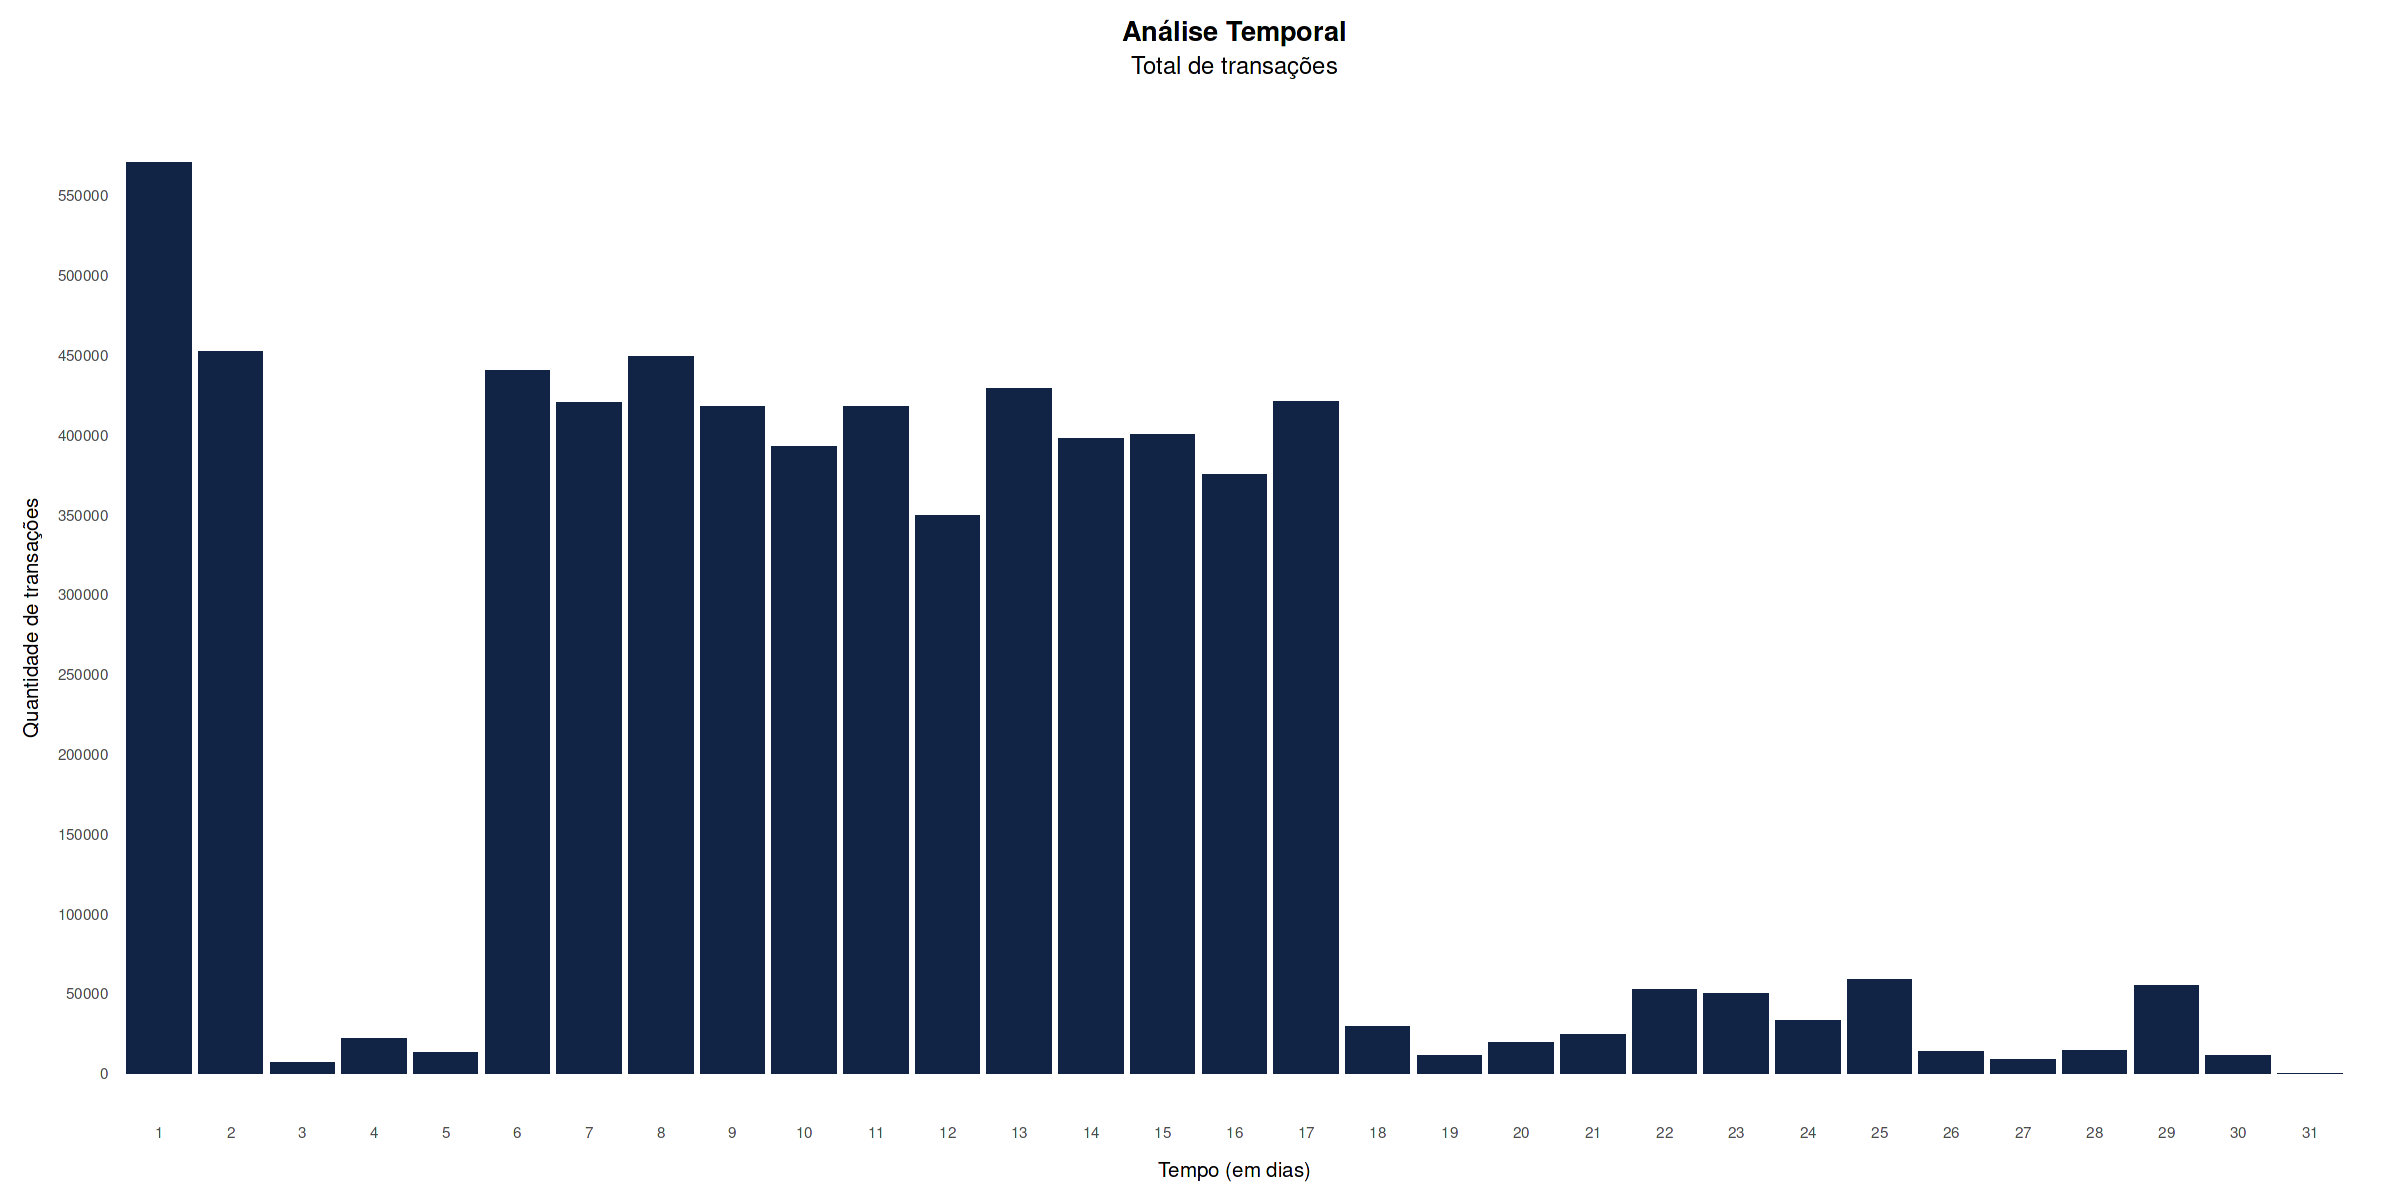

In [87]:
# Quantidade de transações
ggplot(df_dia) +
  aes(x = dia, y = quantidade) +
  geom_bar(stat = "identity", fill='#112446') +
  labs(
    x = "Tempo (em dias)",
    y = "Quantidade de transações",
    title = "Análise Temporal",
    subtitle = "Total de transações"
  ) +
  scale_y_continuous(breaks = seq(0, max(df_dia$quantidade), by = 50000)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

Observações sobre o gráfico acima:
- A maioria das transações ocorre nos dias 1 e 2.
- Há um pico negativo de transações no dia 3.
- O número de transações diminui gradualmente após o dia 3.
- Há um pico positivo a partir do dia 6, próximo ao número de transações do dia 2.
- A maioria das transações ocorre nos dias de semana.
- Há menos transações nos fins de semana.
- A partir do dia 17, ocorre novamente um pico negativo das transações com uma amplitude bem próxima da primeira ocorrência ente o dia 2 e 3.
- Há um padrão sazonal no número de transações.

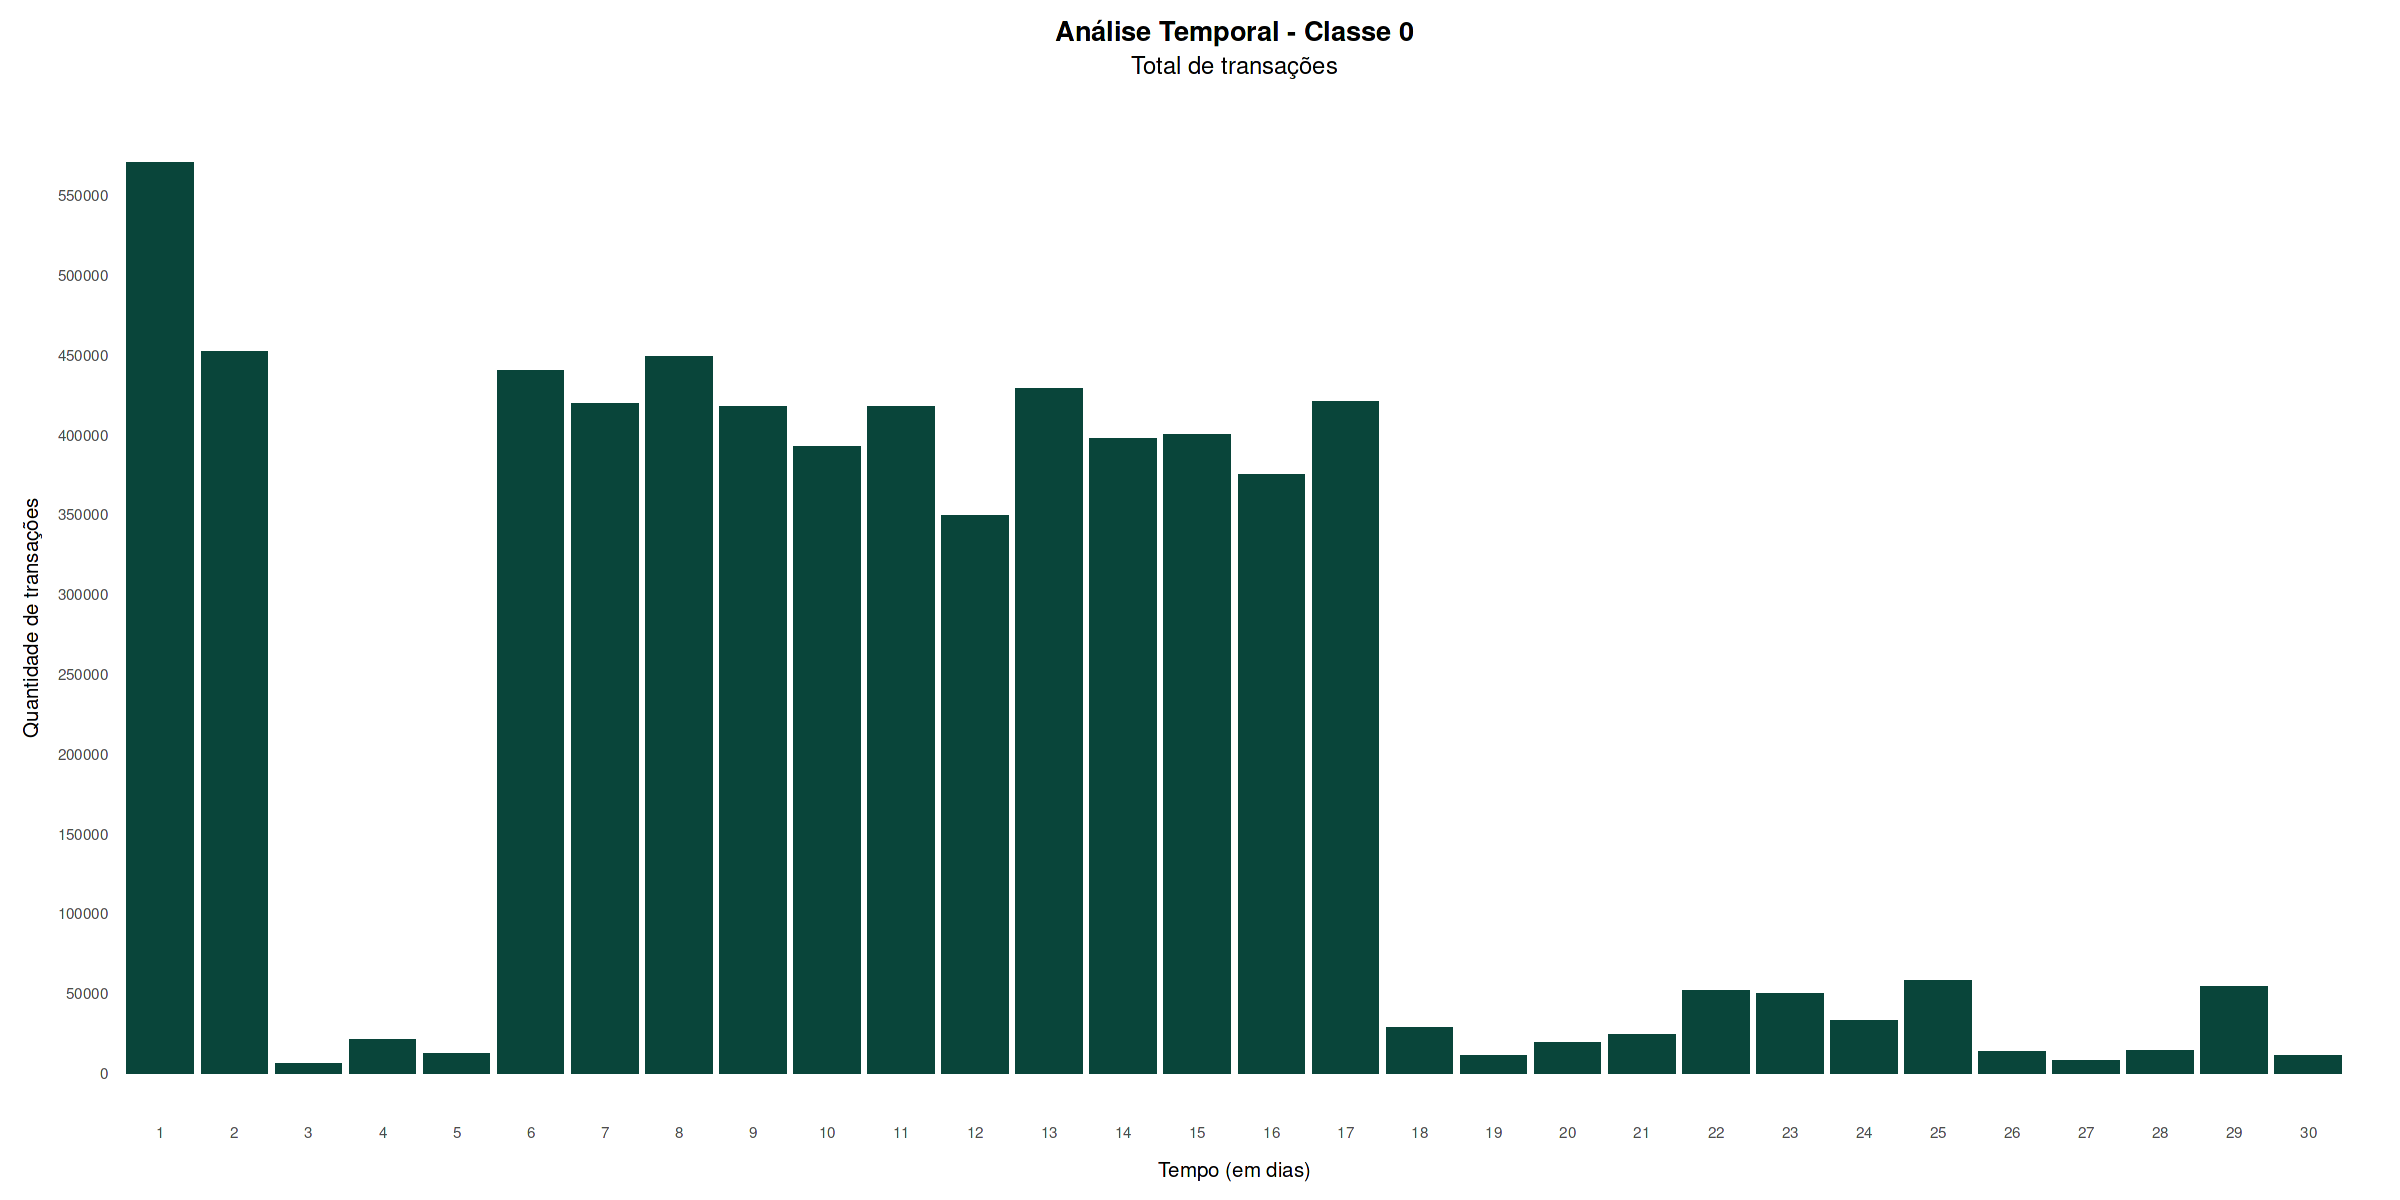

In [88]:
# Quantidade de transações da classe 0
ggplot(df_dia[df_dia$isfraude == 0,]) +
  aes(x = dia, y = quantidade) +
  geom_bar(stat = "identity", fill='#09453a') +
  labs(
    x = "Tempo (em dias)",
    y = "Quantidade de transações",
    title = "Análise Temporal - Classe 0",
    subtitle = "Total de transações"
  ) +
  scale_y_continuous(breaks = seq(0, max(df_dia$quantidade), by = 50000)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

Observações sobre o gráfico acima:
- Possui comportamente identico ao gráfico anterior (total de transações), devido ser uma classe majoritária (0), as quantidades de transações fraudulentas se dispersam, por serem pequenas o suficiente.

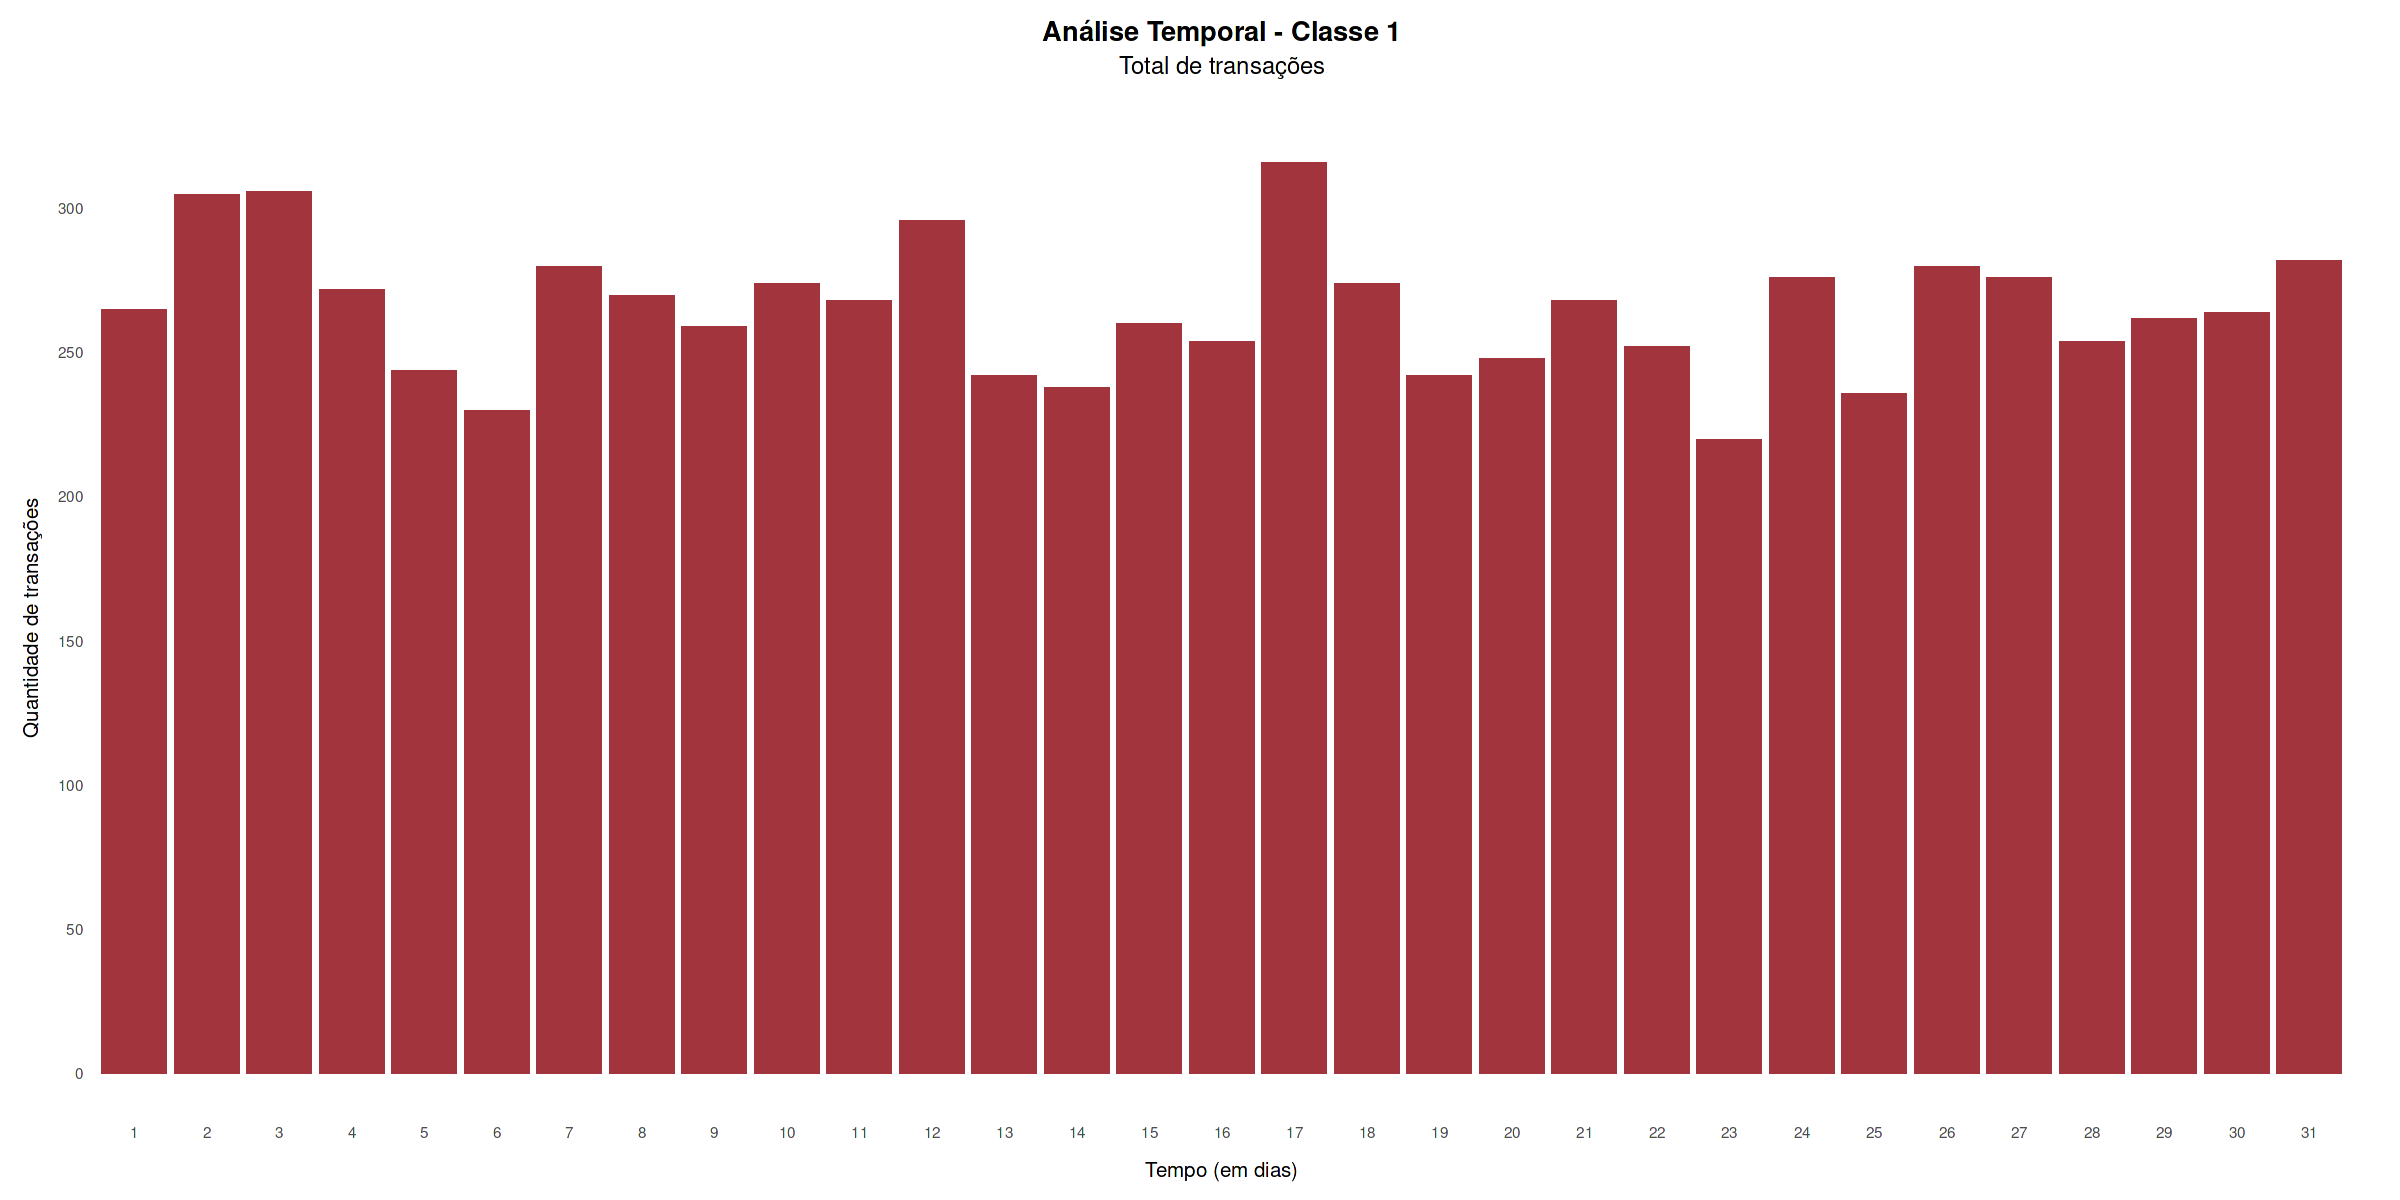

In [89]:
# Quantidade de transações da classe 1
ggplot(df_dia[df_dia$isfraude == 1,]) +
  aes(x = dia, y = quantidade) +
  geom_bar(stat = "identity", fill='#a1343c') +
  labs(
    x = "Tempo (em dias)",
    y = "Quantidade de transações",
    title = "Análise Temporal - Classe 1",
    subtitle = "Total de transações"
  ) +
  scale_y_continuous(breaks = seq(0, max(df_dia$quantidade), by = 50)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

Observações sobre o gráfico acima:
- O número de transações fraudulentas é muito menor do que o número de transações não fraudulentas.
- O maior pico positivo registrado, foi no dia 17.
- É praticamente constante o comportamento das transações fraudulentas
- Há um padrão sazonal no número de transações fraudulentas.
- As transações fraudulentas são mais comuns nos dias de semana do que nos fins de semana.

In [90]:
# Estatística descritiva Classe 1
summary(df_dia[df_dia$isfraude == 1,])

      dia     isfraude   quantidade 
 1      : 1   0: 0     Min.   :220  
 2      : 1   1:31     1st Qu.:250  
 3      : 1            Median :265  
 4      : 1            Mean   :265  
 5      : 1            3rd Qu.:276  
 6      : 1            Max.   :316  
 (Other):25                         

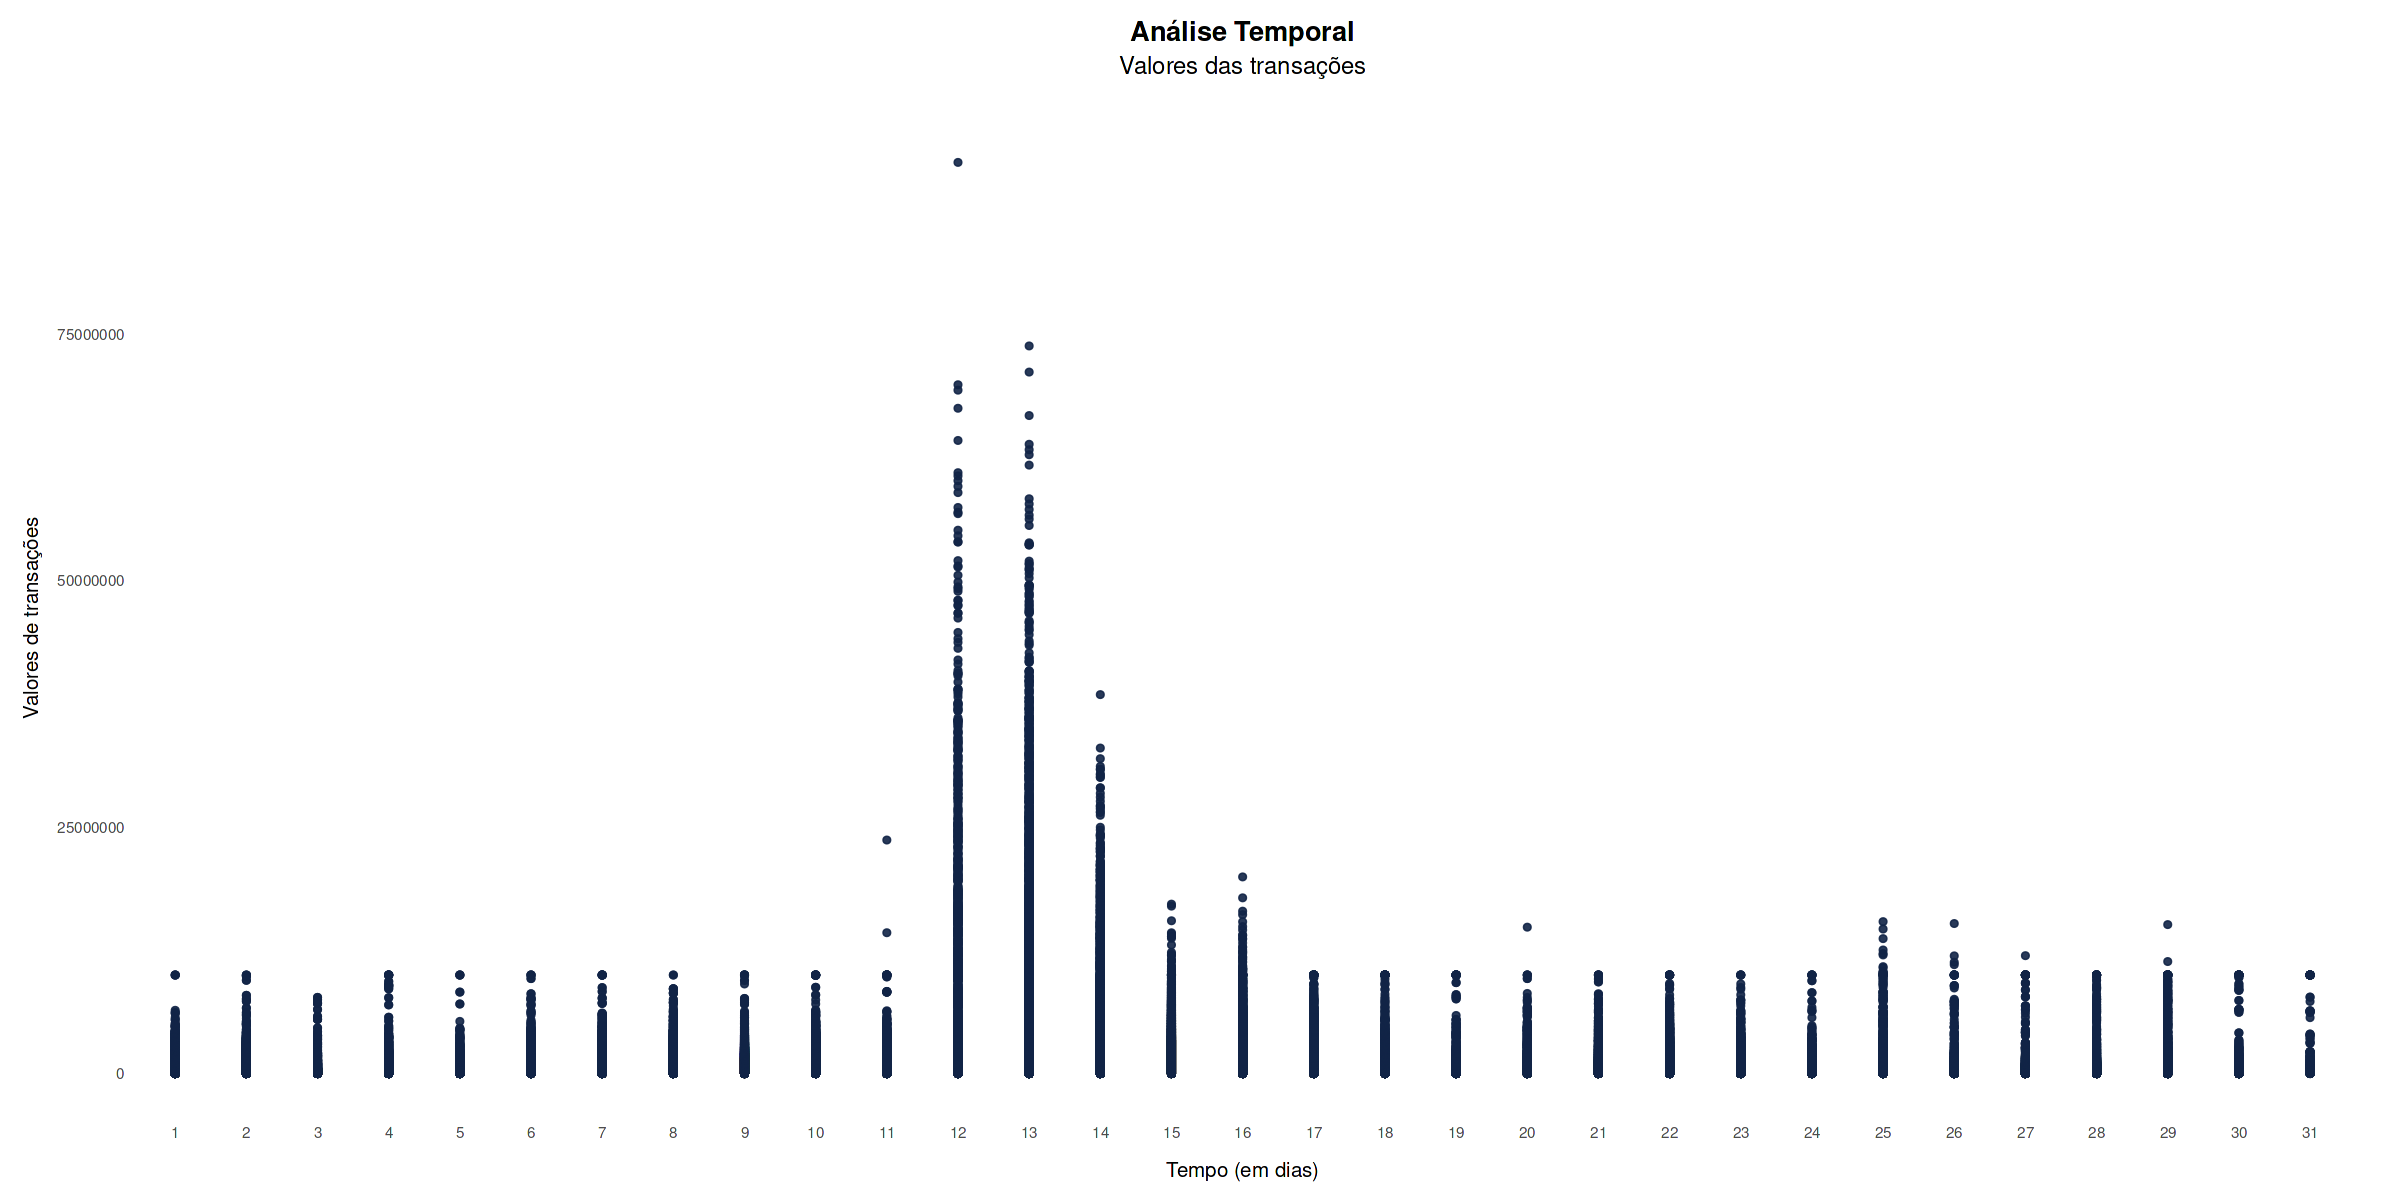

In [91]:
# Grafico de tempo(horas) x valor de transacao
ggplot(df1) +
  aes(x = dia, y = valor_transacao) +
  geom_point(shape = "circle", size = 1.5, colour = "#112446", alpha = 0.9) +
  labs(
    x = "Tempo (em dias)",
    y = "Valores de transações",
    title = "Análise Temporal",
    subtitle = "Valores das transações"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

Observações sobre o gráfico acima:
- Os valores das transações nos 10 primeiros dias, são bem próximos, abaixo de 10 milhoes.
- A partir do dia 11, as transações apresentam picos positivos de valores atípicos.
- Do dia 17 até o término do mês, os valores tendem a retornam ao range dos valores iniciais.
- O dia 12 apresentou a maior transação realizada.

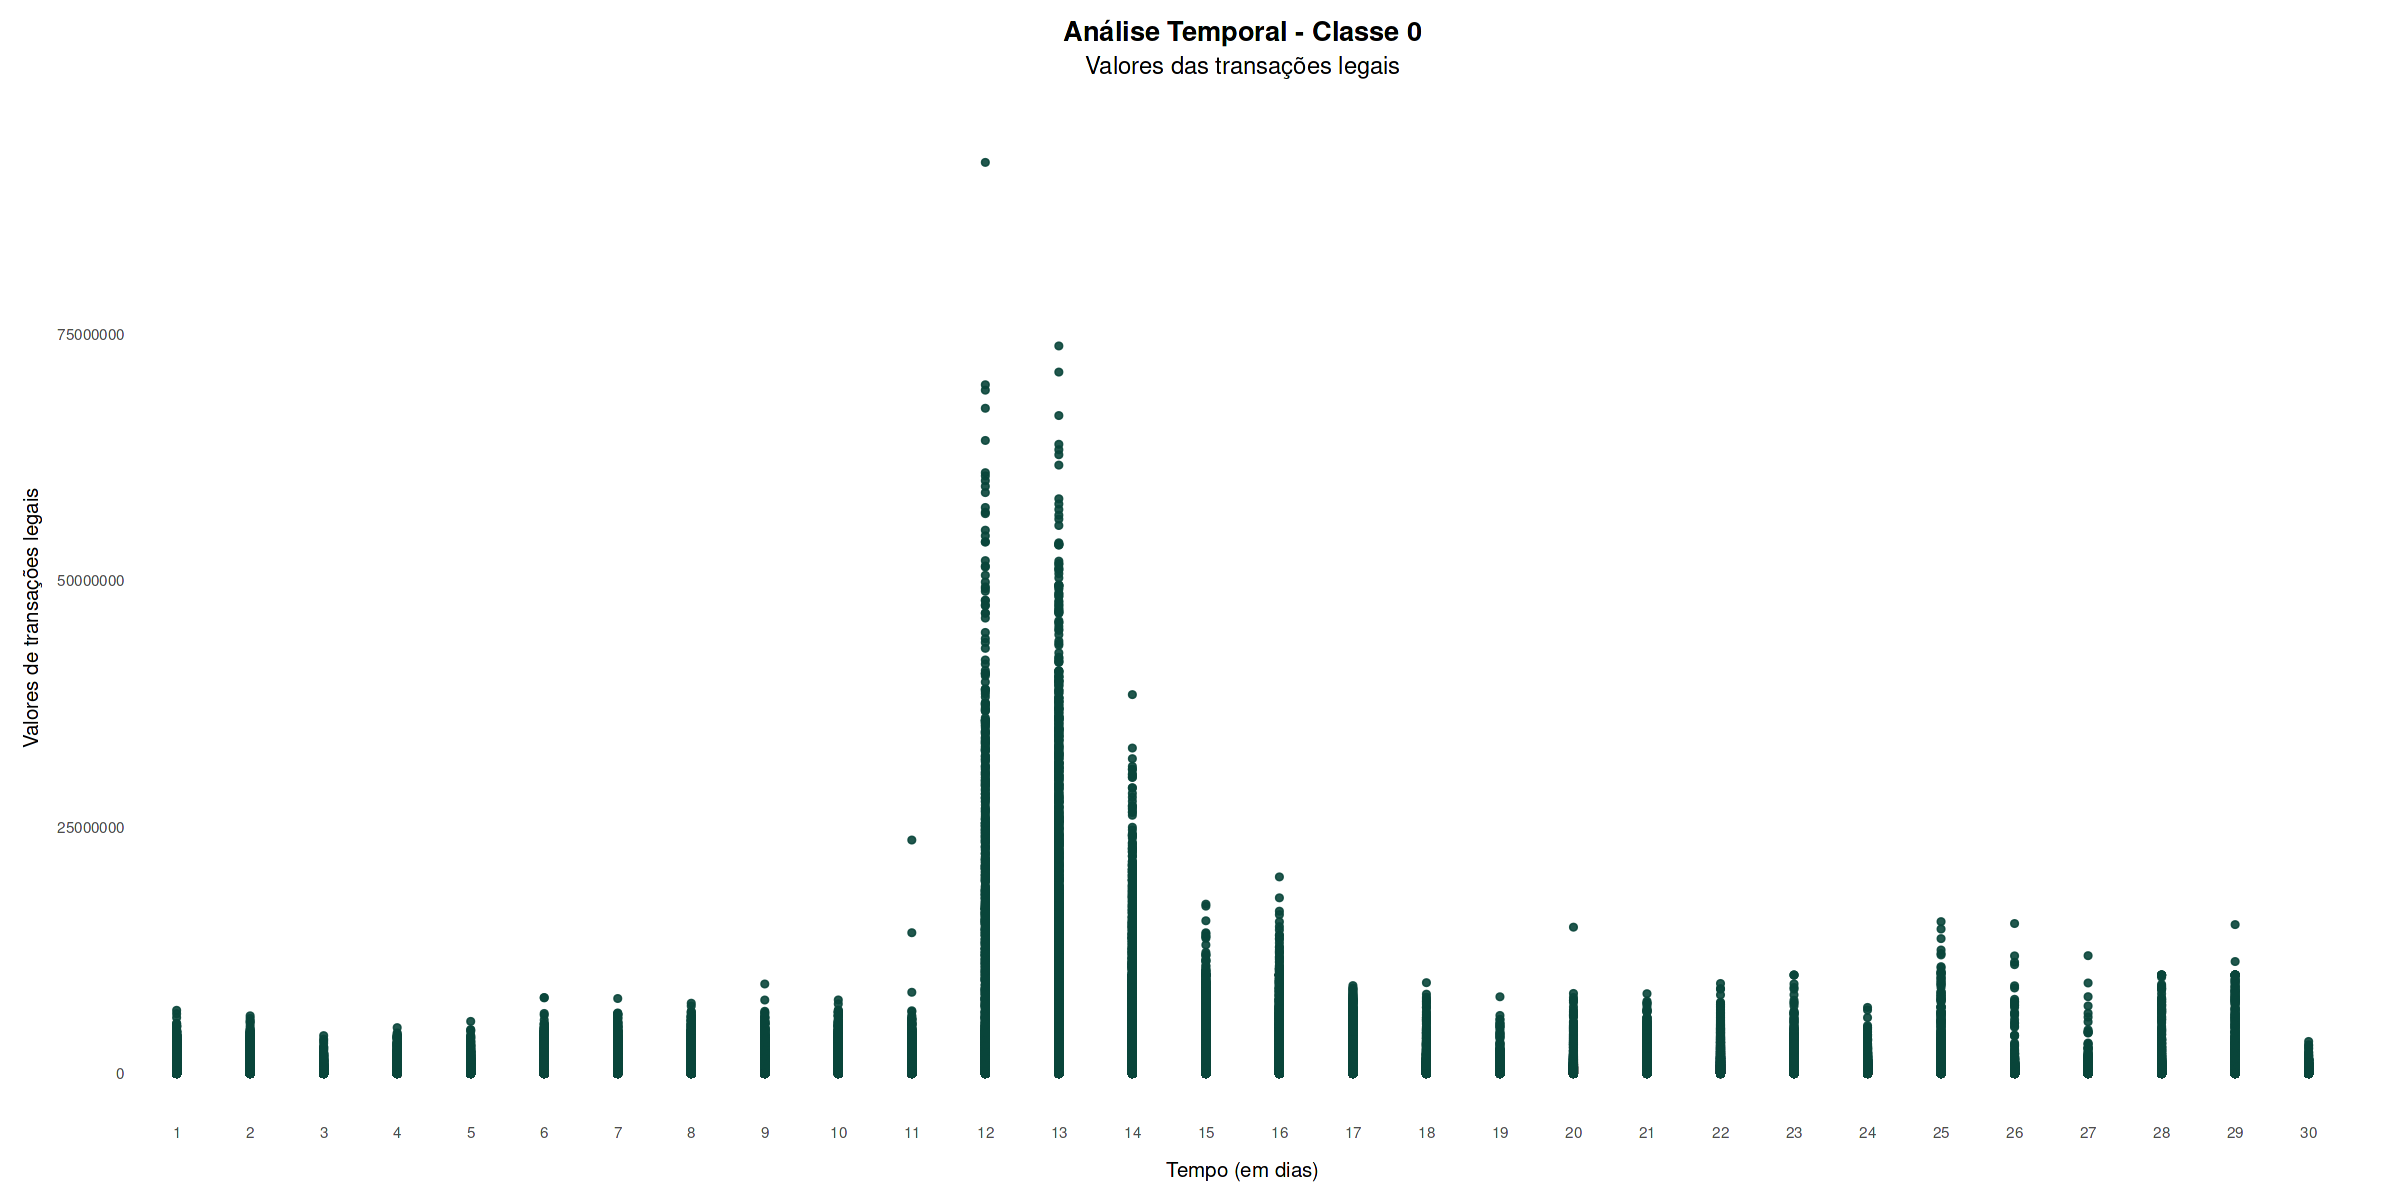

In [92]:
# Grafico de tempo(horas) x classe 0
ggplot(df1[df1$isfraude == 0,]) +
  aes(x = dia, y = valor_transacao) +
  geom_point(shape = "circle", size = 1.5, colour = "#09453a", alpha = 0.9) +
  labs(
    x = "Tempo (em dias)",
    y = "Valores de transações legais",
    title = "Análise Temporal - Classe 0",
    subtitle = "Valores das transações legais"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

Observações sobre o gráfico acima:
- Possui o mesmo comportamento do gráfico anterior, devido ser uma classe majoritária.

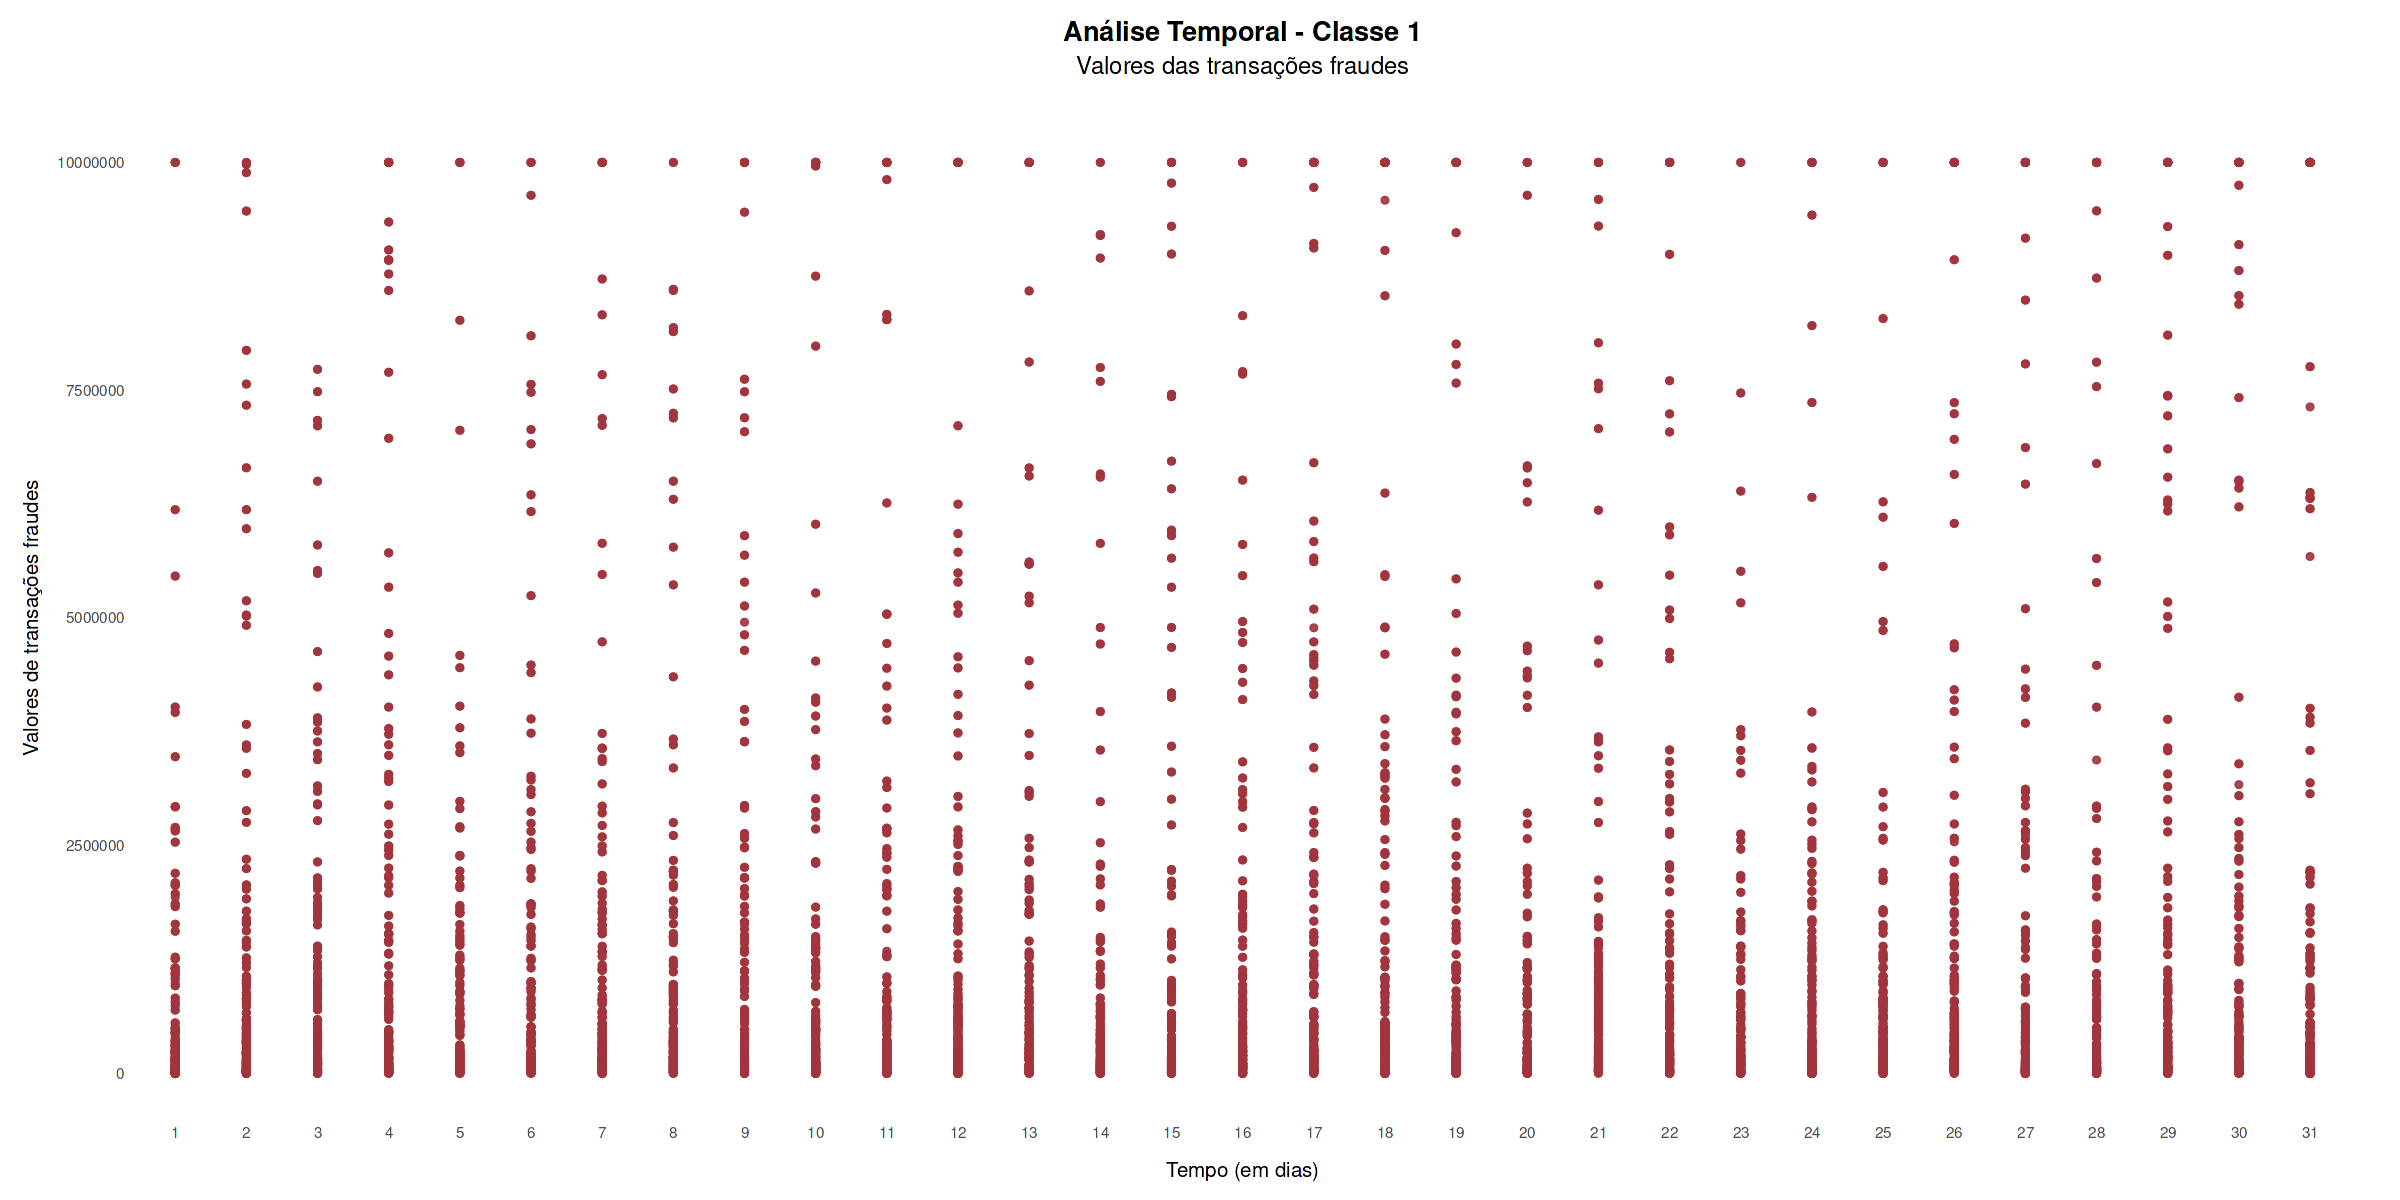

In [93]:
# Grafico de tempo(horas) x classe 1
ggplot(df1[df1$isfraude == 1,]) +
  aes(x = dia, y = valor_transacao) +
  geom_point(shape = "circle", size = 1.5, colour = "#a1343c", alpha = 0.9) +
  labs(
    x = "Tempo (em dias)",
    y = "Valores de transações fraudes",
    title = "Análise Temporal - Classe 1",
    subtitle = "Valores das transações fraudes"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L,
    face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

Observações sobre o gráfico acima:
- O valor médio das transações fraudulentas é menor do que o valor médio das transações não fraudulentas.
- Há uma maior variabilidade nos valores das transações fraudulentas do que nos valores das transações não fraudulentas.
- Os valores das transações fraudulentas são mais propensos a serem altos do que os valores das transações não fraudulentas.
- Há alguns valores atípicos altos nas transações fraudulentas.
- A maioria das transações fraudulentas ocorre nos dias 12 e 17.

****
**turno:**
- Criaremos a variável `turno` baseado na variável `tempo`.

In [94]:
# Gerando um dataframe contendo os dias x soma das transações
transacoes_dia <- df1 %>%
                  group_by(dia, isfraude) %>%
                  summarise(Total = n())
transacoes_dia_0 <- transacoes_dia[transacoes_dia$isfraude == 0,c('dia','Total')]
transacoes_dia_1 <- transacoes_dia[transacoes_dia$isfraude == 1,c('dia','Total')]

# Acrescentando o dia 31
dia_31 <- data.frame(dia = 31, Total = 0)
dia_31$dia <- as.factor(dia_31$dia)
transacoes_dia_0 <- rbind(transacoes_dia_0, dia_31)
transacoes_dia_ <- cbind(transacoes_dia_0,transacoes_dia_1)
transacoes_dia_ <- transacoes_dia_[,-3]
names(transacoes_dia_) <- c('dia','classe0','classe1')

# Função para categorizar as horas em períodos do dia
turno <- function(hora_dia){

  if (hora_dia >= 6 && hora_dia < 12) {
    return ("Manhã")

  } else if(hora_dia >= 12 && hora_dia < 18){
    return ("Tarde")

  } else if(hora_dia >= 18 && hora_dia < 24){
    return ("Noite")

  }else
    return ("Madrugada")
}
    
# Criando a variável de período do dia
df1$turno <- sapply(df1$tempo, turno)

# Alterando para factor a variável `turno`
df1$turno <- as.factor(df1$turno)

# Verificando a frequência
table(df1$turno)

New names:
• `dia` -> `dia...1`
• `Total` -> `Total...2`
• `dia` -> `dia...3`
• `Total` -> `Total...4`



Madrugada     Manhã     Noite     Tarde 
  5797085    140454    179487    245594 

In [95]:
# Analisando as classes em relação aos turnos
turno_classe <- df1 %>%
                group_by(turno, isfraude) %>%
                summarize(Total = n())
turno_classe

turno,isfraude,Total
<fct>,<fct>,<int>
Madrugada,0,5789093
Madrugada,1,7992
Manhã,0,140371
Manhã,1,83
Noite,0,179426
Noite,1,61
Tarde,0,245517
Tarde,1,77


In [96]:
# Verificando as frequências
prop.table(table(turno_classe))

, , Total = 61

           isfraude
turno           0     1
  Madrugada 0.000 0.000
  Manhã     0.000 0.000
  Noite     0.000 0.125
  Tarde     0.000 0.000

, , Total = 77

           isfraude
turno           0     1
  Madrugada 0.000 0.000
  Manhã     0.000 0.000
  Noite     0.000 0.000
  Tarde     0.000 0.125

, , Total = 83

           isfraude
turno           0     1
  Madrugada 0.000 0.000
  Manhã     0.000 0.125
  Noite     0.000 0.000
  Tarde     0.000 0.000

, , Total = 7992

           isfraude
turno           0     1
  Madrugada 0.000 0.125
  Manhã     0.000 0.000
  Noite     0.000 0.000
  Tarde     0.000 0.000

, , Total = 140371

           isfraude
turno           0     1
  Madrugada 0.000 0.000
  Manhã     0.125 0.000
  Noite     0.000 0.000
  Tarde     0.000 0.000

, , Total = 179426

           isfraude
turno           0     1
  Madrugada 0.000 0.000
  Manhã     0.000 0.000
  Noite     0.125 0.000
  Tarde     0.000 0.000

, , Total = 245517

           isfraude
turno   

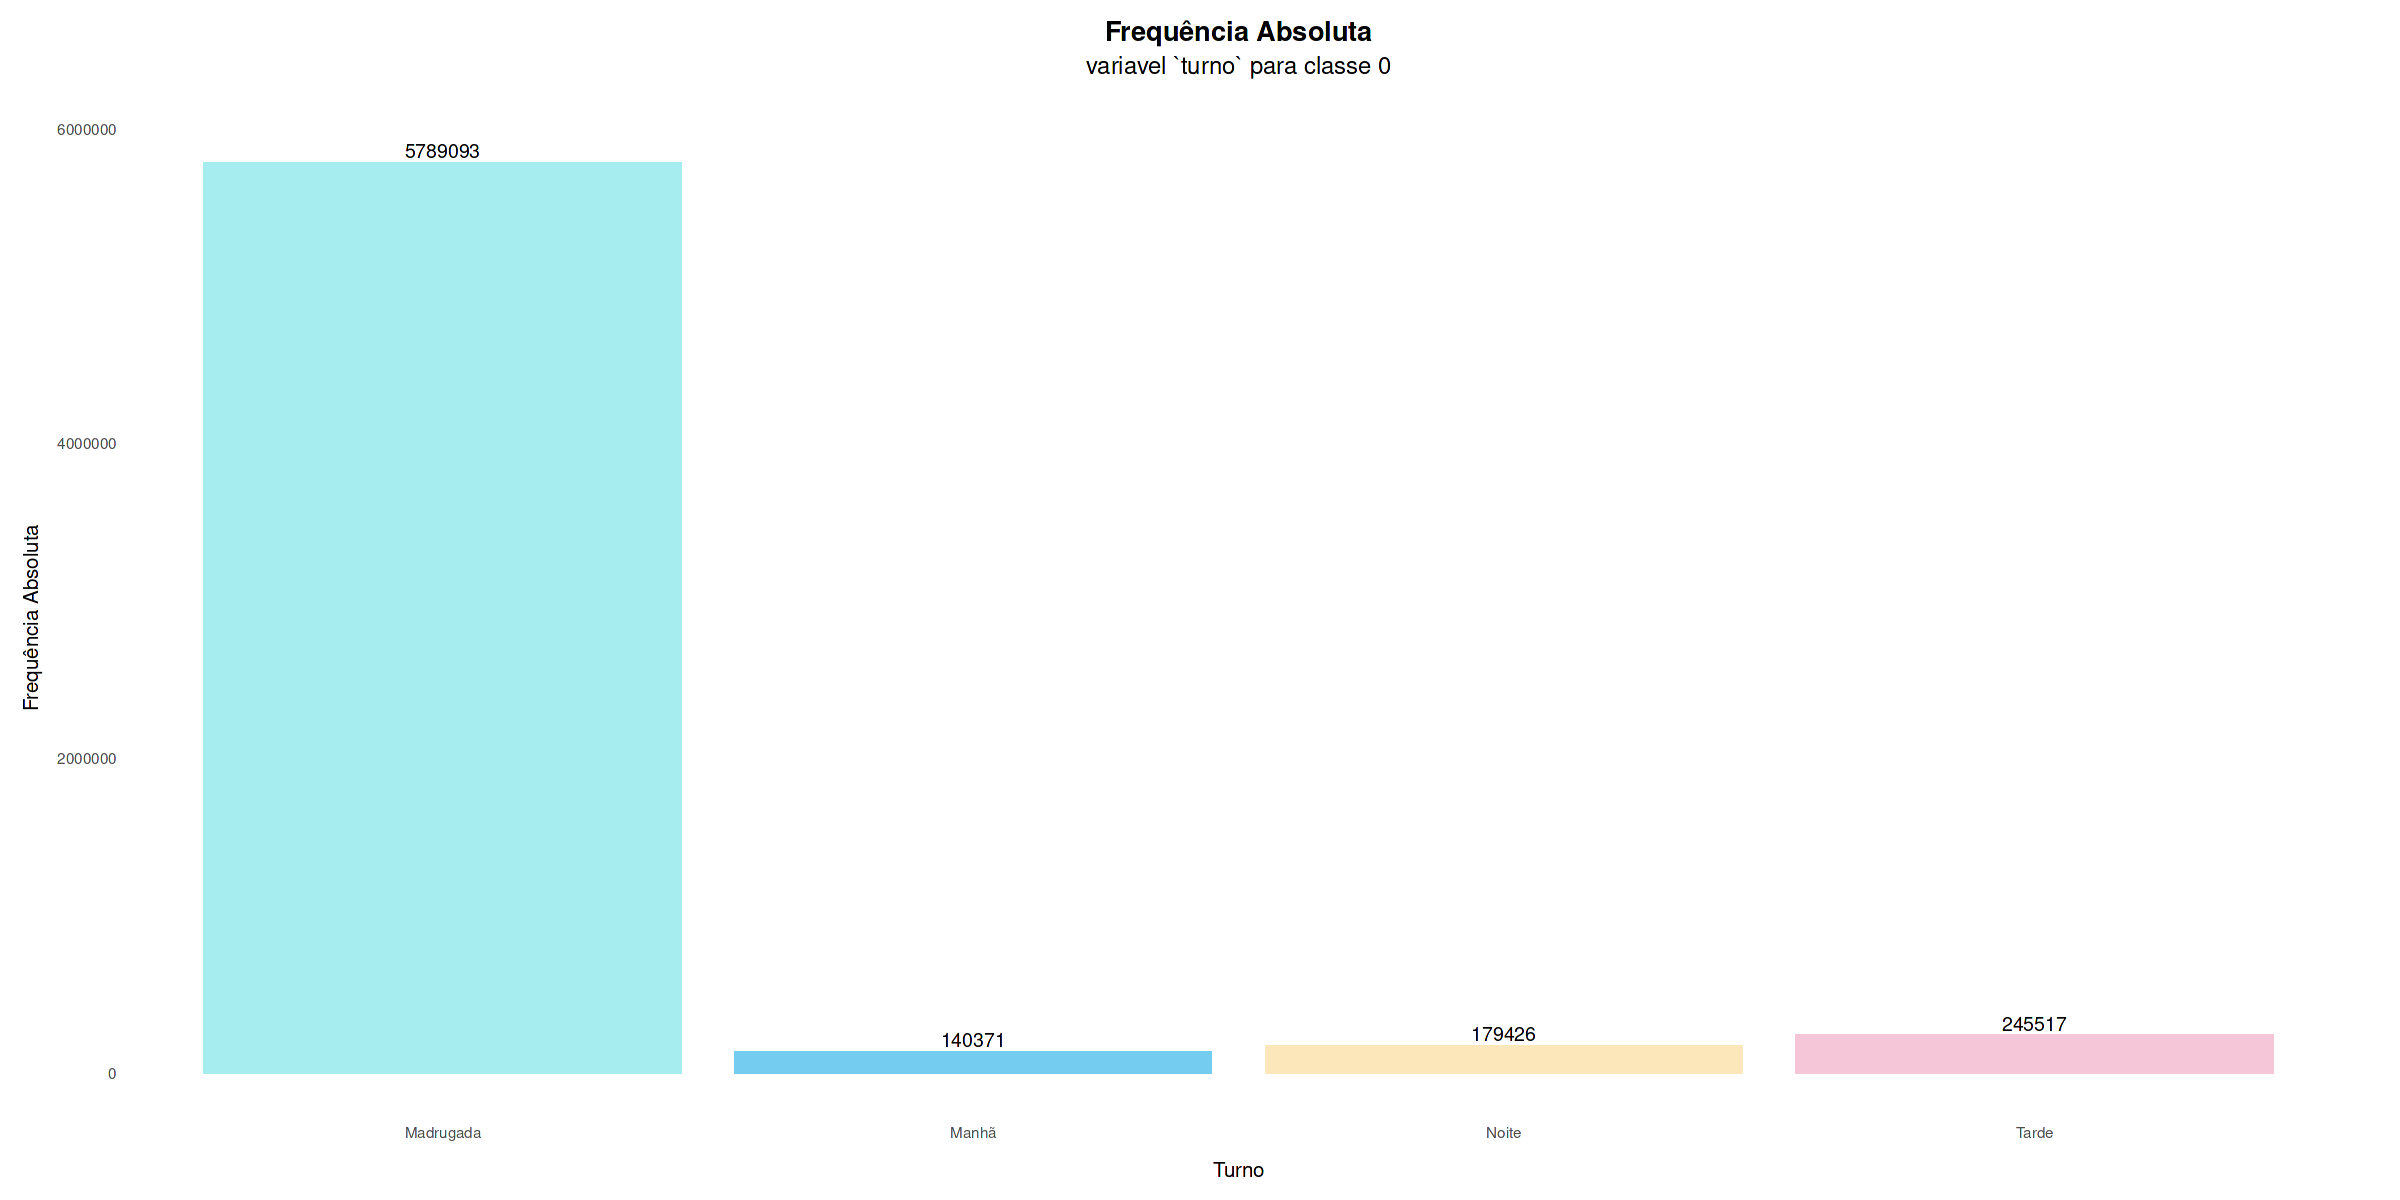

In [97]:
# Visualização gráfica da frequência Absoluta da variável `tipo_transacao` para classe 0
ggplot(turno_classe[turno_classe$isfraude == 0,]) +
  aes(x = turno, y = Total) +
  geom_col(fill = c("#a6edf0", "#75ccf1", "#fce7ba", "#f5c6d7")) +
  labs(
    x = "Turno",
    y = "Frequência Absoluta",
    title = "Frequência Absoluta",
    subtitle = "variavel `turno` para classe 0"
  ) +
  geom_text(aes(label = Total), vjust = -0.3, size = 4) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

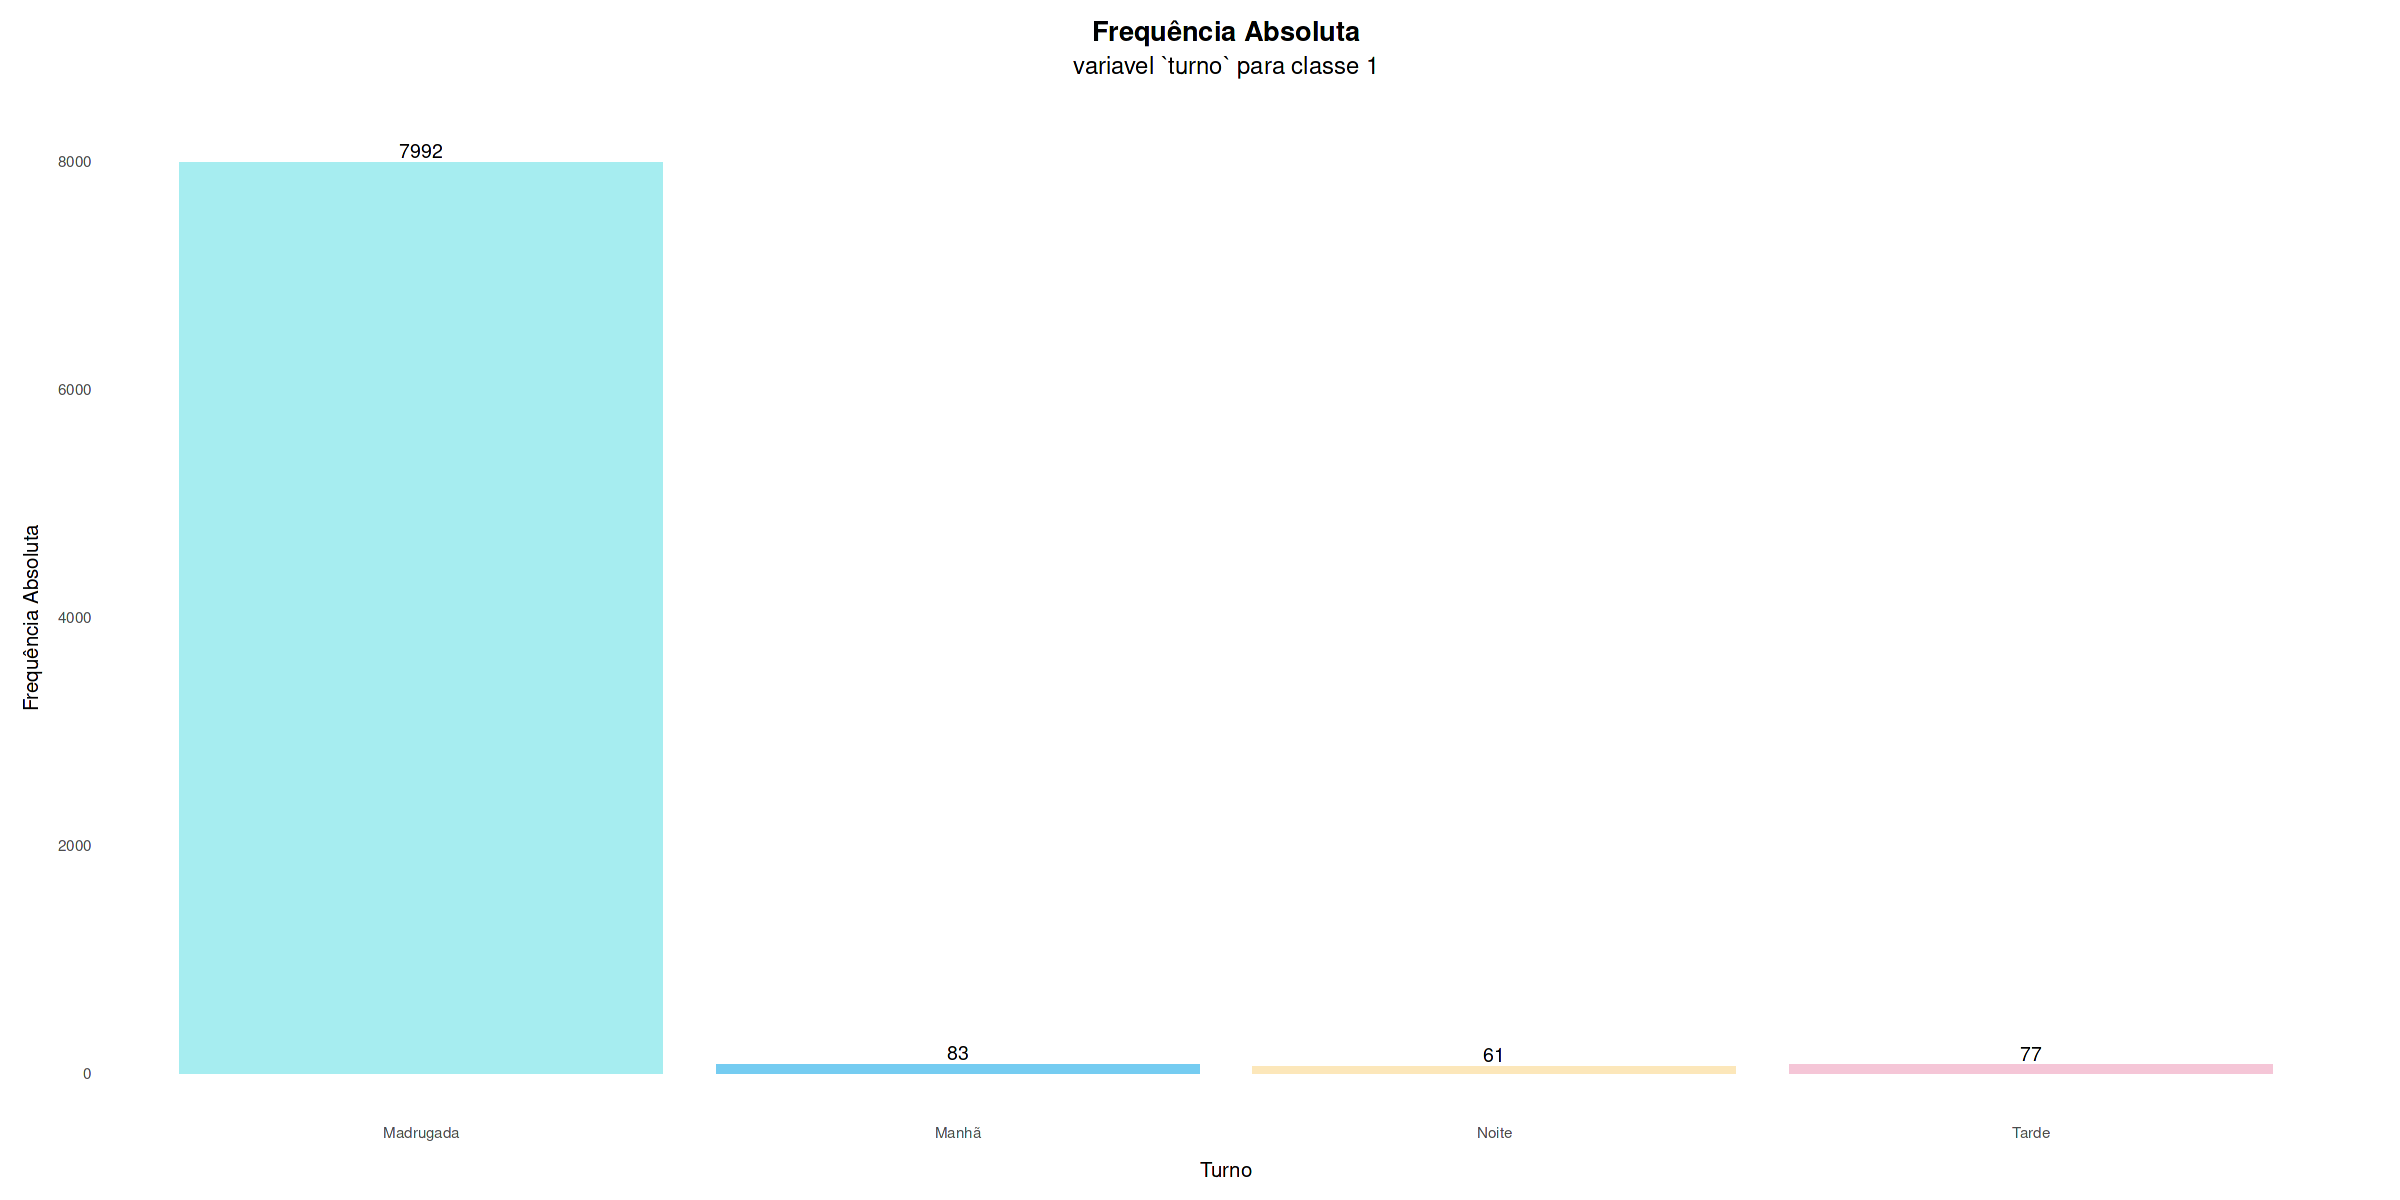

In [98]:
# Visualização gráfica da frequência Absoluta da variável `tipo_transacao` para classe 1
ggplot(turno_classe[turno_classe$isfraude == 1,]) +
  aes(x = turno, y = Total) +
  geom_col(fill = c("#a6edf0", "#75ccf1", "#fce7ba", "#f5c6d7")) +
  labs(
    x = "Turno",
    y = "Frequência Absoluta",
    title = "Frequência Absoluta",
    subtitle = "variavel `turno` para classe 1"
  ) +
  geom_text(aes(label = Total), vjust = -0.3, size = 4) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16L, face = "bold", hjust = 0.5, vjust = 5),
    plot.subtitle = element_text(size = 14L, hjust = 0.5, vjust = 5),
    plot.caption = element_text(size = 12L),
    axis.title.y = element_text(size = 12L, vjust = 3),
    axis.title.x = element_text(size = 12L, vjust = -2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 0.7, 0.7), "cm")
  )

O gráfico de Frequência Absoluta da variável `turno` para a classe 1 (fraudes) demonstra que a maior ocorrência de transações são derivadas na madrugada, assim como para as transações da classe 0 (legais).

In [99]:
# Criando as duas variáveis de erro do balanceamento
df1$erro_saldo_origem <- df1$novo_saldo_origem + df1$valor_transacao - df1$saldo_anterior_origem
df1$erro_saldo_destino <- df1$saldo_anterior_destino + df1$valor_transacao - df1$novo_saldo_destino

In [100]:
# Filtrando as informações do conjunto de dados com Transferências e Saque (variáveis em que ocorrem fraudes)
df1$tipo_transacao <- as.character(df1$tipo_transacao)
df1 <- df1 %>%
    filter(tipo_transacao %in% c('Transferencia', 'Saque'))
df1$tipo_transacao <- as.factor(df1$tipo_transacao)

In [101]:
# Verificando as novas dimensões
sprintf('df original: %s linhas e %s variáveis',dim(df)[1],dim(df)[2])
sprintf('df filtrado: %s linhas e %s variáveis',dim(df1)[1],dim(df1)[2])

[1] "df original: 6362620 linhas e 11 variáveis"

[1] "df filtrado: 2770409 linhas e 16 variáveis"

In [102]:
# Verificando as estatísticas básicas
summary(df1)

     tempo           tipo_transacao    valor_transacao    cliente_origem    
 Min.   :  1   Saque        :2237500   Min.   :       0   Length:2770409    
 1st Qu.:155   Transferencia: 532909   1st Qu.:   82974   Class :character  
 Median :236                           Median :  171261   Mode  :character  
 Mean   :242                           Mean   :  317536                     
 3rd Qu.:332                           3rd Qu.:  306791                     
 Max.   :743                           Max.   :92445517                     
                                                                            
 saldo_anterior_origem novo_saldo_origem  cliente_destino   
 Min.   :       0      Min.   :       0   Length:2770409    
 1st Qu.:       0      1st Qu.:       0   Class :character  
 Median :     304      Median :       0   Mode  :character  
 Mean   :   47643      Mean   :   16092                     
 3rd Qu.:   30997      3rd Qu.:       0                     
 Max.   :59585040 

# 3. Seleção de Features

In [103]:
# Removendo variáveis já relacionadas no dataset
df1$cliente_origem <- NULL
df1$cliente_destino <- NULL
df1$flag_fraude <- NULL

In [104]:
# Verificando o dataset atualizado
str(df1)

'data.frame':	2770409 obs. of  13 variables:
 $ tempo                 : num  1 1 1 1 1 1 1 1 1 1 ...
 $ tipo_transacao        : Factor w/ 2 levels "Saque","Transferencia": 2 1 1 2 2 1 1 1 1 2 ...
 $ valor_transacao       : num  181 181 229134 215310 311686 ...
 $ saldo_anterior_origem : num  181 181 15325 705 10835 ...
 $ novo_saldo_origem     : num  0 0 0 0 0 ...
 $ saldo_anterior_destino: num  0 21182 5083 22425 6267 ...
 $ novo_saldo_destino    : num  0 0 51513 0 2719173 ...
 $ isfraude              : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 1 1 1 ...
 $ Orig_dest             : Factor w/ 2 levels "CC","CM": 1 1 1 1 1 1 1 1 1 1 ...
 $ dia                   : Factor w/ 31 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ turno                 : Factor w/ 4 levels "Madrugada","Manhã",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ erro_saldo_origem     : num  0 0 213809 214605 300851 ...
 $ erro_saldo_destino    : num  181 21363 182704 237735 -2401220 ...


****
# 4. Resumo da Análise Exploratória

- O conjunto de dados original possui 6.362.620 de observações e 11 variáveis;
- Definiu-se como variável resposta a variável `Fraude`;
- Houve necessidade de alterar os tipos das variáveis para numéricas e fatores;
- Não há valores ausentes;
- Há 5 tipos de transações sendo analisadas (saque, transferência, débito, pagamento e transferências);
- As maiores frequências por tipo de transação, ocorrem nos tipos Saque (35,16%) e Pagamento (33,81%);
- As classes da variável resposta estão desbalanceadas (0: 99,87%, 1:0,12%). Será necessário realizar o balanceamento posteriormente;
- A variável flag_fraude é dispensável, pois acertou somente 16 observações de um total de 8213 fraudes. Poderá ser excluída;
- Identificado um préfixo entre as `cliente_origem` e `cliente_destino` que relaciona se a transação é realizada por cliente ou Comerciante. Pode-se criar uma nova variável para entender melhor essa relação com as atividades fraudulentas;
- As variáveis `cliente_origem` e `cliente_destino` e apresentam muitos valores únicos e sem correspondencias com as cruzações de recebimento de valores e envios, considerando a classe 1 de atividades fraudulentas. Portanto poderá ser excluída;
- A maior transação identificada possui valor acima de 92 milhões e é uma transação legal;
- As transações fraudulentas ocorrem somente nos tipos `Saque` e `Transferência`;
- No geral, as transações fraudulentar tendem a ter valores menores a transações legais;
- Foi criado a variável dia e turno para identificar novos padrões de fraudes e possível correlação com a explicação da variável `Fraude`;
- O volume de transações altas ocorrem em dois períodos (acima de 350 mil transações no dia) nos dias 1 e 2 e depois somente em 6 a 17. Após os picos, o volume se estabiliza abaixo de 50 mil por dia;
- O volume de transações fraudulentas é praticamente constante ao longo dos 31 dias, com média de 265 transações por dia e a máxima no dia 17 (316);
- As transações fraudulentas ocorrem no turna da madrugada.


****
# 5. Analisando as correlações das variáveis
Nesta seção, será verificado a correlação entre as variáveis explicativas, com o objetivo de identificar possíveis multicolinearidade e também as correlações com a variável resposta `isfraude` para identificar quais variáveis possuem maior probabilidade em explicar ela. Será utilizado também a técnica de "Variáveis Importantes" através do modelo de Random Forest, para no final concluir-se quais variáveis serão mantidas ou não para os treinamentos oficiais dos modelos de previsão.

In [105]:
# Verificando a correlação entre as variáveis
var_numericas <- sapply(df1, is.numeric)
dados_numericos <- df1[var_numericas]

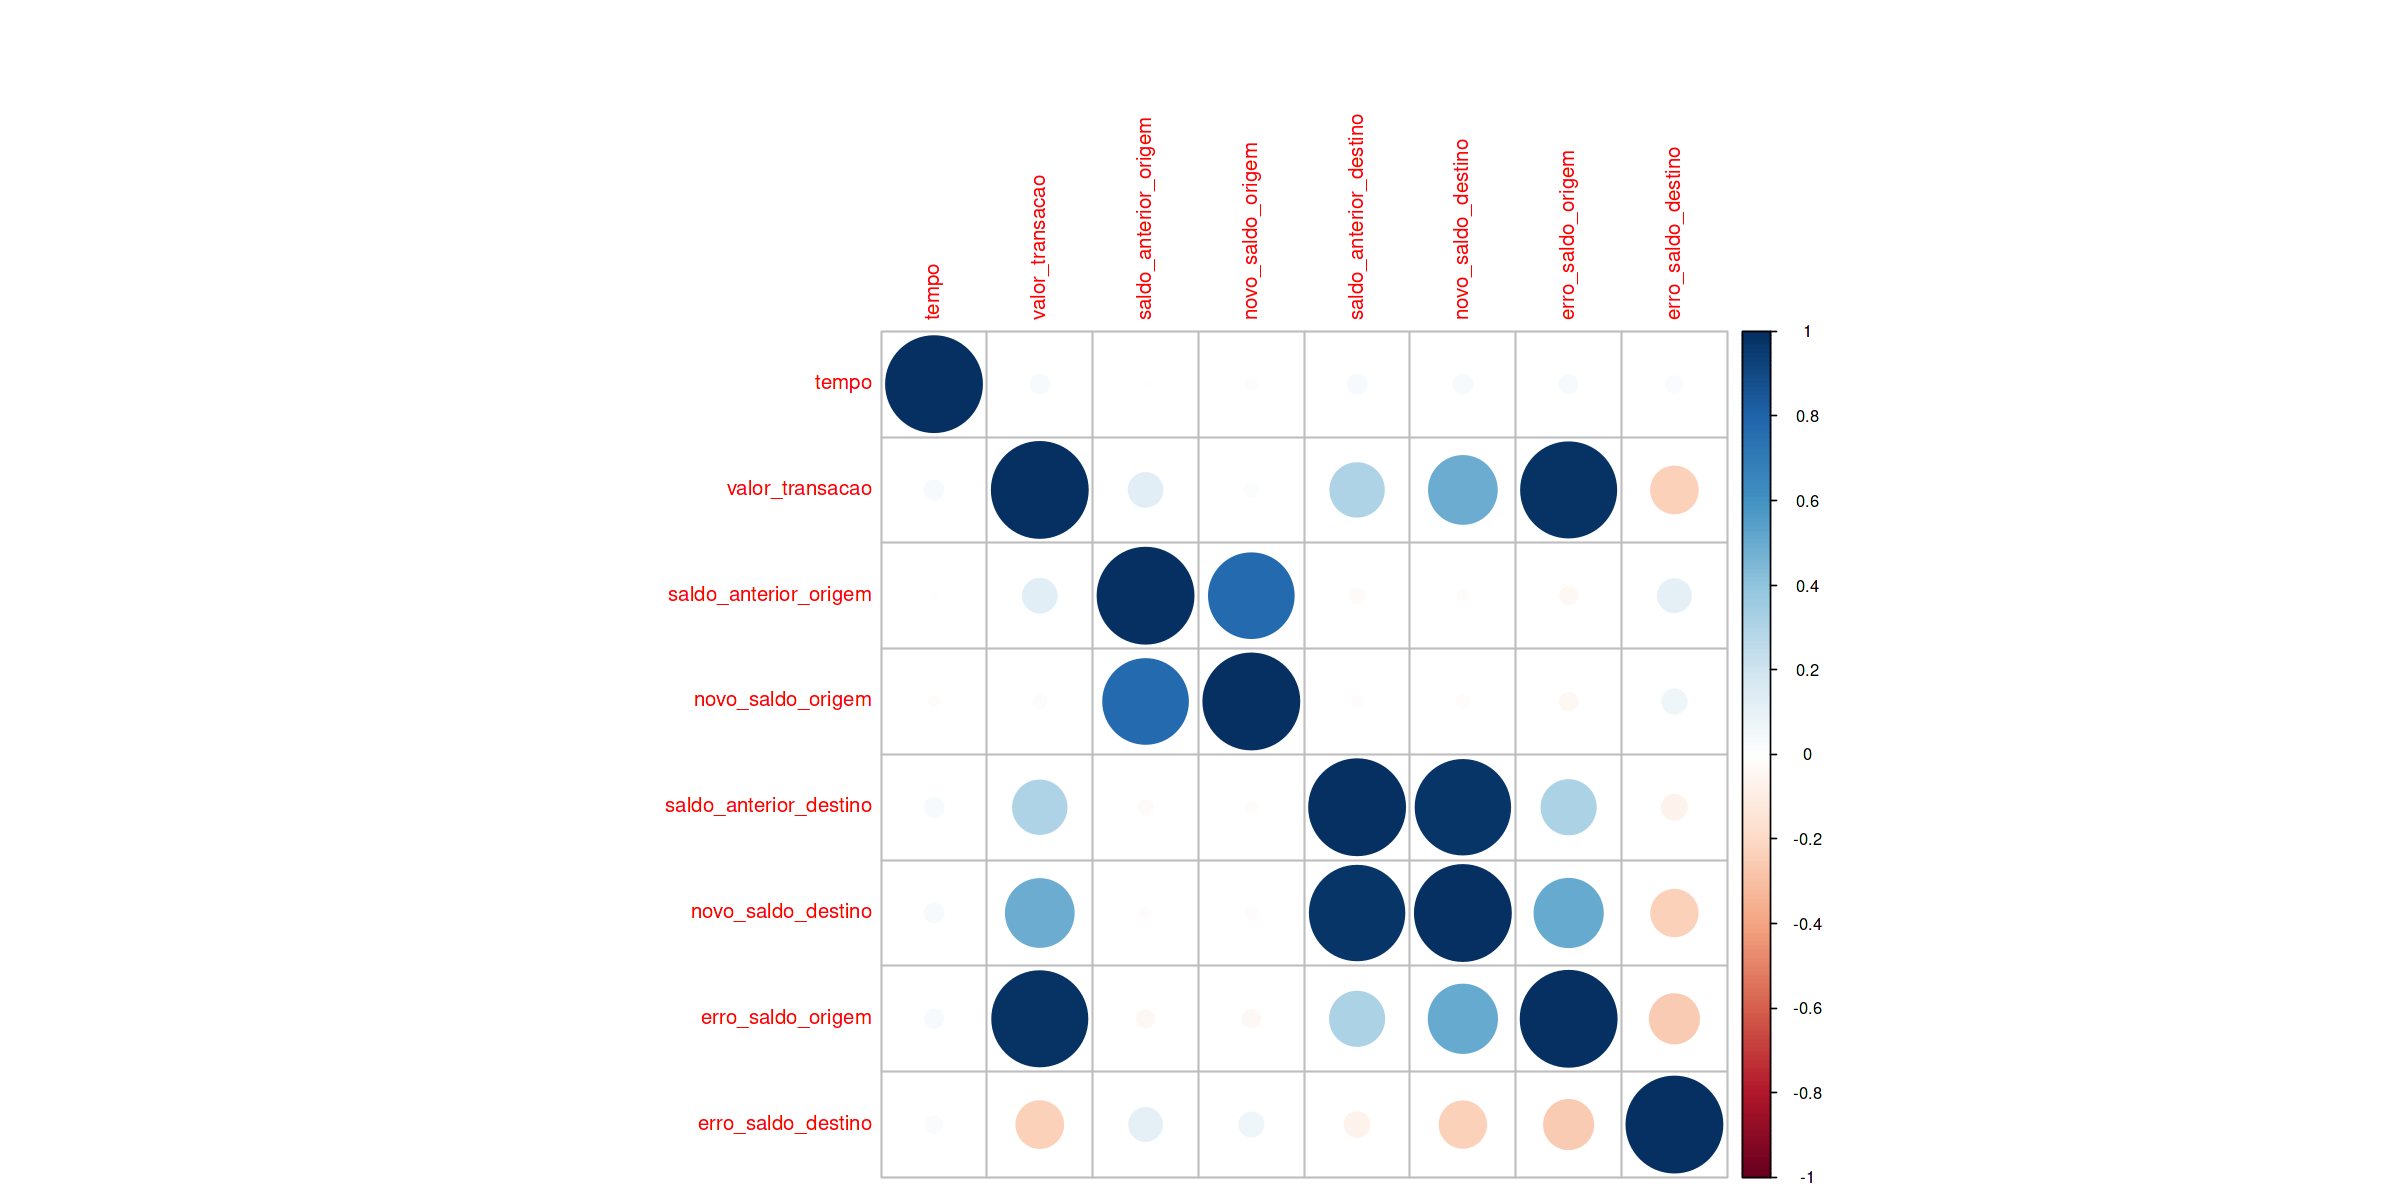

In [106]:
# Análise visual das correlações
corrplot(cor(dados_numericos), method = 'circle')

In [107]:
# Correlação
cor(dados_numericos)

,tempo,valor_transacao,saldo_anterior_origem,novo_saldo_origem,saldo_anterior_destino,novo_saldo_destino,erro_saldo_origem,erro_saldo_destino
tempo,1.0000000,0.037007,0.0057442,-0.011280,0.037778,0.037475,0.033936,0.029010
valor_transacao,0.0370075,1.000000,0.1203886,0.018296,0.307133,0.497027,0.982838,-0.234198
saldo_anterior_origem,0.0057442,0.120389,1.0000000,0.778826,-0.020403,-0.010029,-0.030438,0.113853
novo_saldo_origem,-0.0112798,0.018296,0.7788262,1.000000,-0.012277,-0.015439,-0.032263,0.061630
saldo_anterior_destino,0.0377782,0.307133,-0.0204035,-0.012277,1.000000,0.970060,0.315245,-0.065281
novo_saldo_destino,0.0374752,0.497027,-0.0100290,-0.015439,0.970060,1.000000,0.504317,-0.230329
erro_saldo_origem,0.0339361,0.982838,-0.0304383,-0.032263,0.315245,0.504317,1.000000,-0.259573
erro_saldo_destino,0.0290104,-0.234198,0.1138531,0.061630,-0.065281,-0.230329,-0.259573,1.000000


In [108]:
# Gráfico
pairs(dados_numericos)

In [109]:
# Criando um dataframe numérico para avaliar a correlação das variáveis com a resposta
treino_numerico <- data.frame(sapply(df1,as.numeric))

# Posicionando a variável Fraude ao final do dataframe e removendo a variável Orig_dest
treino_numerico <- select(treino_numerico, c(-isfraude,-Orig_dest), isfraude)

# Visualizando as primeiras linhas
head(treino_numerico)

,tempo,tipo_transacao,valor_transacao,saldo_anterior_origem,novo_saldo_origem,saldo_anterior_destino,novo_saldo_destino,dia,turno,erro_saldo_origem,erro_saldo_destino,isfraude
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,181,181,0,0,0.0,1,1,0,181,2
2,1,1,181,181,0,21182,0.0,1,1,0,21363,2
3,1,1,229134,15325,0,5083,51513.4,1,1,213809,182704,1
4,1,2,215310,705,0,22425,0.0,1,1,214605,237735,1
5,1,2,311686,10835,0,6267,2719172.9,1,1,300851,-2401220,1
6,1,1,110415,26845,0,288800,2415.2,1,1,83569,396800,1


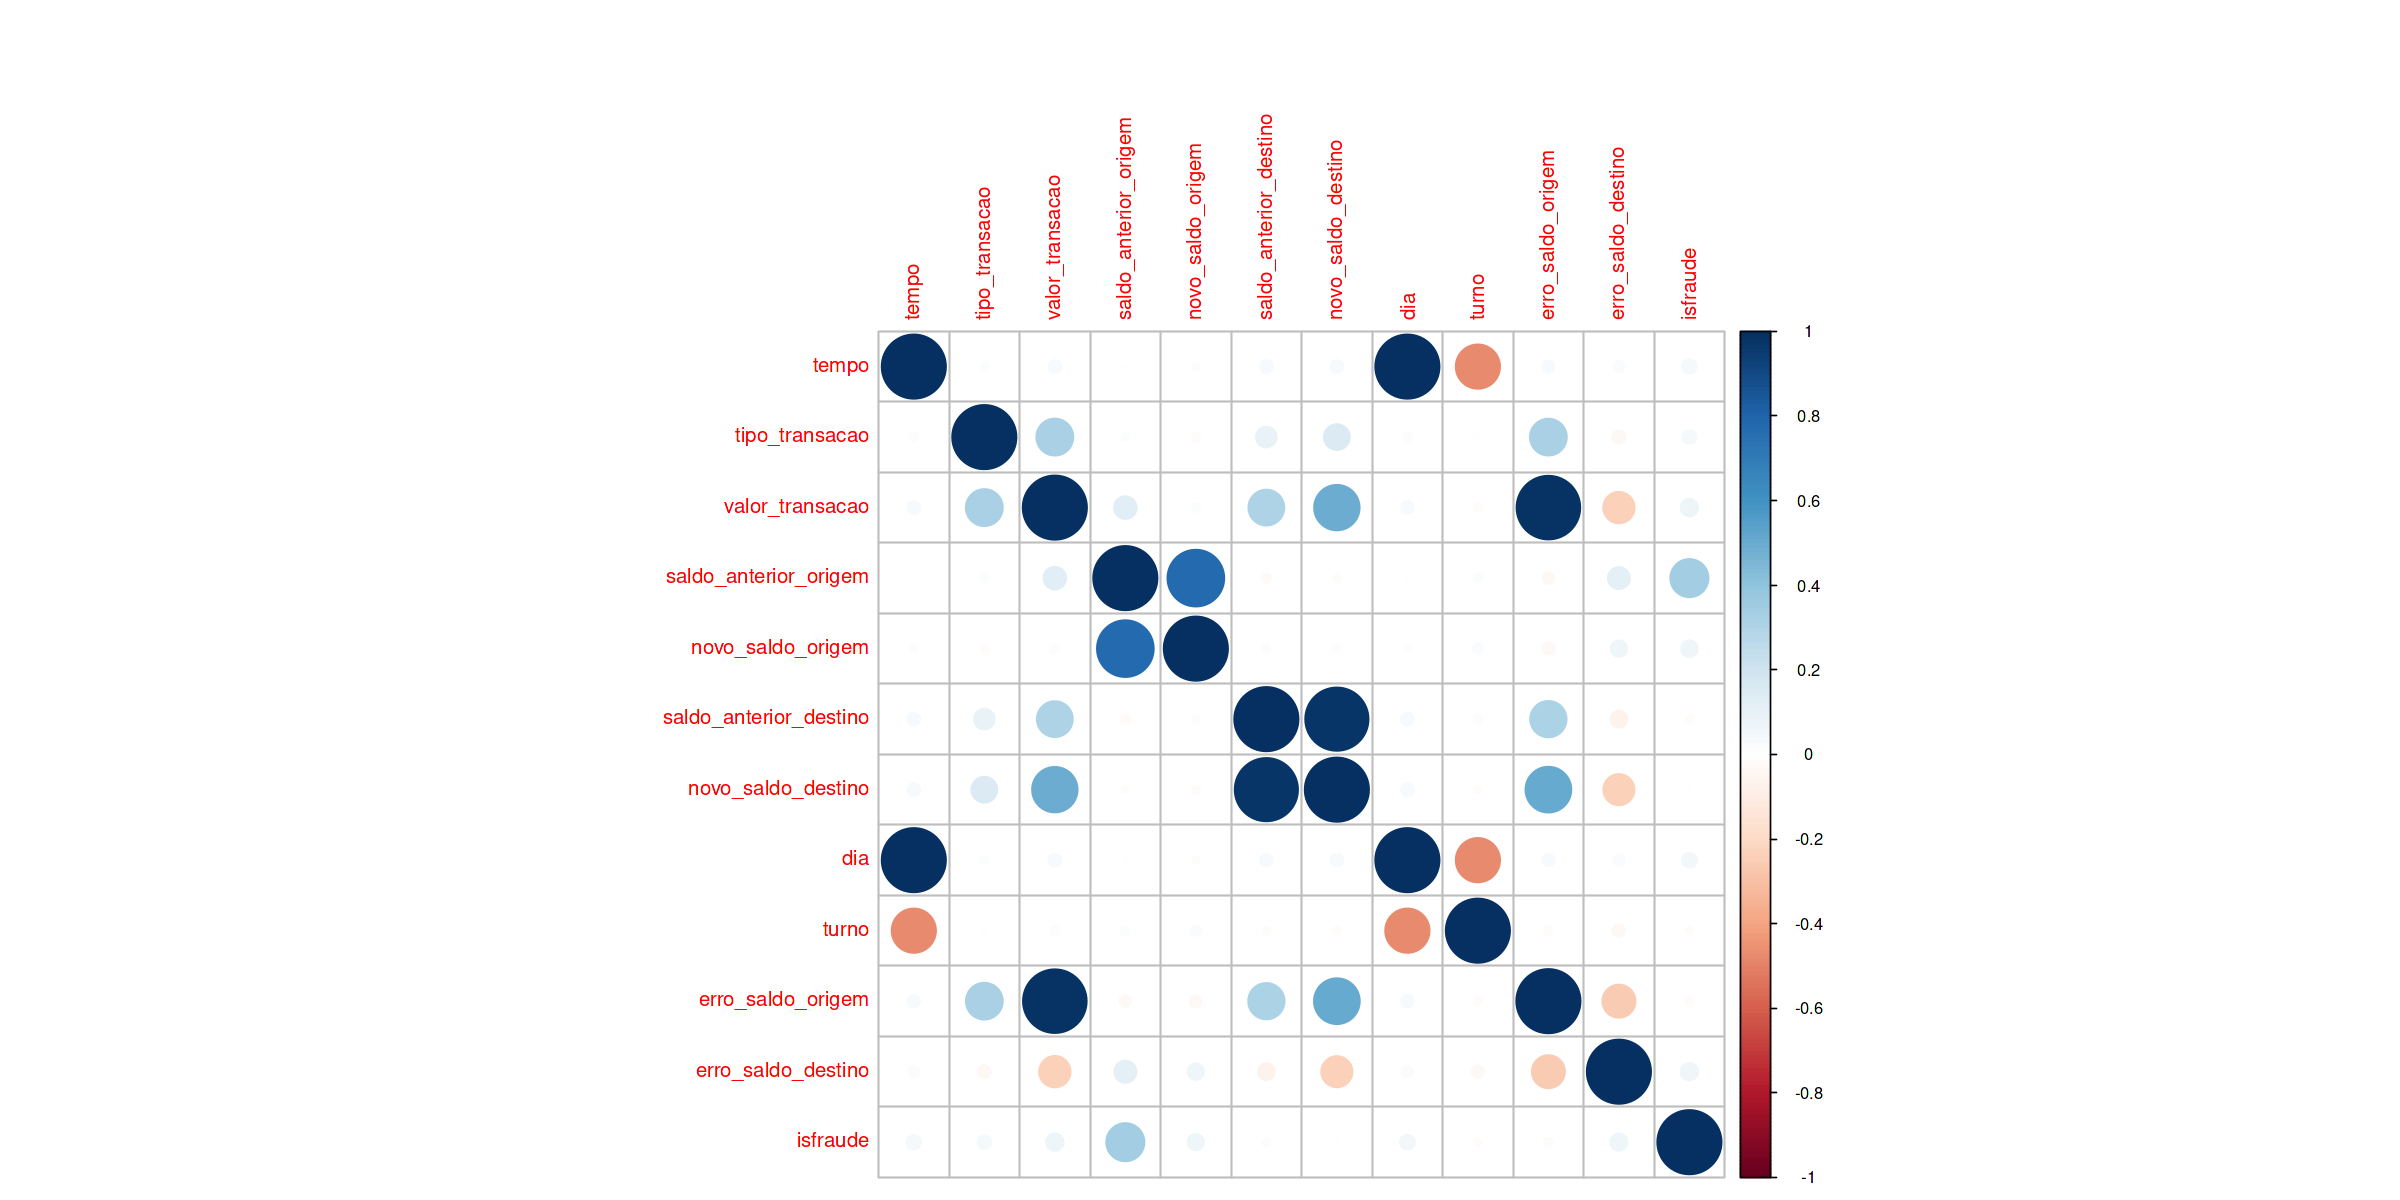

In [20]:
# Visualização gráfica das correlação com a variável resposta Fraude
corrplot(cor(treino_numerico), method = 'circle')

In [21]:
cor(treino_numerico)

,tempo,tipo_transacao,valor_transacao,saldo_anterior_origem,novo_saldo_origem,saldo_anterior_destino,novo_saldo_destino,dia,turno,erro_saldo_origem,erro_saldo_destino,isfraude
tempo,1.0000000,0.0160216,0.037007,0.0057442,-0.011280,0.037778,0.0374752,0.9996005,-0.4704787,0.033936,0.029010,0.0486708
tipo_transacao,0.0160216,1.0000000,0.326040,0.0132020,-0.018726,0.099794,0.1570243,0.0164015,-0.0086434,0.323657,-0.039197,0.0424004
valor_transacao,0.0370075,0.3260400,1.000000,0.1203886,0.018296,0.307133,0.4970267,0.0382394,-0.0170426,0.982838,-0.234198,0.0706601
saldo_anterior_origem,0.0057442,0.0132020,0.120389,1.0000000,0.778826,-0.020403,-0.0100290,0.0064647,0.0174275,-0.030438,0.113853,0.3475818
novo_saldo_origem,-0.0112798,-0.0187258,0.018296,0.7788262,1.000000,-0.012277,-0.0154395,-0.0111818,0.0240260,-0.032263,0.061630,0.0635573
saldo_anterior_destino,0.0377782,0.0997937,0.307133,-0.0204035,-0.012277,1.000000,0.9700605,0.0378088,-0.0151202,0.315245,-0.065281,-0.0149602
novo_saldo_destino,0.0374752,0.1570243,0.497027,-0.0100290,-0.015439,0.970060,1.0000000,0.0377783,-0.0125674,0.504317,-0.230329,-0.0089777
dia,0.9996005,0.0164015,0.038239,0.0064647,-0.011182,0.037809,0.0377783,1.0000000,-0.4713139,0.034996,0.028683,0.0501824
turno,-0.4704787,-0.0086434,-0.017043,0.0174275,0.024026,-0.015120,-0.0125674,-0.4713139,1.0000000,-0.018137,-0.034111,-0.0117735
erro_saldo_origem,0.0339361,0.3236572,0.982838,-0.0304383,-0.032263,0.315245,0.5043172,0.0349956,-0.0181375,1.000000,-0.259573,-0.0171494


Algumas correlações positivas foram identificadas entre as variáveis explicativas, o que não é algo positivo, podendo ocasionar multicolinearidade. À princípio serão mantidas e analisaremos as variáveis mais importantes para a predição da `isfraude`, após, decidiremos se serão mantidas ou não.

****

# 6. Variáveis Importantes para os modelos

Através do Random Forest, é possível verificar quais variáveis são mais importantes na predição da variável resposta `isfraude`.

In [110]:
# Removendo variáveis com multicolinearidades
df1$dia <- NULL
df1$turno <- NULL
df1$Orig_dest <- NULL

In [111]:
# Verificando as variáveis
str(df1)

'data.frame':	2770409 obs. of  10 variables:
 $ tempo                 : num  1 1 1 1 1 1 1 1 1 1 ...
 $ tipo_transacao        : Factor w/ 2 levels "Saque","Transferencia": 2 1 1 2 2 1 1 1 1 2 ...
 $ valor_transacao       : num  181 181 229134 215310 311686 ...
 $ saldo_anterior_origem : num  181 181 15325 705 10835 ...
 $ novo_saldo_origem     : num  0 0 0 0 0 ...
 $ saldo_anterior_destino: num  0 21182 5083 22425 6267 ...
 $ novo_saldo_destino    : num  0 0 51513 0 2719173 ...
 $ isfraude              : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 1 1 1 ...
 $ erro_saldo_origem     : num  0 0 213809 214605 300851 ...
 $ erro_saldo_destino    : num  181 21363 182704 237735 -2401220 ...


# Save Point

In [ ]:
# Salvando o Modelo Final df1
df1_v1 <- saveRDS(df1, "df1_v1.RDS")
df1_v1_csv <- write.csv(df1,"df1_v1_csv.csv")

In [ ]:
# Importanto o df1 final
df1 <- readRDS("/kaggle/working/df1_v1.RDS")

In [ ]:
head(df1)

In [112]:
# Criando uma subamostragem para analisar as variáveis importantes
indice_amostra <- caret::createDataPartition(df1$isfraude, p = 0.005, list = FALSE)
subamostra <- df1[indice_amostra,]
dim(subamostra)

[1] 13853    10

In [113]:
# Verificando os valores ausentes
sum(is.na(subamostra))

[1] 0

In [116]:
# Treinando o modelo de Random Forest
modelo_floresta <- train(isfraude ~ ., data = subamostra, method = "rf")

# Identificando as variáveis mais importantes
variaveis_importantes <- varImp(modelo_floresta)

# Extraíndo as variáveis
nomes_variaveis <- rownames(variaveis_importantes$importance)
importancia_variaveis <- variaveis_importantes$importance[ , "Overall"]

variaveis_import <- data.table(
  'Variaveis' = nomes_variaveis,
  'Importancia' = importancia_variaveis)

variaveis_import[order(-Importancia)]

In [ ]:
# Visualizando as variáveis importantes para a predição da variável resposta
ggplot(data.frame(nomes_variaveis, importancia_variaveis), aes(x = reorder(nomes_variaveis, importancia_variaveis), y = importancia_variaveis)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Variáveis mais importantes para o modelo de floresta aleatória", x = "", y = "Importância")

As variáveis `dia` e `turno` foram removidas devido problemas de multicolinearidade e a `Orig_Dest` devido não apresentar mais fatores, as demais foram consideradas como importantes para a predição. Será testados os modelos supervisionados e se necessário ajustes novamente nas variáveis.


# Continua no arquivo: ML_deteccao_transacoes_financeiras_pt02